# Car Accidents Project

## Business Objective

The objective of the test is to build a model to predict whether a police officer is likely to attend an accident.

In [3]:
# Import packages
import os
import sys
from importlib import reload
import imblearn
import pandas as pd
import warnings as w
import numpy as np
import json
import datetime
import time
import copy
import math
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from dython.nominal import associations
from dython.model_utils import metric_graph
from collections import Counter
import cufflinks as cf
from IPython.display import Image, display
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy import stats
import statsmodels.api as sm
import sidetable as stb
import sklearn
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, matthews_corrcoef, recall_score, f1_score, \
plot_confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import MaxAbsScaler
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import tensorflow as tf
from sklearn.cluster import KMeans
# Jupyter notebook settings
os.environ['root'] = '/Users/greengodfitness/Desktop/Vodafone'
os.chdir(os.environ['root'])
init_notebook_mode(connected=True)
sns.set(style="whitegrid")
w.filterwarnings('ignore',category=Warning)
%matplotlib inline
pd.options.display.max_columns = None

In [4]:
# Load data from csv file
tr_data = pd.read_csv('data/train_data.csv')
ts_data = pd.read_csv('data/test_data.csv')
df = pd.concat([tr_data, ts_data])

# Removing 8 missing values that exist on time column
df = df[df.Time.notnull()]

# Local district based data for population density
pop_density = pd.read_csv('data/population_density.csv')
pop_density = pop_density[['Local_Authority_(Highway)','Population_density']]

# Merging population density with our mai dataset
df = pd.merge(df, pop_density, how = 'left', on = 'Local_Authority_(Highway)')

## Data Understanding and Data Preprocessing

In [8]:
# Convert Date column into date format
df['Date'] = pd.to_datetime(df['Date'])

# Creating only two classes based on the task description:
# Target variable Did_Police_Officer_Attend_Scene_of_Accident is True when value is equal to 1, False otherwise
df['Did_Police_Officer_Attend_Scene_of_Accident'] = np.where(df['Did_Police_Officer_Attend_Scene_of_Accident']==-1.0, 0,
                                                        np.where(df['Did_Police_Officer_Attend_Scene_of_Accident']==2.0, 0,
                                                            np.where(df['Did_Police_Officer_Attend_Scene_of_Accident']==1.0, 1,
                                                               df['Did_Police_Officer_Attend_Scene_of_Accident'])))
df['Did_Police_Officer_Attend_Scene_of_Accident'] = df['Did_Police_Officer_Attend_Scene_of_Accident'].astype('str')

# Mapping types based on the data
df['Accident_Severity'] = df['Accident_Severity'].astype('str')
df['Day_of_Week'] = df['Day_of_Week'].astype('str')
df['1st_Road_Class'] = df['1st_Road_Class'].astype('str')
df['2nd_Road_Class'] = df['2nd_Road_Class'].astype('str')
df['Road_Type'] = df['Road_Type'].astype('str')
df['Speed_limit'] = df['Speed_limit'].astype('str')
df['Junction_Detail'] = df['Junction_Detail'].astype('str')
df['Junction_Control'] = df['Junction_Control'].astype('str')
df['Pedestrian_Crossing-Human_Control'] = df['Pedestrian_Crossing-Human_Control'].astype('str')
df['Pedestrian_Crossing-Physical_Facilities'] = df['Pedestrian_Crossing-Physical_Facilities'].astype('str')
df['Light_Conditions'] = df['Light_Conditions'].astype('str')
df['Weather_Conditions'] = df['Weather_Conditions'].astype('str')
df['Road_Surface_Conditions'] = df['Road_Surface_Conditions'].astype('str')
df['Special_Conditions_at_Site'] = df['Special_Conditions_at_Site'].astype('str')
df['Carriageway_Hazards'] = df['Carriageway_Hazards'].astype('str')
df['Urban_or_Rural_Area'] = df['Urban_or_Rural_Area'].astype('str')

### Seasonality

In [9]:
# Trend of Accidents
tr_data['Date'] = pd.to_datetime(tr_data['Date'])
dataset = tr_data.groupby(['Date']).size().reset_index(name='Accidents')
dataset['Date'] = dataset['Date']
dataset.iplot(x='Date', y='Accidents', xTitle='Date', yTitle='Accidents', color='red',
              layout = go.Layout(dict(title = 'Accidents Trend', 
                                      xaxis = dict(title = 'Date'), yaxis = dict(title = 'Accidents')), 
                                 paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)'))

To understand seasonality we can break a time series into systematic and unsystematic components.

These components are defined as follows:

- Observed: The observed value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

In [10]:
s = sm.tsa.seasonal_decompose(dataset.Accidents.values, freq=30)
trace1 = go.Scatter(x = np.arange(0, len(s.observed), 1),
                    y = s.observed,
                    mode = 'lines',
                    name = 'Observed',
                    opacity=0.5,
                    line = dict(color = ('rgb(66, 134, 244)'), width = 2))
trace2 = go.Scatter(x = np.arange(0, len(s.trend), 1),
                    y = s.trend,
                    mode = 'lines',
                    name = 'Trend',
                    line = dict(color = ('rgb(255, 102, 102)'), width = 3))
trace3 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),
                    y = s.seasonal,
                    mode = 'lines',
                    name = 'Seasonal',
                    line = dict(color = ('rgb(66, 244, 155)'), width = 2))
trace4 = go.Scatter(x = np.arange(0, len(s.resid), 1),
                    y = s.resid,
                    mode = 'lines',
                    name = 'Residual',
                    opacity=0.5,
                    line = dict(color = ('rgb(255, 153, 51)'), width = 2))
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(dict(title = 'Seasonal Decomposition (Daily)', xaxis = dict(title = 'Days'), 
              yaxis = dict(title = 'Accidents')), paper_bgcolor='rgba(0,0,0,0)',
              plot_bgcolor='rgba(0,0,0,0)')
fig = dict(data=data, layout=layout)
iplot(fig)

### Feature Engineering

#### Time and Day

In [11]:
# Converting time feature into traffic categories

# Slice the hour from time column
df['Hour'] = df['Time'].str[0:2]

# Fill values as -1 for unknown hours
df['Hour'] = df['Hour'].fillna(-1)

# convert hour to numeric datetype
df['Hour'] = df['Hour'].astype('int64')

def traffic_categories(hour):
    if hour >= 6 and hour < 10:
        return 'commuters_traffic'
    elif hour >= 10 and hour < 13:
        return 'work_start_traffic'
    elif hour >= 13 and hour < 17:
        return 'afternoon_traffic'
    elif hour >= 17 and hour < 21:
        return 'work_end_traffic'
    elif hour == -1:
        return 'unknown'
    else:
        return 'night_traffic'
    
df['traffic_category'] = df['Hour'].apply(traffic_categories)
df['Did_Police_Officer_Attend_Scene_of_Accident'] = np.where(df['Did_Police_Officer_Attend_Scene_of_Accident']=='0.0', '0',
                                   np.where(df['Did_Police_Officer_Attend_Scene_of_Accident']=='1.0', '1',
                                   df['Did_Police_Officer_Attend_Scene_of_Accident']))

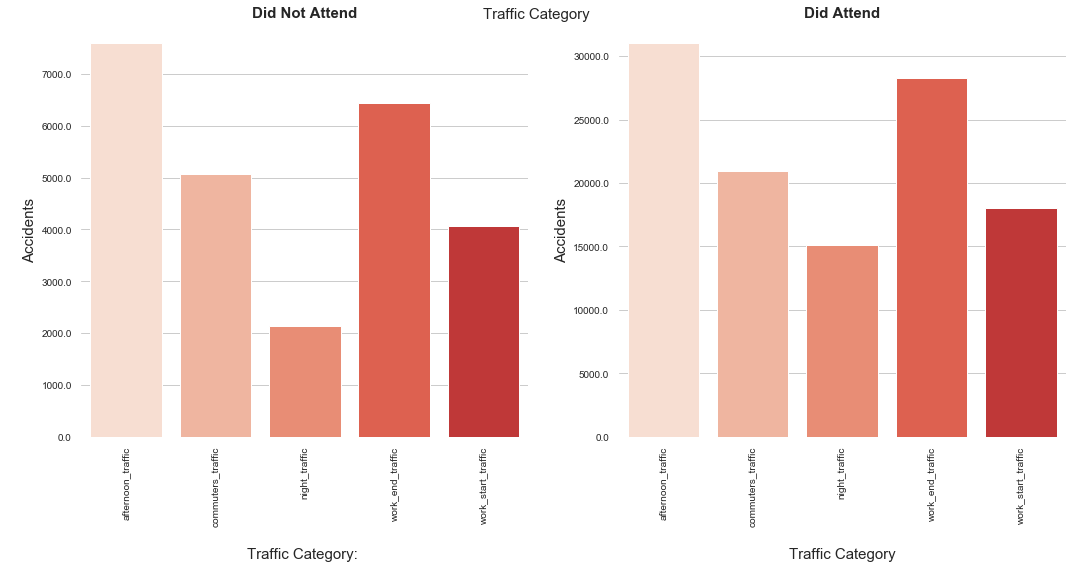

In [226]:
# Creating plot to understand pattern for traffic category with target variable
a = df.groupby(['Did_Police_Officer_Attend_Scene_of_Accident','traffic_category']).size()
a = a.unstack(level='Did_Police_Officer_Attend_Scene_of_Accident')
plt1 = a['0']
plt2 = a['1']

fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=False)
fig.suptitle('Traffic Category', fontsize = 15)

sns.barplot(ax=axes[0], x=plt1.index, y=plt1.values, palette = sns.color_palette('Reds'))
axes[0].set_title('Did Not Attend', fontsize=15, fontweight='bold')
axes[0].set_xlabel('\nTraffic Category: ', fontsize = 15)
axes[0].set_ylabel('\nAccidents', fontsize = 15)
axes[0].set_xticklabels(axes[0].xaxis.get_ticklabels(), size = 10, rotation=90)
axes[0].set_yticklabels(axes[0].get_yticks(), size = 10)

sns.barplot(ax=axes[1], x=plt2.index, y=plt2.values, palette = sns.color_palette('Reds'))
axes[1].set_title('Did Attend', fontsize=15, fontweight='bold')
axes[1].set_xlabel('\nTraffic Category', fontsize = 15)
axes[1].set_ylabel('\nAccidents', fontsize = 15)
axes[1].set_xticklabels(axes[1].xaxis.get_ticklabels(), size = 10, rotation=90)
axes[1].set_yticklabels(axes[1].get_yticks(), size = 10)

# Change bar width
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

# Remove Spines
sns.despine(ax=axes[0], top=True, right=True, left=True, bottom=True);
sns.despine(ax=axes[1], top=True, right=True, left=True, bottom=True);

plt.tight_layout()
plt.show()

Time in seconds is not a useful model input. As we seen monthly periodicity on the data, there are many ways you could deal with periodicity. A simple approach to convert it to a usable signal is to use sin and cos to convert the time to clear "Time of day" signals.

In [13]:
df['Date_'] = df.Date.astype(str)
df['Time_'] = pd.to_datetime(df['Time'],format= '%H:%M').dt.time.astype(str)
df['Date_Time'] = pd.to_datetime(df['Time_'] + ' ' + df['Date_'])

In [14]:
date_time = pd.to_datetime(df['Date_Time'], format='%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [15]:
day = 24*60*60
df['Day_Sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day_Cos'] = np.cos(timestamp_s * (2 * np.pi / day))

#### RFM and Force Allocation

Calculate Recency, Frequency and Monetary Value
- Recency: How recent was the last accident on this district?
- Frequency: How frequently an accident happens on this district?
- Monetary Value: Amount of police force located in this district?

Weight allocation is based on the feature relevance to the target variable:
- Recency: 15%
- Frequency: 45%
- Monetary Value: 50%

Each vector in RFM is normalised in quartiles and then multiplied by the weight of the vector to form an RFM Score.

Force Allocation: Calculated based on dividing overall accidents by police force to understand the allocation, if it is over or under index

In [16]:
rfm_dataset = copy.deepcopy(df)
today = datetime.datetime.now()
rfm_dataset['Date'] = pd.to_datetime(rfm_dataset['Date'],format='%Y-%m-%d')
rfm_dataset['Date_Delta'] = (today - rfm_dataset['Date']).dt.days

# Jitter function to create quartiles
nbins = 4
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

# Recency
recency = rfm_dataset.groupby(['Local_Authority_(District)'], as_index=False)['Date_Delta'].mean().round()
recency['Recency'] = pd.qcut(recency['Date_Delta'] + jitter(recency['Date_Delta']), 
                                   nbins, labels=False)+1

# Frequency
frequency = rfm_dataset.groupby(['Local_Authority_(District)']).size().reset_index(name='Accidents')
frequency['Frequency'] = pd.qcut(frequency['Accidents'] + jitter(frequency['Accidents']), 
                                   nbins, labels=False)+1

# Monetary Value
rfm_dataset['Police_Force'] = rfm_dataset['Police_Force'].astype('int64')
monetary = rfm_dataset.groupby(['Local_Authority_(District)'], as_index=False)['Police_Force'].sum().round()
monetary['Monetary'] = pd.qcut(monetary['Police_Force'] + jitter(monetary['Police_Force']), 
                                   nbins, labels=False)+1

# Merge the score to create rfm_score column
rec_fre = pd.merge(recency, frequency, how = 'inner', on = 'Local_Authority_(District)')
rec_fre_mon = pd.merge(rec_fre, monetary, how = 'inner', on = 'Local_Authority_(District)')

# Apply weights
rec_fre_mon['rec_score'] = rec_fre_mon['Recency'] * 15
rec_fre_mon['fre_score'] = rec_fre_mon['Frequency'] * 45
rec_fre_mon['mon_score'] = rec_fre_mon['Monetary'] * 50

rec_fre_mon['rfm_score'] = rec_fre_mon['rec_score'] + rec_fre_mon['fre_score'] + rec_fre_mon['mon_score']
rec_fre_mon['rfm_score_decile'] = pd.qcut(rec_fre_mon['rfm_score'] + jitter(rec_fre_mon['rfm_score']), 
                                   10, labels=False)+1

# Police force index by accidents (under index or over index)
rec_fre_mon['force_allocation'] = (rec_fre_mon['Accidents'] / rec_fre_mon['Police_Force']).apply(lambda x: \
                                                                                        float("{:.2f}".format(x)))
average_index = rec_fre_mon['force_allocation'].mean()
rec_fre_mon['force_index'] = np.where(rec_fre_mon['force_allocation']<average_index, 0,
                                np.where(rec_fre_mon['force_allocation']>=average_index, 1, ''))

# Merge it to main dataframe
rec_fre_mon = rec_fre_mon[['Local_Authority_(District)','rfm_score','rfm_score_decile','force_allocation',
                           'force_index']]
df = pd.merge(df, rec_fre_mon, how = 'inner', on = 'Local_Authority_(District)')

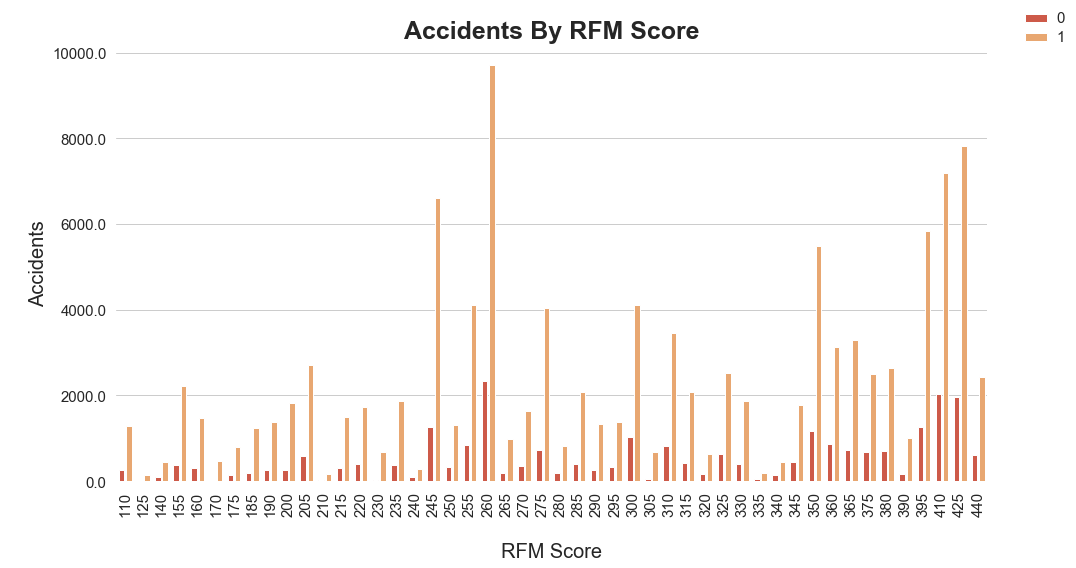

In [17]:
# Creating plot to understand pattern for rfm model feature with target variable
plot_rfm = copy.deepcopy(df)
plot_rfm = plot_rfm[~plot_rfm.Accident_Index.isin(ts_data.Accident_Index)]
plot_rfm['Did_Police_Officer_Attend_Scene_of_Accident'] = np.where(plot_rfm['Did_Police_Officer_Attend_Scene_of_Accident']=='0.0', '0',
                                   np.where(plot_rfm['Did_Police_Officer_Attend_Scene_of_Accident']=='1.0', '1',
                                   plot_rfm['Did_Police_Officer_Attend_Scene_of_Accident']))

f, ax = plt.subplots(figsize=(15,8))

# Bar plot
sns.barplot(x='rfm_score', y='Accidents', 
            hue='Did_Police_Officer_Attend_Scene_of_Accident', 
            data= plot_rfm.groupby(['rfm_score','Did_Police_Officer_Attend_Scene_of_Accident'])\
            .size().reset_index(name='Accidents'),
            palette = sns.color_palette('RdYlBu'))

# Set plot labels
ax.set_title('Accidents By RFM Score', fontsize=25, fontweight='bold')
ax.set_xlabel('\nRFM Score', fontsize = 20)
ax.set_ylabel('\nAccidents', fontsize = 20)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), size = 15, rotation=90)
ax.set_yticklabels(ax.get_yticks(), size = 15)
ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize='15')

# Change bar width
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .30)

# Remove Spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

plt.tight_layout()
plt.show()

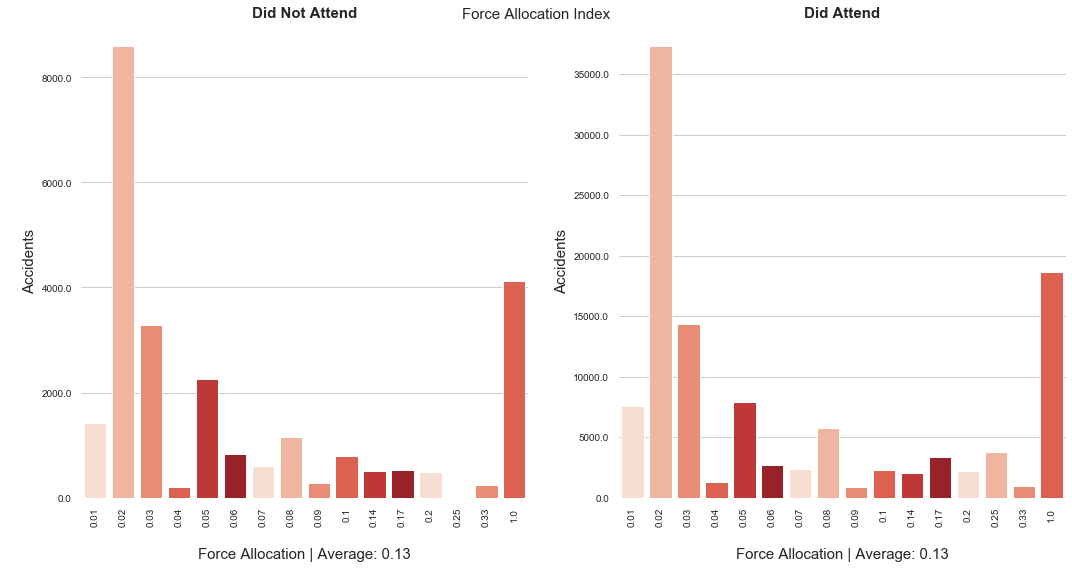

In [18]:
# Creating plot to understand pattern for force allocation with target variable
average = str(round(average_index, 2))

a = plot_rfm.groupby(['Did_Police_Officer_Attend_Scene_of_Accident','force_allocation']).size()
a = a.unstack(level='Did_Police_Officer_Attend_Scene_of_Accident')
plt1 = a['0']
plt2 = a['1']

fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=False)
fig.suptitle('Force Allocation Index', fontsize = 15)

sns.barplot(ax=axes[0], x=plt1.index, y=plt1.values, palette = sns.color_palette('Reds'))
axes[0].set_title('Did Not Attend', fontsize=15, fontweight='bold')
axes[0].set_xlabel('\nForce Allocation | Average: ' + average, fontsize = 15)
axes[0].set_ylabel('\nAccidents', fontsize = 15)
axes[0].set_xticklabels(axes[0].xaxis.get_ticklabels(), size = 10, rotation=90)
axes[0].set_yticklabels(axes[0].get_yticks(), size = 10)

sns.barplot(ax=axes[1], x=plt2.index, y=plt2.values, palette = sns.color_palette('Reds'))
axes[1].set_title('Did Attend', fontsize=15, fontweight='bold')
axes[1].set_xlabel('\nForce Allocation | Average: ' + average, fontsize = 15)
axes[1].set_ylabel('\nAccidents', fontsize = 15)
axes[1].set_xticklabels(axes[1].xaxis.get_ticklabels(), size = 10, rotation=90)
axes[1].set_yticklabels(axes[1].get_yticks(), size = 10)

# Change bar width
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

# Remove Spines
sns.despine(ax=axes[0], top=True, right=True, left=True, bottom=True);
sns.despine(ax=axes[1], top=True, right=True, left=True, bottom=True);

plt.tight_layout()
plt.show()

#### K-Means Clusters

Unsupervised learning is a type of machine learning in which the algorithm is not provided with any pre-assigned labels or scores for the training data. As a result, unsupervised learning algorithms must first self-discover any naturally occurring patterns in that training data set.

Cluster based on below factors that explains the road type, the condition and the detail of the road:
- Road_Type
- Speed_limit
- Junction_Control
- Light_Conditions
- Weather_Conditions
- Road_Surface_Conditions
- Urban_or_Rural_Area

In [19]:
clust_df = copy.deepcopy(df)
# Removing unwanted columns and selecting columns for creating clusters
clust_df = clust_df[['Accident_Index', 'Road_Type', 'Speed_limit', 'Junction_Control', 
       'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area']]

In [20]:
# Creating Kmeans function to create raw clusters on our dataset as a feature for the model to train
def Kmeans(data, output='add'):
        n_clusters = 6
        db_id = data['Accident_Index']
        del data['Accident_Index']
        clf = KMeans(n_clusters = n_clusters, random_state=12)
        clf.fit(data)
        y_labels_train = clf.labels_
        if output == 'add':
            data['km_clusters'] = y_labels_train
        elif output == 'replace':
            data = y_labels_train[:, np.newaxis]
        else:
            raise ValueError('Output should be either add or replace')
        db = pd.concat([db_id, data], axis = 1)
        return db
clusters = Kmeans(data=clust_df, output='add')
clusters['km_clusters'] = clusters['km_clusters'].astype('str')
clusters = clusters[['Accident_Index','km_clusters']]
df = pd.merge(df, clusters, how = 'inner', on = 'Accident_Index')

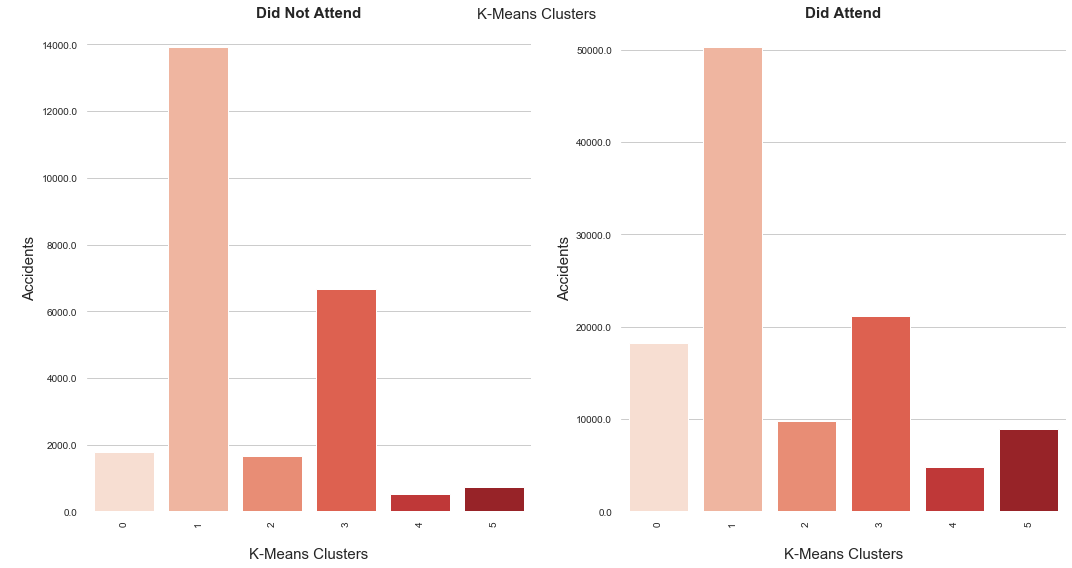

In [21]:
# Plotting clusters against the target variable to understand the pattern in the feature
plot_clusters = copy.deepcopy(df)
plot_clusters = plot_clusters[~plot_clusters.Accident_Index.isin(ts_data.Accident_Index)]
plot_clusters['Did_Police_Officer_Attend_Scene_of_Accident'] = np.where(plot_clusters\
                                ['Did_Police_Officer_Attend_Scene_of_Accident']=='0.0', '0',
                                   np.where(plot_clusters['Did_Police_Officer_Attend_Scene_of_Accident']=='1.0', '1',
                                   plot_clusters['Did_Police_Officer_Attend_Scene_of_Accident']))
a = plot_clusters.groupby(['Did_Police_Officer_Attend_Scene_of_Accident','km_clusters']).size()
a = a.unstack(level='Did_Police_Officer_Attend_Scene_of_Accident')
plt1 = a['0']
plt2 = a['1']

fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=False)
fig.suptitle('K-Means Clusters', fontsize = 15)

sns.barplot(ax=axes[0], x=plt1.index, y=plt1.values, palette = sns.color_palette('Reds'))
axes[0].set_title('Did Not Attend', fontsize=15, fontweight='bold')
axes[0].set_xlabel('\nK-Means Clusters', fontsize = 15)
axes[0].set_ylabel('\nAccidents', fontsize = 15)
axes[0].set_xticklabels(axes[0].xaxis.get_ticklabels(), size = 10, rotation=90)
axes[0].set_yticklabels(axes[0].get_yticks(), size = 10)

sns.barplot(ax=axes[1], x=plt2.index, y=plt2.values, palette = sns.color_palette('Reds'))
axes[1].set_title('Did Attend', fontsize=15, fontweight='bold')
axes[1].set_xlabel('\nK-Means Clusters', fontsize = 15)
axes[1].set_ylabel('\nAccidents', fontsize = 15)
axes[1].set_xticklabels(axes[1].xaxis.get_ticklabels(), size = 10, rotation=90)
axes[1].set_yticklabels(axes[1].get_yticks(), size = 10)

# Change bar width
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

# Remove Spines
sns.despine(ax=axes[0], top=True, right=True, left=True, bottom=True);
sns.despine(ax=axes[1], top=True, right=True, left=True, bottom=True);

plt.tight_layout()
plt.show()

In [22]:
# Features for visualisation
data_eda = copy.deepcopy(df)

# Removing unwanted columns and seleting overall features for model training
df = df[['Accident_Index', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties','1st_Road_Class', 'Road_Type', 
       'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 
       'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Day_of_Week',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'traffic_category', 'rfm_score', 'force_allocation', 'Day_Sin', 
       'Day_Cos', 'km_clusters', 'Population_density']]

### Missing Values

<b>Handling Missing Values:</b> Values in the 'Time' column are removed from the dataset as they're only 8 rows which makes upto 0.005% of the dataset and the values in 'population_density' column are filled based on average value of the column. (Total Missing: 1,316 - 0.9%)

In [23]:
# Checking if there are any missing values in the dataset
df.stb.missing()

,Missing,Total,Percent
Population_density,1316,150955,0.008718
Police_Force,0,150955,0.000000
km_clusters,0,150955,0.000000
Day_Cos,0,150955,0.000000
Day_Sin,0,150955,0.000000
force_allocation,0,150955,0.000000
rfm_score,0,150955,0.000000
traffic_category,0,150955,0.000000
Did_Police_Officer_Attend_Scene_of_Accident,0,150955,0.000000
Urban_or_Rural_Area,0,150955,0.000000


As it is an outside data source and might not have link with our main data so we just fill in the missing values based on average.

In [24]:
df['Population_density'] = df['Population_density'].fillna(df['Population_density'].mean())

### Outliers

The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

In theory, 99.7% of the data points of a normally distributed data set will be between +3 and -3 standard deviation away from the mean as shown in the figure below. That means that all the values with a standard deviation above 3 or below -3 will be considered as outliers.

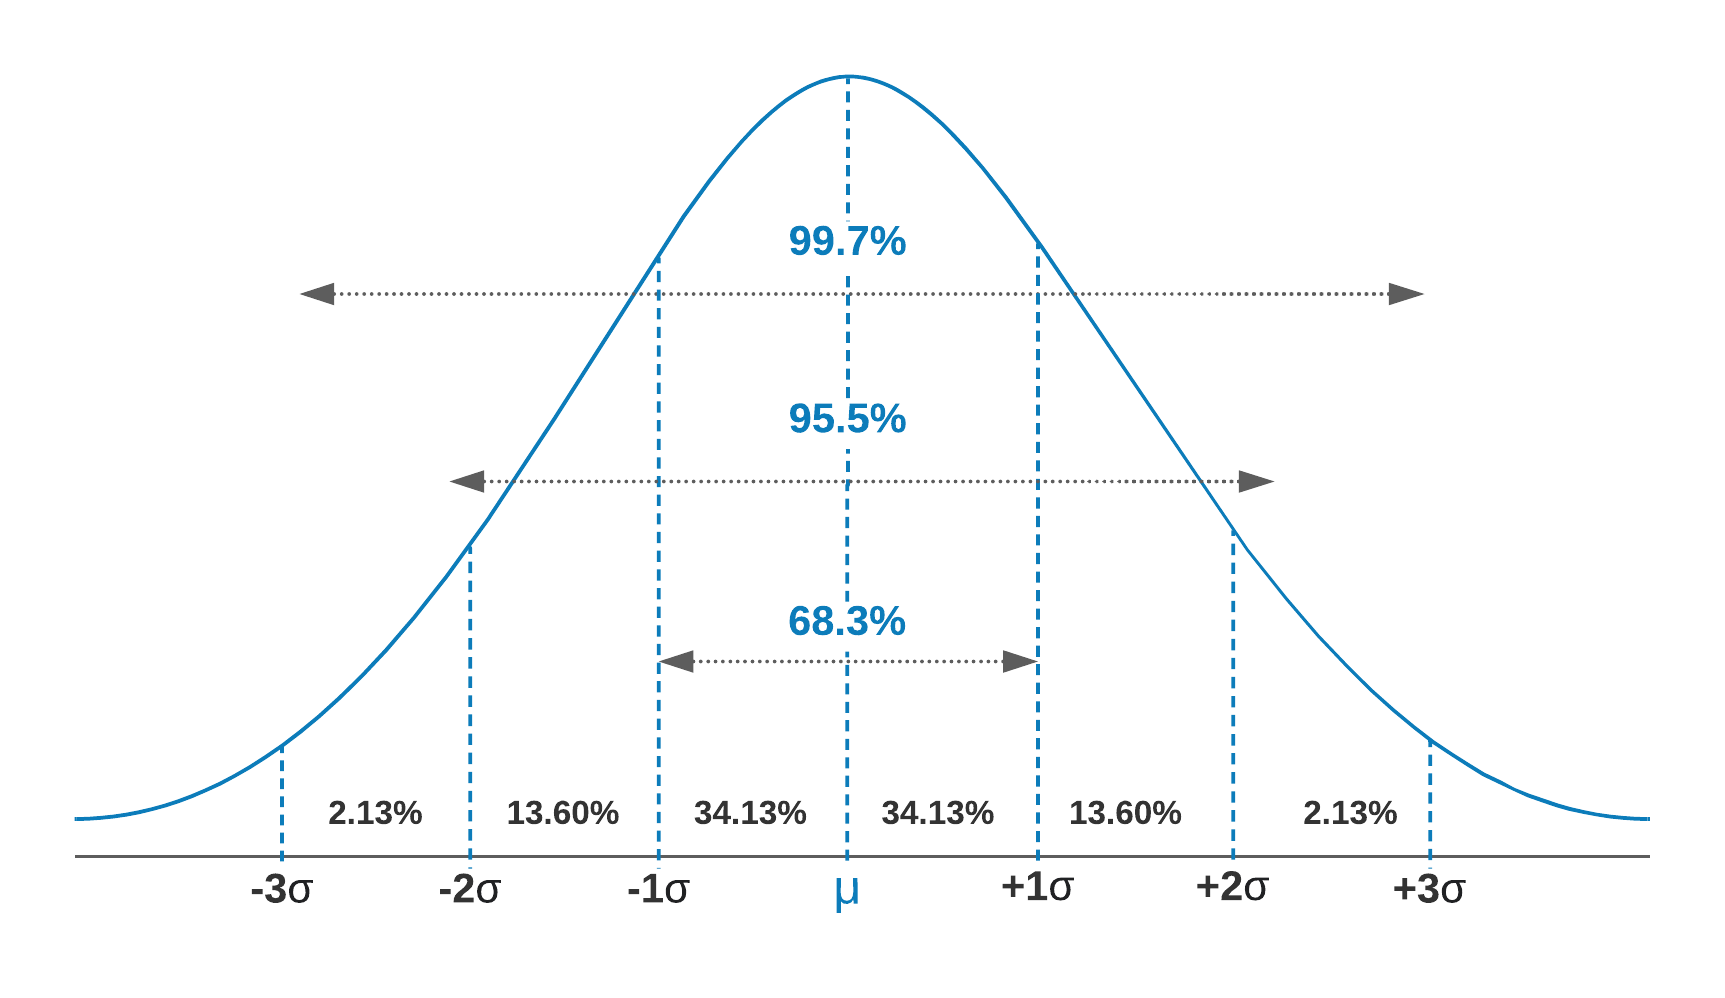

In [26]:
Image(filename='www/distribution.png') 

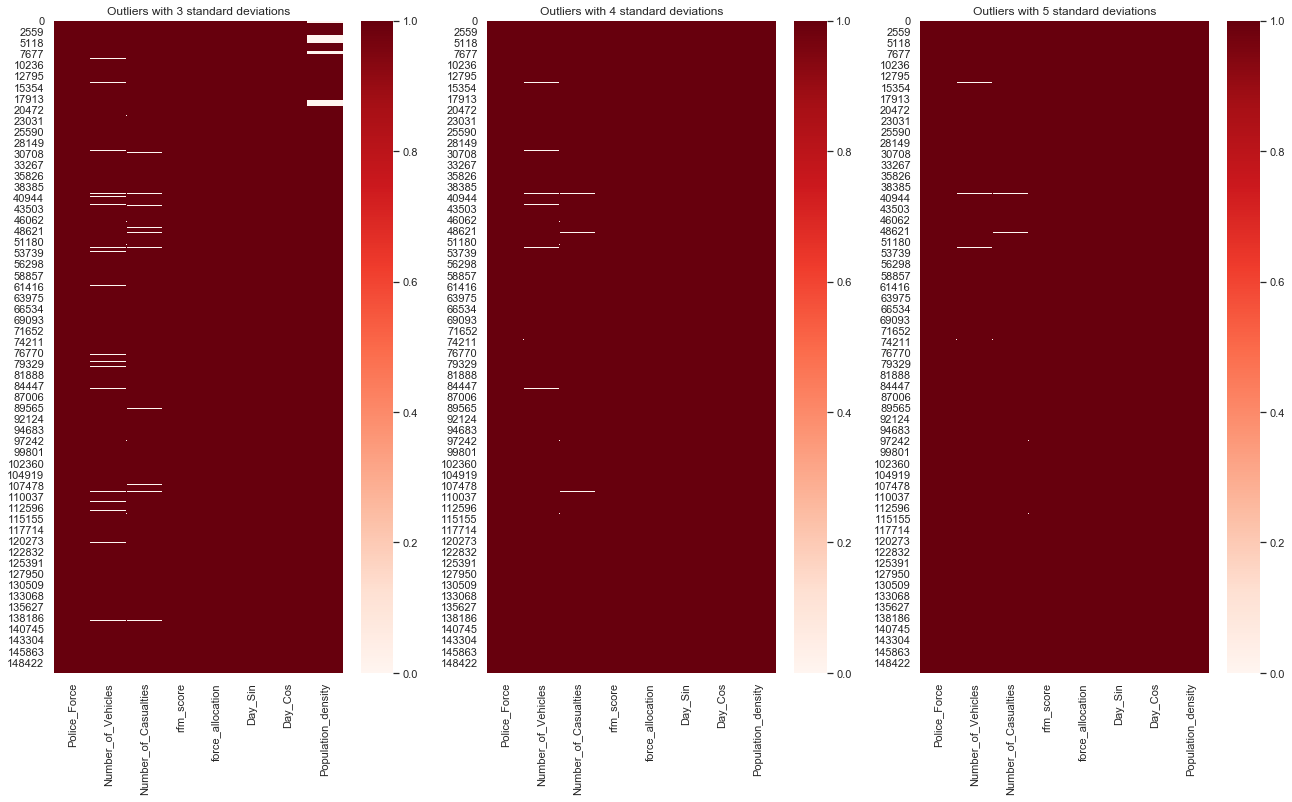

In [27]:
# Creating a heatmap to understand pattern of outliers in the dataset
df0 = copy.deepcopy(df)
columns_ = list(df0.select_dtypes(include=['int64','float64']).columns)
df0 = df0[columns_].iloc[:,0:len(columns_)]

def std_outlier(st, nstd=3.0, return_thresholds=False):
    data_mean, data_std = st.mean(), st.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [False if x < lower or x > upper else True for x in st]

std2 = df0.apply(std_outlier, nstd=3.0)
std3 = df0.apply(std_outlier, nstd=4.0)
std4 = df0.apply(std_outlier, nstd=5.0)

f, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(22, 12));
ax1.set_title('Outliers with 3 standard deviations');
ax2.set_title('Outliers with 4 standard deviations');
ax3.set_title('Outliers with 5 standard deviations');

sns.heatmap(std2, cmap='Reds', ax=ax1);
sns.heatmap(std3, cmap='Reds', ax=ax2);
sns.heatmap(std4, cmap='Reds', ax=ax3);

plt.show()

<b>Handling Outliers</b>: Values with a standard deviation above +3 or below -3 will be considered as outliers and filled in based on the interpolate function with linear values.

In [28]:
# Remove_outlier fucntion is created to remove the outliers in the dataset
def remove_outliers(skewed_dataset=df):
    columns_ = list(skewed_dataset.select_dtypes(include=['int64','float64']).columns)
    columns_.remove('Population_density')
    str_columns = list(skewed_dataset.select_dtypes(include=['object']).columns)
    str_columns.remove('Accident_Index')
    str_columns.remove('Did_Police_Officer_Attend_Scene_of_Accident')
    db_id = skewed_dataset['Accident_Index']
    db1 = skewed_dataset[columns_]
    db2 = skewed_dataset[str_columns]
    db3 = skewed_dataset[['Population_density']]
    target = skewed_dataset['Did_Police_Officer_Attend_Scene_of_Accident']
    z = (np.abs(stats.zscore(db1)) > 3)
    unskewed_dataset = db1.mask(z).interpolate(method = 'linear')
    db = pd.concat([db_id, unskewed_dataset, db3, db2, target], axis = 1)
    return db

model_dataset = remove_outliers(df)

### Unseen Dataset

In [30]:
# Test dataset
test_data = model_dataset[model_dataset.Accident_Index.isin(ts_data.Accident_Index)]

# Delete the test dataset from the training dataset
model_dataset = model_dataset[~model_dataset.Accident_Index.isin(ts_data.Accident_Index)]

model_dataset['Did_Police_Officer_Attend_Scene_of_Accident'] = np.where(model_dataset['Did_Police_Officer_Attend_Scene_of_Accident']=='0.0', '0',
                                   np.where(model_dataset['Did_Police_Officer_Attend_Scene_of_Accident']=='1.0', '1',
                                   model_dataset['Did_Police_Officer_Attend_Scene_of_Accident']))

# Reset index
model_dataset = model_dataset.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

### Exploratory Data Analysis

In [31]:
eda_df = copy.deepcopy(model_dataset)

data_eda = data_eda[['Accident_Index','Date']]

# Merging to get dates
eda_df = pd.merge(eda_df, data_eda, how = 'inner', on = 'Accident_Index')

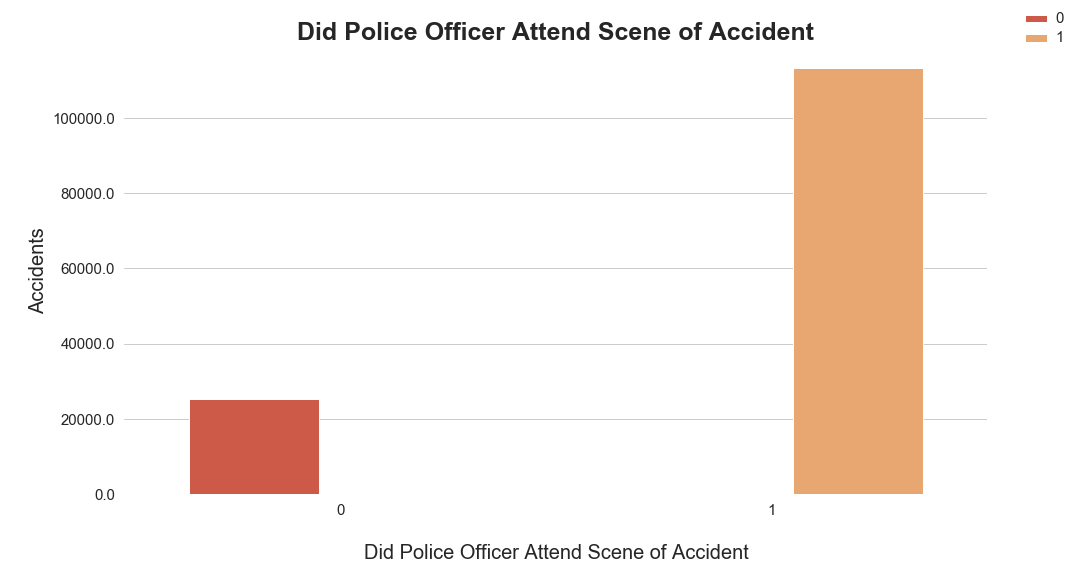

In [32]:
f, ax = plt.subplots(figsize=(15,8))

# Bar plot
sns.barplot(x='Did_Police_Officer_Attend_Scene_of_Accident', y='Accidents', 
            hue='Did_Police_Officer_Attend_Scene_of_Accident', 
            data= eda_df.groupby(['Did_Police_Officer_Attend_Scene_of_Accident']).size()\
            .reset_index(name='Accidents'),
            palette = sns.color_palette('RdYlBu'))

# Set plot labels
ax.set_title('Did Police Officer Attend Scene of Accident', fontsize=25, fontweight='bold')
ax.set_xlabel('\nDid Police Officer Attend Scene of Accident', fontsize = 20)
ax.set_ylabel('\nAccidents', fontsize = 20)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), size = 15)
ax.set_yticklabels(ax.get_yticks(), size = 15)
ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize='15')

# Change bar width
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .30)

# Remove Spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

plt.tight_layout()
plt.show()
# f.savefig('plotname.png', transparent=True)

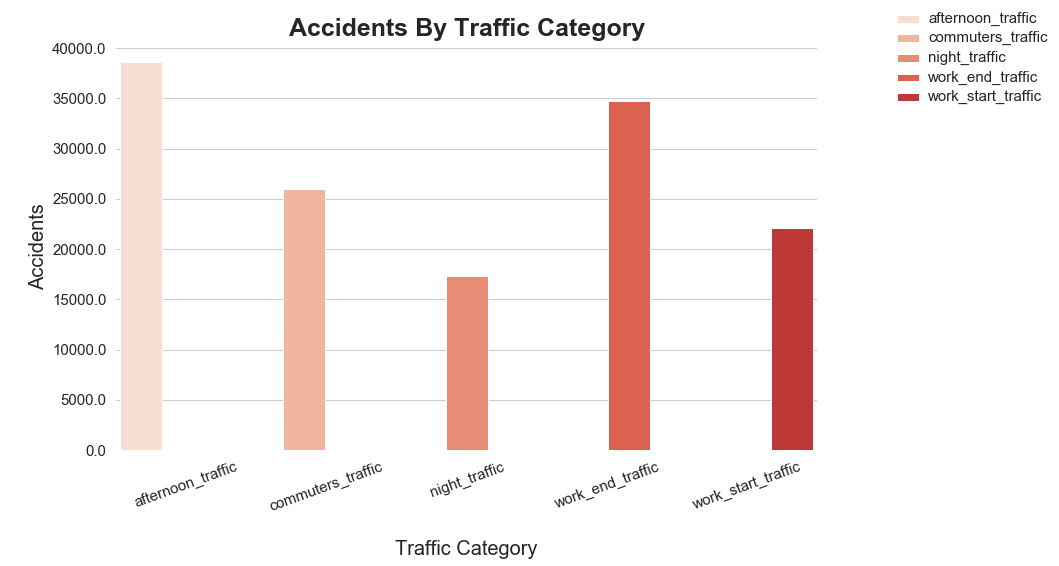

In [219]:
# Plot to see the pattern for accidents by traffic category
f, ax = plt.subplots(figsize=(15,8))

# Bar plot
sns.barplot(x='traffic_category', y='Accidents', 
            hue='traffic_category', 
            data= eda_df.groupby(['traffic_category']).size().reset_index(name='Accidents'),
            palette = sns.color_palette("Reds"))

# Set plot labels
ax.set_title('Accidents By Traffic Category', fontsize=25, fontweight='bold')
ax.set_xlabel('\nTraffic Category', fontsize = 20)
ax.set_ylabel('\nAccidents', fontsize = 20)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), size = 15, rotation=20)
ax.set_yticklabels(ax.get_yticks(), size = 15)
ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize='15')

# Change bar width
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .30)

# Remove Spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

plt.tight_layout()
plt.show()

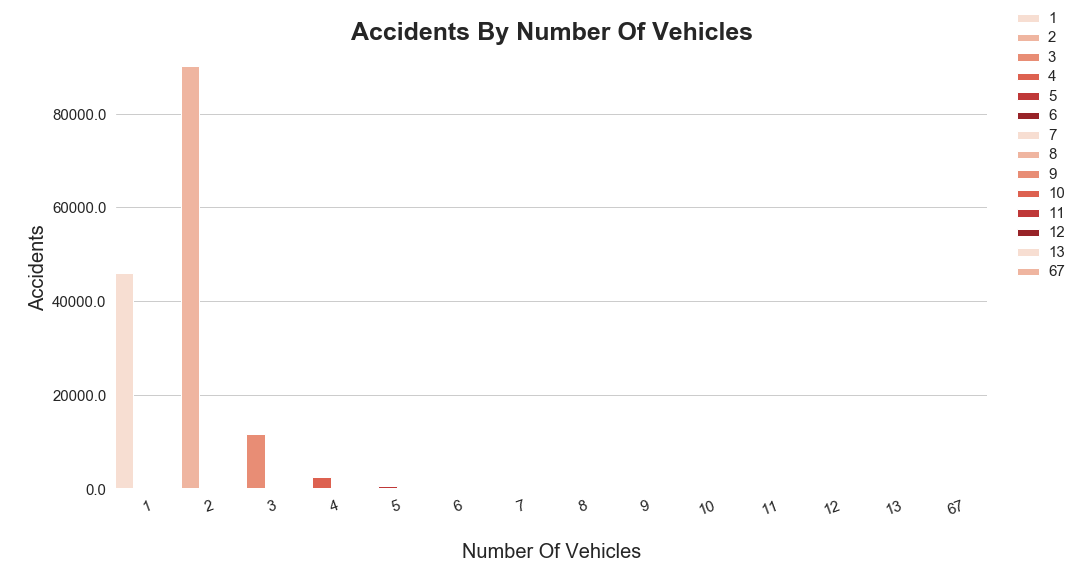

In [229]:
# Plot to see the pattern for accidents by number of vehicles
f, ax = plt.subplots(figsize=(15,8))

# Bar plot
sns.barplot(x='Number_of_Vehicles', y='Accidents', 
            hue='Number_of_Vehicles', 
            data= df.groupby(['Number_of_Vehicles']).size().reset_index(name='Accidents'),
            palette = sns.color_palette("Reds"))

# Set plot labels
ax.set_title('Accidents By Number Of Vehicles', fontsize=25, fontweight='bold')
ax.set_xlabel('\nNumber Of Vehicles', fontsize = 20)
ax.set_ylabel('\nAccidents', fontsize = 20)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), size = 15, rotation=20)
ax.set_yticklabels(ax.get_yticks(), size = 15)
ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize='15')

# Change bar width
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .30)

# Remove Spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

plt.tight_layout()
plt.show()

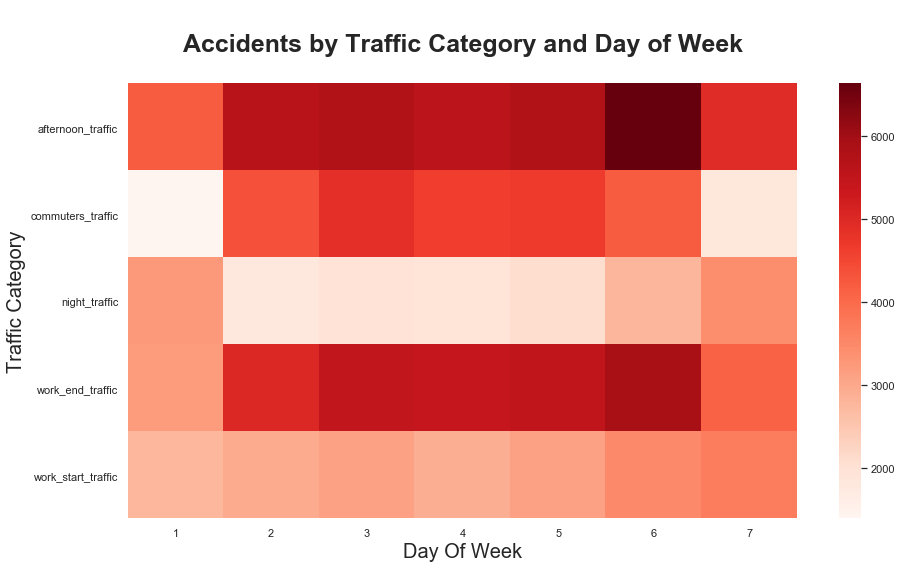

In [35]:
# Heatmap based on traffic type and day of week
traffic_category = eda_df['traffic_category']
Day_of_Week    = eda_df['Day_of_Week']
days = ['1', '2', '3', '4', '5', '6', '7']
eda_table = eda_df.groupby([traffic_category, Day_of_Week]).size()
eda_table = eda_table.rename_axis(['traffic_category', 'Day_of_Week'])\
                               .unstack('Day_of_Week')\
                               .reindex(columns=days)
plt.figure(figsize=(15,8))
sns.heatmap(eda_table, cmap='Reds')
plt.title('\nAccidents by Traffic Category and Day of Week\n', fontsize=25, fontweight='bold')
plt.xlabel('Day Of Week', fontsize=20)
plt.ylabel('Traffic Category', fontsize=20);

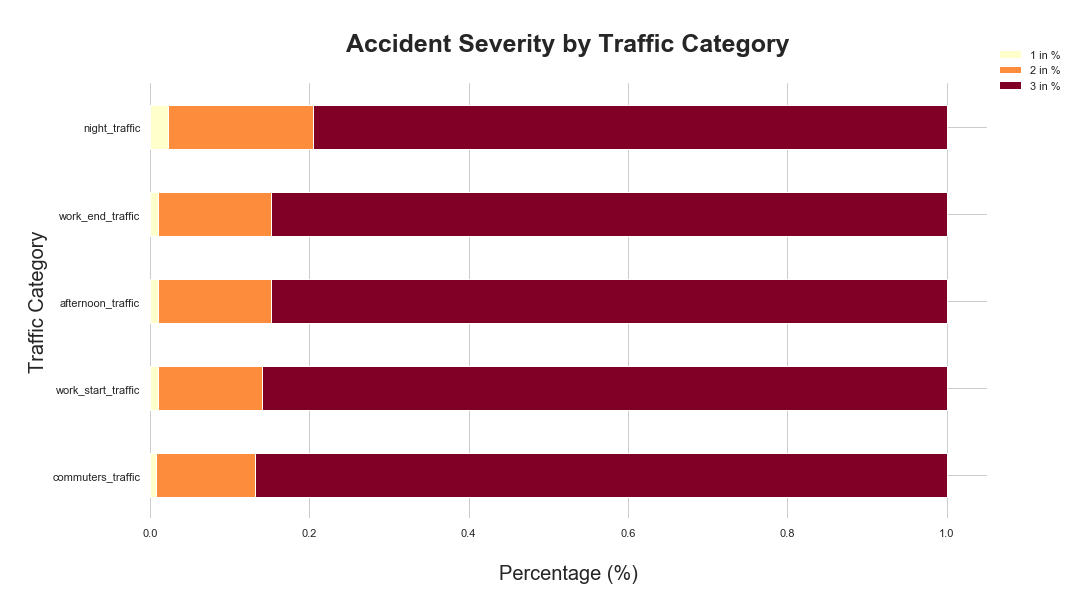

In [36]:
# Accident Severity by Traffic Category
traffic_category = eda_df['traffic_category']
Accident_Severity    = eda_df['Accident_Severity']
speed = ['1', '2', '3']
eda_table1 = eda_df.groupby([traffic_category, Accident_Severity]).size()
eda_table1 = eda_table1.rename_axis(['traffic_category', 'Accident_Severity'])\
                               .unstack('Accident_Severity')\
                               .reindex(columns=speed)

# prepare dataframe with shares
eda_table1['sum'] = eda_table1.sum(axis=1)
eda_table1 = eda_table1.join(eda_table1.div(eda_table1['sum'], axis=0), rsuffix=' in %')
eda_table1_percentage = eda_table1.drop(columns=['1', '2', '3', 'sum', 'sum in %'], axis=1)
fig, ax = plt.subplots(figsize=(15, 8))

# Order the day times of traffic category
order = ['commuters_traffic', 'work_start_traffic', 'afternoon_traffic', 'work_end_traffic', 'night_traffic']

# plot
eda_table1_percentage.reindex(order).plot(kind='barh', ax=ax, stacked=True, cmap='YlOrRd')
ax.set_title('\nAccident Severity by Traffic Category\n', fontsize=25, fontweight='bold')
ax.set_xlabel('\nPercentage (%)', fontsize = 20)
ax.set_ylabel('\nTraffic Category', fontsize = 20)
ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False)

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=True);

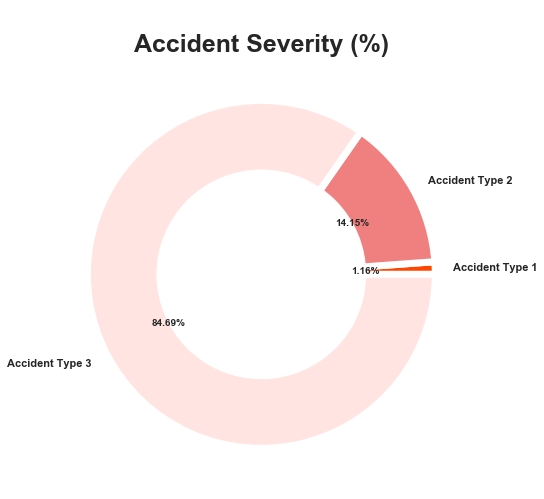

In [37]:
# assign the data
type_1   = eda_df.Accident_Severity.value_counts()['1']
type_2 = eda_df.Accident_Severity.value_counts()['2']
type_3  = eda_df.Accident_Severity.value_counts()['3']

names = ['Accident Type 1','Accident Type 2', 'Accident Type 3']
size  = [type_1, type_2, type_3]

# create a pie chart
plt.pie(x=size, labels=names, colors=['orangered', 'lightcoral', 'mistyrose'], 
        autopct='%1.2f%%', pctdistance=0.6, textprops=dict(fontweight='bold'),
        wedgeprops={'linewidth':7, 'edgecolor':'white'})

# create circle for the center of the plot to make the pie look like a donut
circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(15,8)
fig.gca().add_artist(circle)
plt.title('\nAccident Severity (%)', fontsize=25, fontweight='bold')
plt.show()

### Correlation

Correlation is the measure of how two features are, well, correlated; just like the month-of-the-year is correlated with the average daily temperature, and the hour-of-the-day is correlated with the amount of light outdoors. Formalising this mathematically, the definition of correlation usually used is Pearson’s R for a data sample (which results in a value in the range [-1,1]):

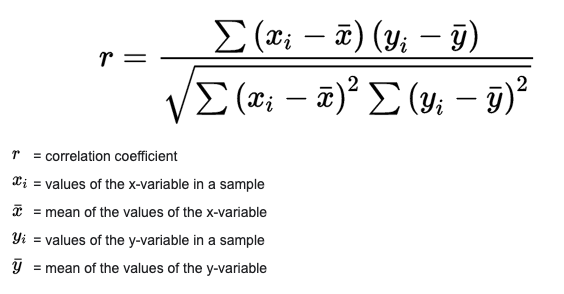

In [39]:
Image(filename='www/correlation.png') 

In [38]:
corr_df = copy.deepcopy(model_dataset)
del corr_df['Accident_Index']

target = corr_df['Did_Police_Officer_Attend_Scene_of_Accident']

float_columns = list(corr_df.select_dtypes(include=['int64','float64']).columns)
corr_df_f = corr_df[float_columns]

corr_df_1 = pd.concat([corr_df_f, target], axis = 1)

str_columns = list(corr_df.select_dtypes(include=['object']).columns)
corr_df_2 = corr_df[str_columns]

#### Integer Columns

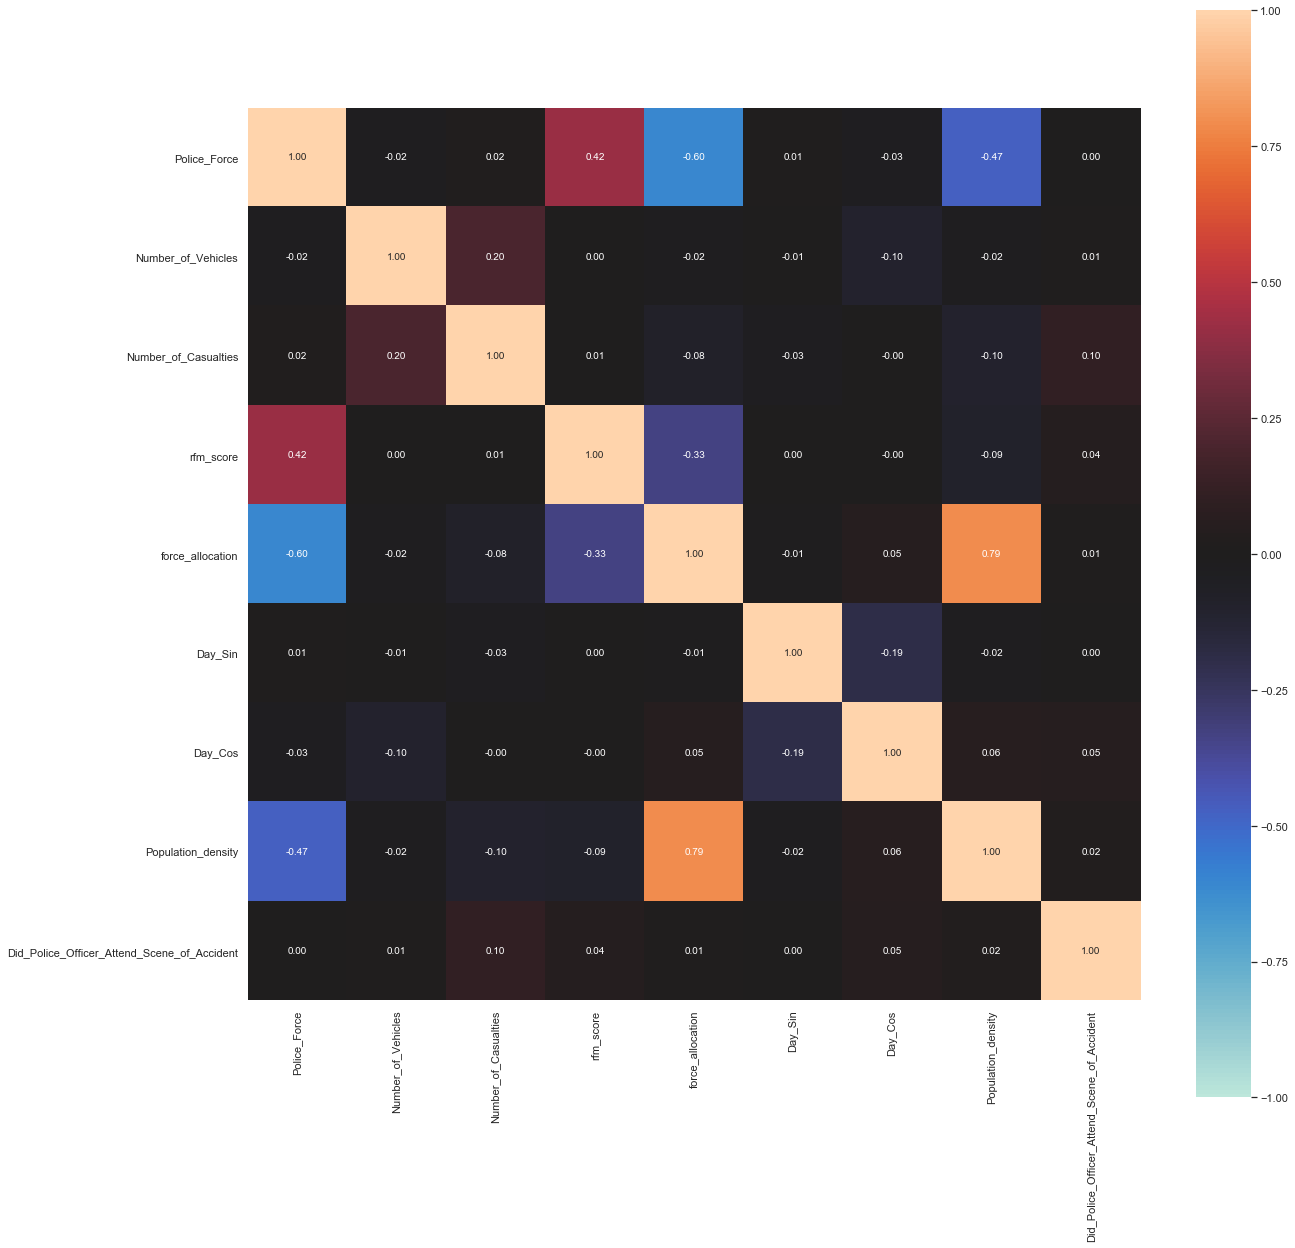

{'corr':                                              Police_Force  Number_of_Vehicles  \
 Police_Force                                     1.000000           -0.017986   
 Number_of_Vehicles                              -0.017986            1.000000   
 Number_of_Casualties                             0.021158            0.198947   
 rfm_score                                        0.415717            0.004069   
 force_allocation                                -0.602843           -0.017569   
 Day_Sin                                          0.014348           -0.007319   
 Day_Cos                                         -0.029518           -0.098598   
 Population_density                              -0.469190           -0.016478   
 Did_Police_Officer_Attend_Scene_of_Accident      0.002506            0.011883   
 
                                              Number_of_Casualties  rfm_score  \
 Police_Force                                             0.021158   0.415717   
 Number_

In [40]:
associations(corr_df_1, figsize=(20, 20))

But, as can be seen from the above equation, Pearson’s R isn’t defined when the data is categorical; let’s assume that x is a color feature — how do you subtract yellow from the average of colors? We need something else here.

#### Theil’s U

Theil’s U, also referred to as the Uncertainty Coefficient, is based on the conditional entropy between x and y — or in human language, given the value of x, how many possible states does y have, and how often do they occur. Just like Cramer’s V, the output value is on the range of [0,1], with the same interpretations as before — but unlike Cramer’s V, it is asymmetric, meaning U(x,y)≠U(y,x) (while V(x,y)=V(y,x), where V is Cramer’s V). Using Theil’s U in the simple case above will let us find out that knowing y means we know x, but not vice-versa.

#### String Columns

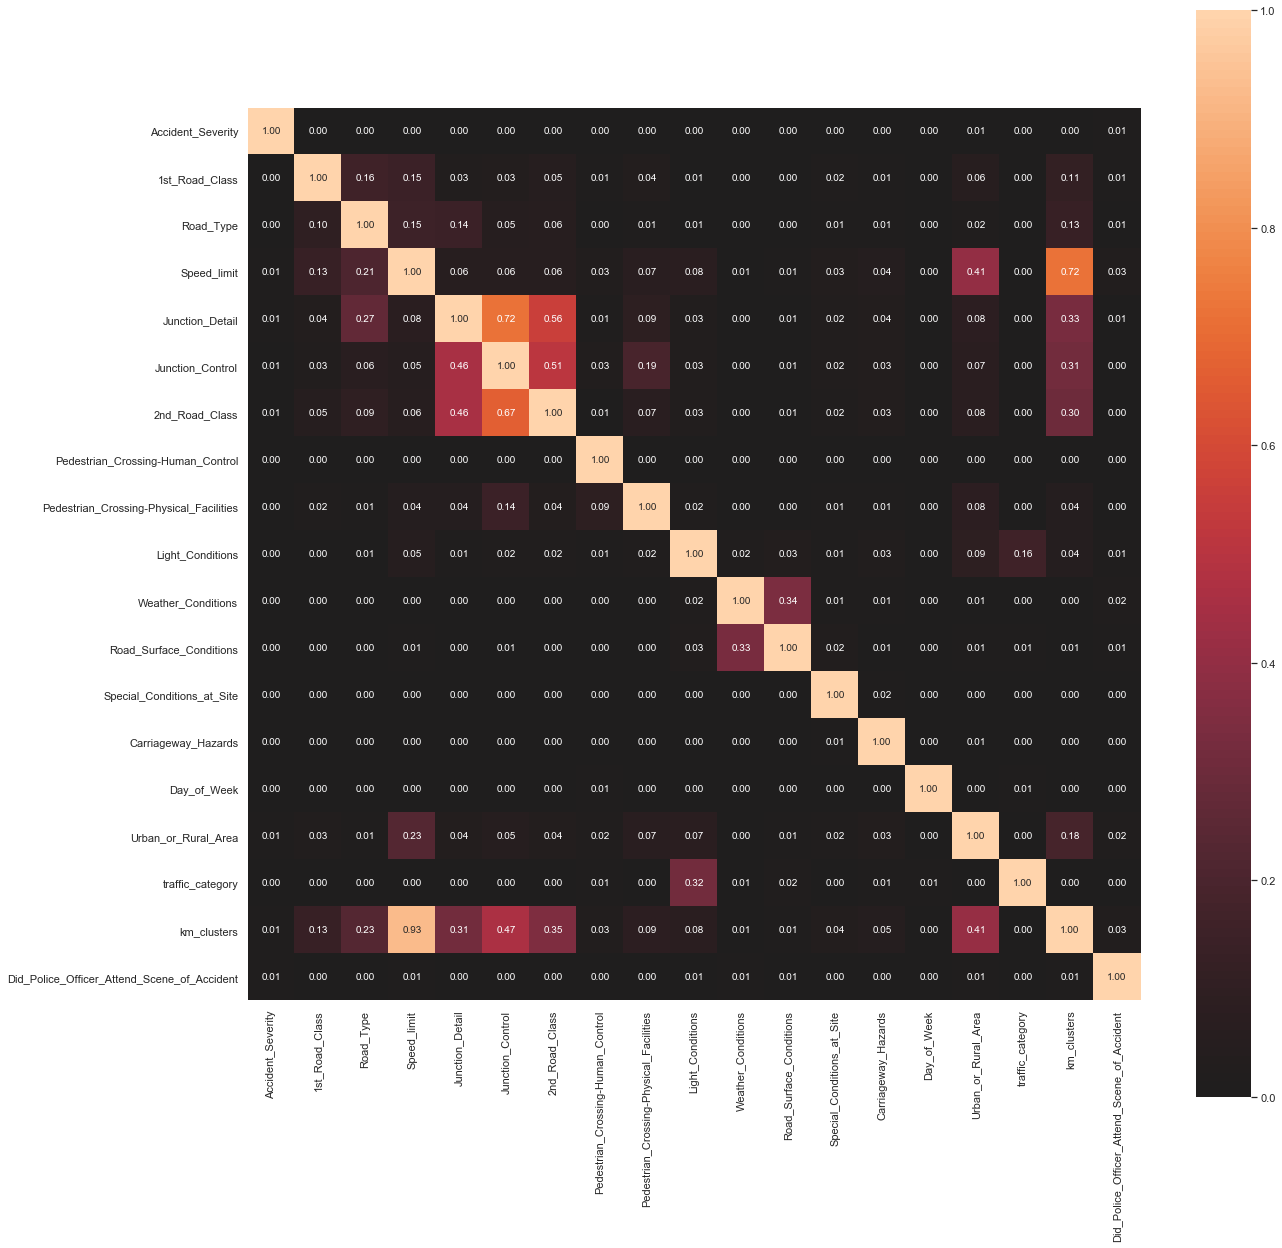

{'corr':                                              Accident_Severity  \
 Accident_Severity                                     1.000000   
 1st_Road_Class                                        0.002105   
 Road_Type                                             0.003623   
 Speed_limit                                           0.012058   
 Junction_Detail                                       0.007997   
 Junction_Control                                      0.006513   
 2nd_Road_Class                                        0.007391   
 Pedestrian_Crossing-Human_Control                     0.000168   
 Pedestrian_Crossing-Physical_Facilities               0.001415   
 Light_Conditions                                      0.004566   
 Weather_Conditions                                    0.001003   
 Road_Surface_Conditions                               0.000635   
 Special_Conditions_at_Site                            0.000653   
 Carriageway_Hazards                                  

In [41]:
associations(corr_df_2, nom_nom_assoc='theil', figsize=(20, 20))

### Balanced Data - Using SMOTE for Imbalanced Classification

#### Over-Sampling

SMOTE uses algorithm to generate new samples. Considering a sample x_i, a new sample x_{new} will be generated considering its k neareast-neighbors (corresponding to k_neighbors). Then, one of these nearest-neighbors x_{zi} is selected and a sample is generated as follows:

x_{new} = x_i + \lambda \times (x_{zi} - x_i)

The nearest neighbors search does not rely on the Euclidean distance. Indeed, the value difference metric (VDM) also implemented in the class ValueDifferenceMetric is used.

A new sample is generated where each feature value corresponds to the most common category seen in the neighbors samples belonging to the same class.

SMOTE-NC slightly change the way a new sample is generated by performing something specific for the categorical features. In fact, the categories of a new generated sample are decided by picking the most frequent category of the nearest neighbors present during the generation.

In [42]:
np_df = copy.deepcopy(model_dataset)
X, y = np_df.iloc[:,:-1], np_df.iloc[:,-1]

X = X.values
y = y.values

counter = Counter(y)
print(counter)

Counter({'1': 113350, '0': 25302})


In [43]:
model_dataset_o = copy.deepcopy(model_dataset)
X_df, y_df = model_dataset_o.iloc[:,1:-1], model_dataset_o.iloc[:,-1]
df_ids = model_dataset_o.iloc[:,0]

In [45]:
oversample = imblearn.over_sampling.SMOTENC(categorical_features=[8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],\
                                            random_state=0)

X_oresampled, y_oresampled = oversample.fit_resample(X_df, y_df)
print(sorted(Counter(y_oresampled).items()))

[('0', 113350), ('1', 113350)]


In [46]:
model_dataset_oversample = pd.concat([X_oresampled, y_oresampled], axis = 1)
model_dataset_oversample = sklearn.utils.shuffle(model_dataset_oversample)

#### Under-Sampling

RandomUnderSampler is a fast and easy way to balance the data by randomly selecting a subset of data for the targeted classes:

In [47]:
model_dataset_u = copy.deepcopy(model_dataset)
X_df, y_df = model_dataset_u.iloc[:,1:-1], model_dataset_u.iloc[:,-1]
df_ids = model_dataset_u.iloc[:,0]

In [48]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(random_state=0)
X_uresampled, y_uresampled = undersample.fit_resample(X_df, y_df)
print(sorted(Counter(y_uresampled).items()))

[('0', 25302), ('1', 25302)]


In [49]:
model_dataset_undersample = pd.concat([X_uresampled, y_uresampled], axis = 1)
model_dataset_undersample = sklearn.utils.shuffle(model_dataset_undersample)

## Model and Technique Selection

### XGBoost

XGBoost, which is short for “Extreme Gradient Boosting,” is a library that provides an efficient implementation of the gradient boosting algorithm.

The main benefit of the XGBoost implementation is computational efficiency and often better model performance. The basics you need to know about the GBM are that it is an ensemble method that works by training many individual learners, almost always decision trees. However, unlike in a random forest where the trees are trained in parallel, in a GBM, the trees are trained sequentially with each tree learning from the mistakes of the previous ones. The hundreds or thousands of weak learners are combined to make a single strong ensemble learner with the contributions of each individual learned during training using Gradient Descent (the weights of the individual trees would therefore be a model parameter).

In [50]:
import xgboost as xgb
print(xgb.__version__)

1.1.0


### Random Forest

The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.
- Pick N random records from the dataset.
- Build a decision tree based on these N records.
- Choose the number of trees you want in your algorithm and repeat steps 1 and 2.
- In case of a regression problem, for a new record, each tree in the forest predicts a value for Y (output). The final value can be calculated by taking the average of all the values predicted by all the trees in the forest.

In [51]:
from sklearn.ensemble import RandomForestClassifier

### SVM

SVM or Support Vector Machine is a linear model for classification and regression problems. It can solve linear and non-linear problems and work well for many practical problems. The idea of SVM is simple: The algorithm creates a line or a hyperplane which separates the data into classes.

In [52]:
from sklearn.svm import SVC

### Naive Bayes

In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong independence assumptions between the features.

In [54]:
from sklearn.naive_bayes import GaussianNB

### Logistic Regression

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. Mathematically, a binary logistic model has a dependent variable with two possible values and it is used to model the probability of a certain class or event such as pass/fail which is represented by an indicator variable, where the two values are labeled "0" and "1".

In [55]:
from sklearn.linear_model import LogisticRegression

### Neural Nets

Neural Network, also known as Artificial Neural Networks (ANNs) is a network or circuit of neurons, or in a modern sense, an artificial neural network, composed of artificial neurons or nodes. Thus a neural network is either a biological neural network, made up of biological neurons, or an artificial neural network, for solving artificial intelligence problems. — Wikipedia

Artificial neural networks (ANNs) are comprised of a node layers, containing an input layer, one or more hidden layers, and an output layer. Each node, or artificial neuron, connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network.

Neural networks rely on training data to learn and improve their accuracy over time. However, once these learning algorithms are fine-tuned for accuracy, they are powerful tools in computer science and artificial intelligence, allowing us to classify and cluster data at a high velocity. Tasks in speech recognition or image recognition can take minutes versus hours when compared to the manual identification by human experts. One of the most well-known neural networks is Google’s search algorithm.

In [56]:
import tensorflow as tf
from keras_tuner import RandomSearch

### Normal Dataset

In [57]:
model_dataset_ = copy.deepcopy(model_dataset)
del model_dataset_['Accident_Index']
model_dataset_ = sklearn.utils.shuffle(model_dataset_)

#### One-Hot Encoding

In [58]:
target = model_dataset_['Did_Police_Officer_Attend_Scene_of_Accident']
model_dataset_ = model_dataset_.drop(['Did_Police_Officer_Attend_Scene_of_Accident'], axis = 1)
columns_ = list(model_dataset_.select_dtypes(include=['int64','float64']).columns)
str_columns = list(model_dataset_.select_dtypes(include=['object']).columns)
db1 = model_dataset_[columns_]
db2 = pd.get_dummies(model_dataset_[str_columns])
model_dataset_main_ = pd.concat([db1, db2, target], axis = 1)

In [59]:
n = len(model_dataset_main_)
train_df = model_dataset_main_[0:int(n*0.9)]
test_df = model_dataset_main_[int(n*0.9):]
X_train_base, y_train_base = train_df.iloc[:,:-1], train_df.iloc[:,-1]
X_test_base, y_test_base = test_df.iloc[:,:-1], test_df.iloc[:,-1]

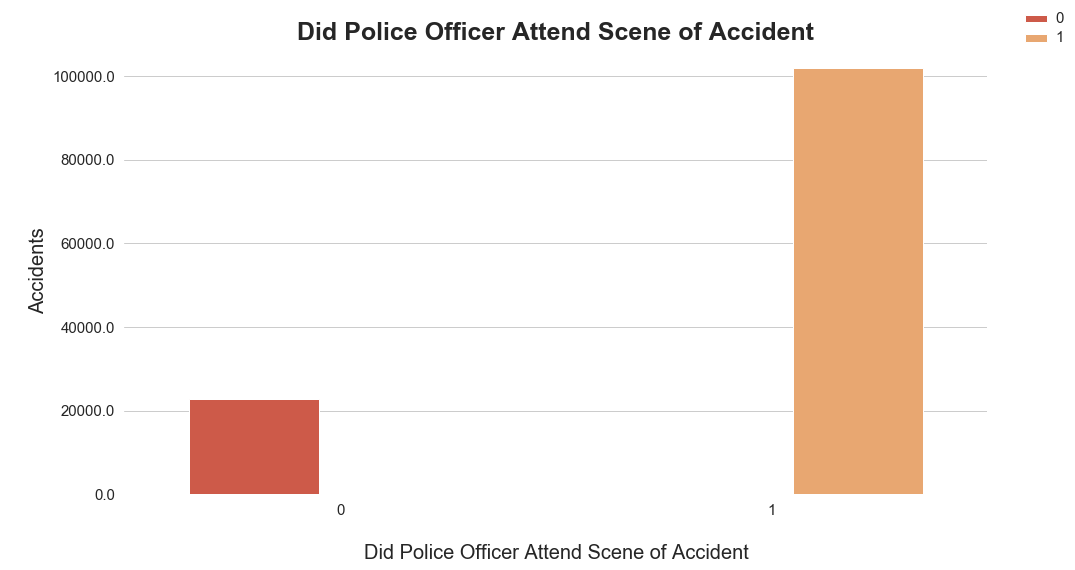

In [60]:
f, ax = plt.subplots(figsize=(15,8))

# Bar plot
sns.barplot(x='Did_Police_Officer_Attend_Scene_of_Accident', y='Accidents', 
            hue='Did_Police_Officer_Attend_Scene_of_Accident', 
            data= train_df.groupby(['Did_Police_Officer_Attend_Scene_of_Accident']).size()\
            .reset_index(name='Accidents'),
            palette = sns.color_palette('RdYlBu'))

# Set plot labels
ax.set_title('Did Police Officer Attend Scene of Accident', fontsize=25, fontweight='bold')
ax.set_xlabel('\nDid Police Officer Attend Scene of Accident', fontsize = 20)
ax.set_ylabel('\nAccidents', fontsize = 20)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), size = 15)
ax.set_yticklabels(ax.get_yticks(), size = 15)
ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize='15')

# Change bar width
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .30)

# Remove Spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

plt.tight_layout()
plt.show()


#### Baseline Models

#### XGBoost

In [61]:
xgb_base = xgb.XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb_base.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_base_xg_preds = xgb_base.predict(X_test_base)
y_base_xg_preds_proba = xgb_base.predict_proba(X_test_base)
auc_xgb_base = roc_auc_score(y_test_base, y_base_xg_preds_proba[:, 1])
prediction_end = time.perf_counter()
acc_xgb_base = (y_base_xg_preds == y_test_base).sum().astype(float) / len(y_base_xg_preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction AUC is: %3.2f" % (auc_xgb_base))
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb_base))
print("Time consumed for training: %4.3f seconds" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction AUC is: 0.77
XGBoost's prediction accuracy is: 82.15
Time consumed for training: 21.365 seconds
Time consumed for prediction: 0.10299 seconds


#### K-Fold CV

In [64]:
xgb_cv_base = xgb.XGBClassifier(n_estimators=50)
scores_base = cross_val_score(xgb_cv_base, X_train_base, y_train_base, cv=5, scoring = 'accuracy')
print("Scores:", scores_base)
print("Mean:", scores_base.mean())
print("Standard Deviation:", scores_base.std())

Scores: [0.82490584 0.82333614 0.82425772 0.82437793 0.82461834]
Mean: 0.8242991953693007
Standard Deviation: 0.0005301459697313277


In [65]:
# Feature Importance
xgb_importances = pd.DataFrame({
    'Feature': X_train_base.columns,
    'Importance': xgb_base.feature_importances_
})
xgb_importances = xgb_importances.sort_values(by='Importance', ascending=False)
xgb_importances = xgb_importances.set_index('Feature')
xgb_importances

,Importance
Feature,
Speed_limit_30,0.115376
Weather_Conditions_9,0.069412
Accident_Severity_3,0.049902
Speed_limit_20,0.040272
Junction_Detail_1,0.032361
...,...
Carriageway_Hazards_-1,0.000000
Special_Conditions_at_Site_7,0.000000
2nd_Road_Class_2,0.000000


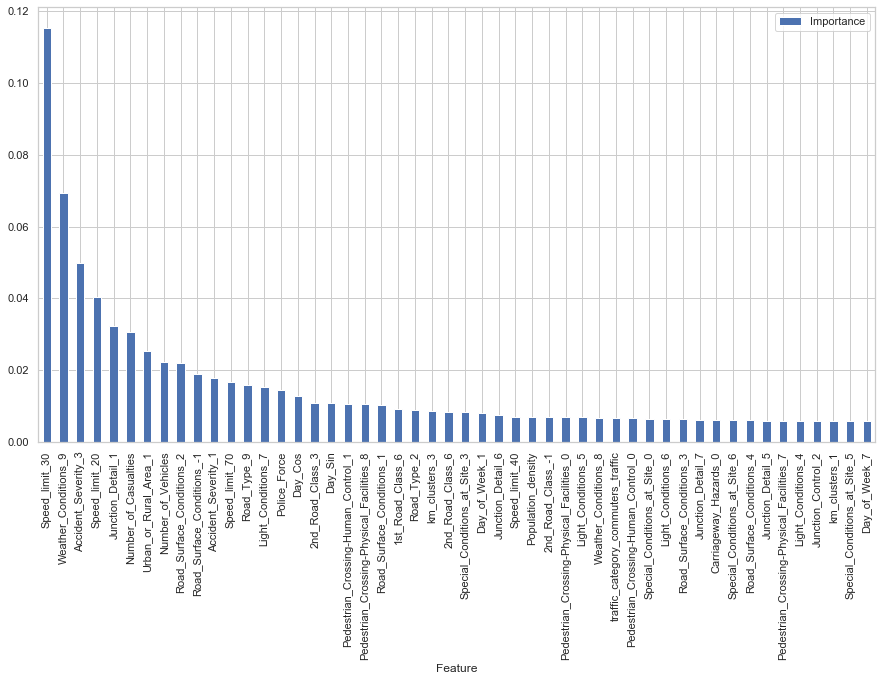

In [66]:
xgb_importances[:50].plot.bar(figsize=(15,8))

#### Random Forest

In [67]:
rfc_base = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc_base.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_preds_base_rfc = rfc_base.predict(X_test_base)
y_base_rfc_preds_proba = rfc_base.predict_proba(X_test_base)
auc_rfc_base = roc_auc_score(y_test_base, y_base_rfc_preds_proba[:, 1])
prediction_end = time.perf_counter()
acc_rfc_base = (y_preds_base_rfc == y_test_base).sum().astype(float) / len(y_preds_base_rfc)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction AUC is: %3.2f" % (auc_rfc_base))
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc_base))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction AUC is: 0.65
Scikit-Learn's Random Forest Classifier's prediction accuracy is: 79.04
Time consumed for training: 2.853 seconds
Time consumed for prediction: 0.15587 seconds


#### K-Fold CV

In [69]:
rfc_cv_base = RandomForestClassifier(n_estimators=50)
scores_base = cross_val_score(rfc_cv_base, X_train_base, y_train_base, cv=5, scoring = 'accuracy')
print("Scores:", scores_base)
print("Mean:", scores_base.mean())
print("Standard Deviation:", scores_base.std())

Scores: [0.81749339 0.81640422 0.81536242 0.81632408 0.81776656]
Mean: 0.8166701326811004
Standard Deviation: 0.0008695366927682429


In [70]:
# Feature Importance
rf_importances = pd.DataFrame({
    'Feature': X_train_base.columns,
    'Importance': rfc_base.feature_importances_
})
rf_importances = rf_importances.sort_values(by='Importance', ascending=False)
rf_importances = rf_importances.set_index('Feature')
rf_importances

,Importance
Feature,
Day_Cos,0.111924
Day_Sin,0.111038
Population_density,0.088759
rfm_score,0.070666
Police_Force,0.063432
...,...
Carriageway_Hazards_3,0.000180
2nd_Road_Class_2,0.000117
Special_Conditions_at_Site_2,0.000064


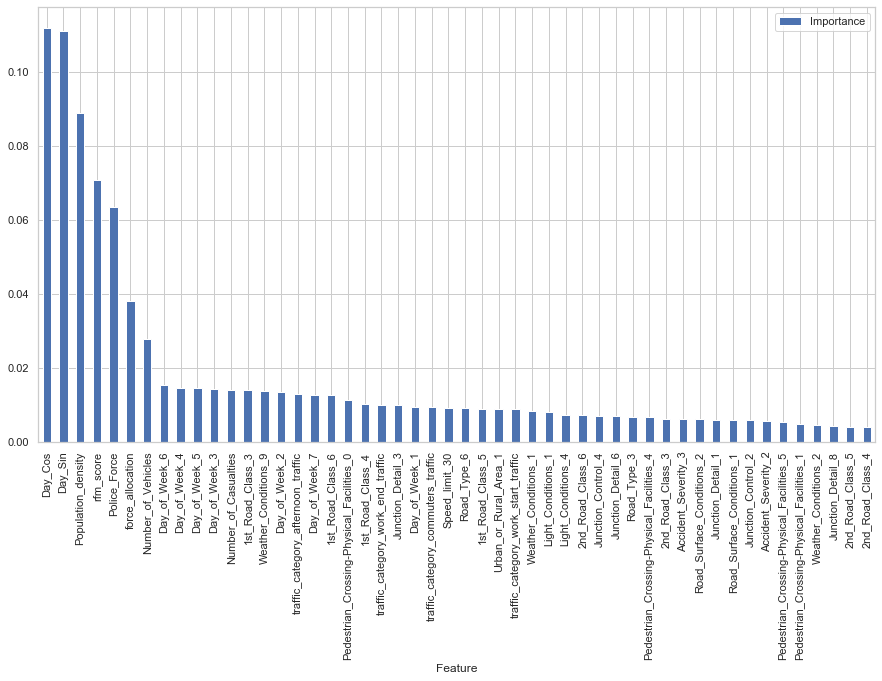

In [71]:
rf_importances[:50].plot.bar(figsize=(15,8))

#### SVM

In [ ]:
svc_base = SVC(probability=True)
training_start = time.perf_counter()
svc_base.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc_base.predict(X_test_base)
y_base_svc_preds_proba = svc_base.predict_proba(X_test_base)
auc_svc_base = roc_auc_score(y_test_base, y_base_svc_preds_proba[:, 1])
prediction_end = time.perf_counter()
acc_svc_base = (preds == y_test_base).sum().astype(float) / len(preds)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction AUC is: %3.2f" % (auc_svc_base))
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc_base))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

#### Naive Bayes

In [ ]:
scaler_gnb = MaxAbsScaler()
model_dataset_base_scaled = scaler_gnb.fit_transform(model_dataset_main_.drop('Did_Police_Officer_Attend_Scene_of_Accident', axis=1))
X_train_gnb_base, X_test_gnb_base, y_train_gnb_base, y_test_gnb_base = \
train_test_split(model_dataset_base_scaled, model_dataset_main_['Did_Police_Officer_Attend_Scene_of_Accident'], test_size=0.20)

In [ ]:
gnb_base_base = GaussianNB()
training_start = time.perf_counter()
gnb_base_base.fit(X_train_gnb_base, y_train_gnb_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gnb_base_base.predict(X_test_gnb_base)
prediction_end = time.perf_counter()
acc_gnb_base = (preds == y_test_gnb_base).sum().astype(float) / len(preds)*100
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb_base))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))

#### Logistic Regression

In [72]:
lr_base = LogisticRegression(random_state = 0)
training_start = time.perf_counter()
lr_base.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = lr_base.predict(X_test_base)
y_base_lr_preds_proba = lr_base.predict_proba(X_test_base)
auc_lr_base = roc_auc_score(y_test_base, y_base_lr_preds_proba[:, 1])
prediction_end = time.perf_counter()
acc_lr_base = (preds == y_test_base).sum().astype(float) / len(preds)*100
lr_train_time = training_end-training_start
lr_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Logistic Regression Classifier's prediction AUC is: %3.2f" % (auc_lr_base))
print("Scikit-Learn's Logistic Regression Classifier's prediction accuracy is: %3.2f" % (acc_lr_base))
print("Time consumed for training: %4.3f seconds" % (lr_train_time))
print("Time consumed for prediction: %6.5f seconds" % (lr_prediction_time))

Scikit-Learn's Logistic Regression Classifier's prediction AUC is: 0.68
Scikit-Learn's Logistic Regression Classifier's prediction accuracy is: 81.60
Time consumed for training: 2.772 seconds
Time consumed for prediction: 0.03097 seconds


#### K-Fold CV

In [73]:
lr_cv_base = LogisticRegression()
scores_base = cross_val_score(lr_cv_base, X_train_base, y_train_base, cv=5, scoring = 'accuracy')
print("Scores:", scores_base)
print("Mean:", scores_base.mean())
print("Standard Deviation:", scores_base.std())

Scores: [0.81905601 0.81860801 0.8202909  0.82025083 0.81936932]
Mean: 0.8195150133748921
Standard Deviation: 0.0006630233607366148


Feature: 0, Score: 0.00014
Feature: 1, Score: 0.03096
Feature: 2, Score: 0.58100
Feature: 3, Score: -0.00140
Feature: 4, Score: 0.21669
Feature: 5, Score: 0.00682
Feature: 6, Score: 0.12331
Feature: 7, Score: 0.00020
Feature: 8, Score: 0.09647
Feature: 9, Score: 0.45685
Feature: 10, Score: -0.34527
Feature: 11, Score: 0.11105
Feature: 12, Score: 0.01082
Feature: 13, Score: 0.11864
Feature: 14, Score: 0.06811
Feature: 15, Score: -0.01277
Feature: 16, Score: -0.08781
Feature: 17, Score: -0.06979
Feature: 18, Score: -0.04279
Feature: 19, Score: 0.20668
Feature: 20, Score: 0.16266
Feature: 21, Score: -0.01121
Feature: 22, Score: -0.03751
Feature: 23, Score: -0.06765
Feature: 24, Score: -0.24678
Feature: 25, Score: 0.04591
Feature: 26, Score: 0.08764
Feature: 27, Score: 0.18096
Feature: 28, Score: 0.20797
Feature: 29, Score: 0.00048
Feature: 30, Score: 0.11299
Feature: 31, Score: -0.22018
Feature: 32, Score: -0.00177
Feature: 33, Score: 0.09024
Feature: 34, Score: 0.03028
Feature: 35, Score

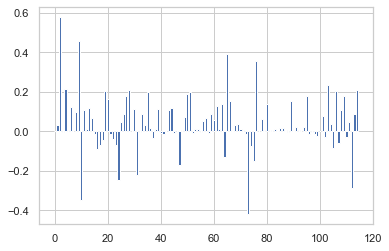

In [74]:
from matplotlib import pyplot
# Get importance
importance = lr_base.coef_[0]

# Summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# Plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#### Neural Nets

Feature Scaling is a critical step in using Neural Network models as large spread of values could lead into larger errors in gradient values causing weight values to change dramatically and making the learning process unstable.

In [75]:
train_df_ = copy.deepcopy(train_df)
test_df_ = copy.deepcopy(test_df)

object_columns = list(train_df_.select_dtypes(include=['object']).columns)
for object_column in object_columns:
    train_df_[object_column] = train_df_[object_column].astype('int64')
    
object_columns = list(test_df_.select_dtypes(include=['object']).columns)
for object_column in object_columns:
    test_df_[object_column] = test_df_[object_column].astype('int64')
    
train_df_['Did_Police_Officer_Attend_Scene_of_Accident'] = train_df_['Did_Police_Officer_Attend_Scene_of_Accident']\
.astype(str)
test_df_['Did_Police_Officer_Attend_Scene_of_Accident'] = test_df_['Did_Police_Officer_Attend_Scene_of_Accident']\
.astype(str)

In [76]:
# Feature Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

columns = train_df_.columns
col_names = train_df_.columns[:-1]
target =  train_df_.columns[-1]
train_features = train_df_[columns]
test_features = test_df_[columns]

ct = ColumnTransformer([
        (target, StandardScaler(), col_names)], remainder='passthrough')

train_df_nn = pd.DataFrame(ct.fit_transform(train_features),
                        columns=columns)

test_df_nn = pd.DataFrame(ct.fit_transform(test_features),
                        columns=columns)

X_train_base_nn, y_train_base_nn = train_df_nn.iloc[:,:-1], train_df_nn.iloc[:,-1]
X_test_base_nn, y_test_base_nn = test_df_nn.iloc[:,:-1], test_df_nn.iloc[:,-1]

In [77]:
MAX_EPOCHS = 100

def compile_and_fit(model, X_trn, y_trn, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
                                                     monitor='mean_absolute_error',
                                                     patience=patience,
                                                     mode='min')
    
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['AUC', 'mean_absolute_error', 'accuracy'])

    history = model.fit(np.asarray(X_trn).astype(np.int), np.asarray(y_trn).astype(np.int), 
                        epochs=MAX_EPOCHS, batch_size=32, callbacks=[early_stopping])
    return history

In [78]:
model_base = tf.keras.Sequential([
    tf.keras.layers.Dense(units=48, input_dim=len(X_train_base_nn.columns), activation='relu'),
    tf.keras.layers.Dense(units=24, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

model_history_base_1 = compile_and_fit(model_base, X_trn=X_train_base_nn, y_trn=y_train_base_nn)

Epoch 1/100
3900/3900 [==============================] - 4s 918us/step - loss: 0.4607 - auc: 0.6656 - mean_absolute_error: 0.2906 - accuracy: 0.8036
Epoch 2/100
3900/3900 [==============================] - 4s 981us/step - loss: 0.4328 - auc: 0.7065 - mean_absolute_error: 0.2729 - accuracy: 0.8216
Epoch 3/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.4283 - auc: 0.7164 - mean_absolute_error: 0.2702 - accuracy: 0.8218
Epoch 4/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.4233 - auc: 0.7232 - mean_absolute_error: 0.2671 - accuracy: 0.8238: 1s - loss: 0.4232 - auc: 0.7
Epoch 5/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.4216 - auc: 0.7296 - mean_absolute_error: 0.2663 - accuracy: 0.8228: 2s - loss: 0.4225 - auc: 0.7 - ETA: 1s - loss: 0.4212 - auc: 0.7319 - mean_a - ETA: 0s - loss: 0.4215 - auc: 0.7302 - mean_absolute_er
Epoch 6/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.4192 - auc: 0.73

3900/3900 [==============================] - 4s 1ms/step - loss: 0.3927 - auc: 0.7782 - mean_absolute_error: 0.2465 - accuracy: 0.8336
Epoch 51/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.3914 - auc: 0.7789 - mean_absolute_error: 0.2458 - accuracy: 0.8345
Epoch 52/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.3891 - auc: 0.7798 - mean_absolute_error: 0.2441 - accuracy: 0.8362: 3s - loss: 0.3857 - auc: 0.7826 - mean_absolute_error: 0.2431 - accura - ETA:  - ETA: 1s - loss: 0.3886 - auc: 0.7806 - mean_a
Epoch 53/100
3900/3900 [==============================] - 4s 974us/step - loss: 0.3874 - auc: 0.7820 - mean_absolute_error: 0.2426 - accuracy: 0.8365
Epoch 54/100
3900/3900 [==============================] - 4s 986us/step - loss: 0.3868 - auc: 0.7819 - mean_absolute_error: 0.2426 - accuracy: 0.8371
Epoch 55/100
3900/3900 [==============================] - 4s 997us/step - loss: 0.3892 - auc: 0.7838 - mean_absolute_error: 0.2444 - accuracy

In [79]:
loss_nn_base, auc_nn_base, mae_nn_base, acc_nn_base = model_base.evaluate(np.asarray(X_test_base_nn).astype(np.int),\
                                                                          np.asarray(y_test_base_nn).astype(np.int))
print('Test AUC:', auc_nn_base)
print('Test Accuracy:', acc_nn_base)
print('Mean Absolute Error:', mae_nn_base)
print('Test Loss:', acc_nn_base)

434/434 [==============================] - 1s 847us/step - loss: 0.4758 - auc: 0.6834 - mean_absolute_error: 0.2743 - accuracy: 0.80790s - loss: 0.4774 - auc: 0.6804 - mean_absolute_error: 0.2754 - accuracy: 
Test AUC: 0.6834020018577576
Test Accuracy: 0.807875394821167
Mean Absolute Error: 0.2742960453033447
Test Loss: 0.807875394821167


### Oversampled Dataset

#### One-Hot Encoding

In [80]:
target = model_dataset_oversample['Did_Police_Officer_Attend_Scene_of_Accident']
model_dataset_oversample = model_dataset_oversample.drop(['Did_Police_Officer_Attend_Scene_of_Accident'], axis = 1)
columns_ = list(model_dataset_oversample.select_dtypes(include=['int64','float64']).columns)
str_columns = list(model_dataset_oversample.select_dtypes(include=['object']).columns)
db1 = model_dataset_oversample[columns_]
db2 = pd.get_dummies(model_dataset_oversample[str_columns])
model_dataset_oversample_ = pd.concat([db1, db2, target], axis = 1)

In [81]:
n = len(model_dataset_oversample_)
train_df = model_dataset_oversample_[0:int(n*0.9)]
test_df = model_dataset_oversample_[int(n*0.9):]
X_train_oversample, y_train_oversample = train_df.iloc[:,:-1], train_df.iloc[:,-1]
X_test_oversample, y_test_oversample = test_df.iloc[:,:-1], test_df.iloc[:,-1]

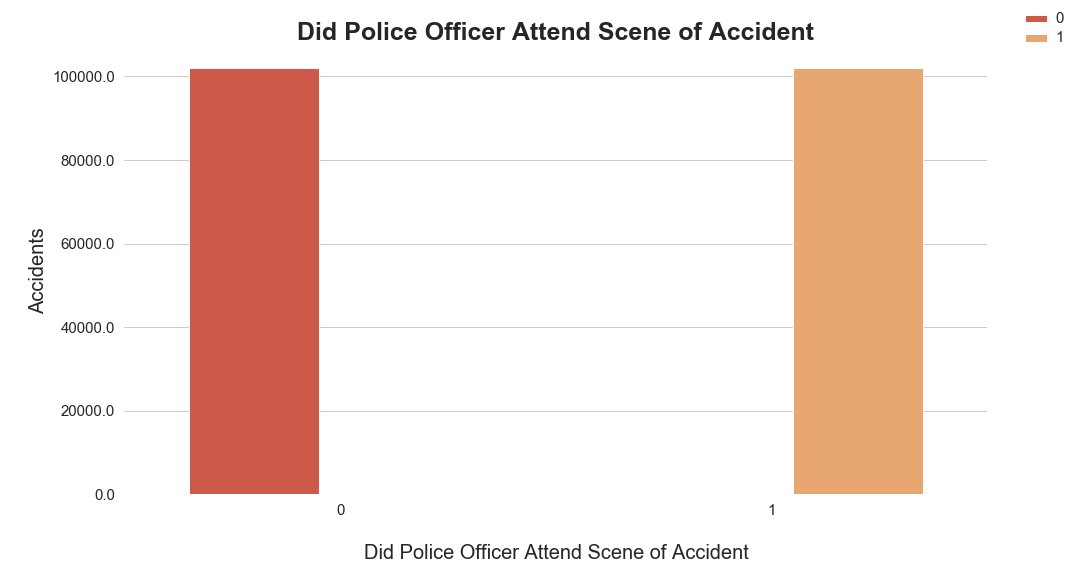

In [82]:
f, ax = plt.subplots(figsize=(15,8))

# Bar plot
sns.barplot(x='Did_Police_Officer_Attend_Scene_of_Accident', y='Accidents', 
            hue='Did_Police_Officer_Attend_Scene_of_Accident', 
            data= train_df.groupby(['Did_Police_Officer_Attend_Scene_of_Accident']).size()\
            .reset_index(name='Accidents'),
            palette = sns.color_palette('RdYlBu'))

# Set plot labels
ax.set_title('Did Police Officer Attend Scene of Accident', fontsize=25, fontweight='bold')
ax.set_xlabel('\nDid Police Officer Attend Scene of Accident', fontsize = 20)
ax.set_ylabel('\nAccidents', fontsize = 20)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), size = 15)
ax.set_yticklabels(ax.get_yticks(), size = 15)
ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize='15')

# Change bar width
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .30)

# Remove Spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

plt.tight_layout()
plt.show()


#### Baseline Models

#### XGBoost

In [84]:
xgb_oversample = xgb.XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb_oversample.fit(X_train_oversample, y_train_oversample)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_oversample_xg_preds = xgb_oversample.predict(X_test_oversample)
y_oversample_xg_preds_proba = xgb_oversample.predict_proba(X_test_oversample)
auc_xgb_oversample = roc_auc_score(y_test_oversample, y_oversample_xg_preds_proba[:, 1])
prediction_end = time.perf_counter()
acc_xgb_oversample = (y_oversample_xg_preds == y_test_oversample).sum().astype(float) / len(y_oversample_xg_preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction AUC is: %3.2f" % (auc_xgb_oversample))
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb_oversample))
print("Time consumed for training: %4.3f seconds" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction AUC is: 0.91
XGBoost's prediction accuracy is: 82.66
Time consumed for training: 36.463 seconds
Time consumed for prediction: 0.20962 seconds


#### K-Fold CV

In [85]:
xgb_cv_oversample = xgb.XGBClassifier(n_estimators=50)
scores_oversample = cross_val_score(xgb_cv_oversample, X_train_oversample, y_train_oversample, cv=5, scoring = 'accuracy')
print("Scores:", scores_oversample)
print("Mean:", scores_oversample.mean())
print("Standard Deviation:", scores_oversample.std())

Scores: [0.80755281 0.80983189 0.80681762 0.80978288 0.81130226]
Mean: 0.809057491545361
Standard Deviation: 0.001639873170394487


In [86]:
# Feature Importance
xgb_importances = pd.DataFrame({
    'Feature': X_train_oversample.columns,
    'Importance': xgb_oversample.feature_importances_
})
xgb_importances = xgb_importances.sort_values(by='Importance', ascending=False)
xgb_importances = xgb_importances.set_index('Feature')
xgb_importances

,Importance
Feature,
Accident_Severity_3,0.155743
Speed_limit_30,0.116264
Road_Surface_Conditions_1,0.064555
traffic_category_night_traffic,0.035359
Pedestrian_Crossing-Physical_Facilities_0,0.035202
...,...
Special_Conditions_at_Site_6,0.000000
Special_Conditions_at_Site_7,0.000000
Carriageway_Hazards_-1,0.000000


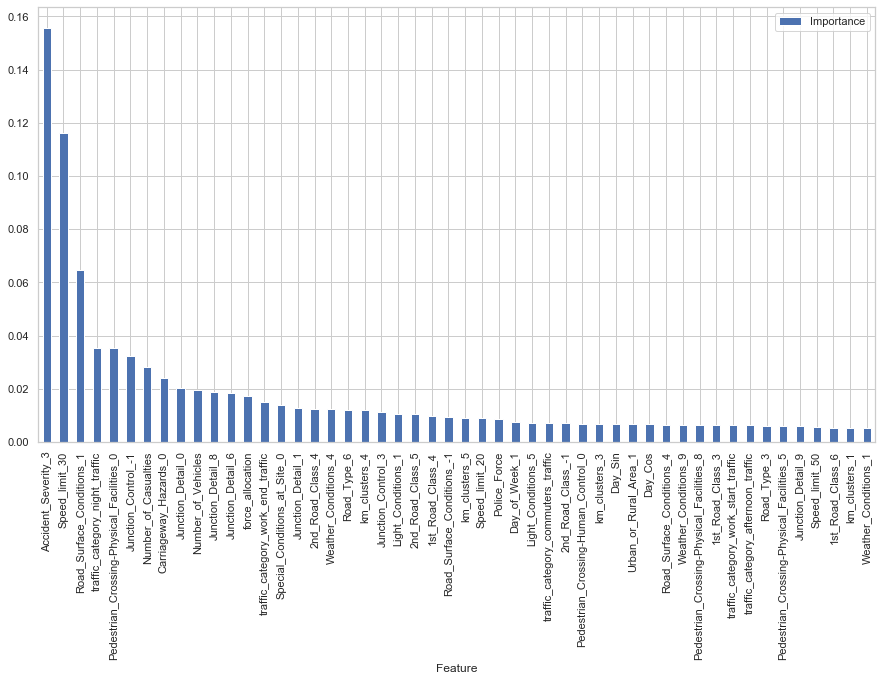

In [87]:
xgb_importances[:50].plot.bar(figsize=(15,8))

#### Random Forest

In [88]:
rfc_oversample = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc_oversample.fit(X_train_oversample, y_train_oversample)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_preds_oversample_rfc = rfc_oversample.predict(X_test_oversample)
y_oversample_rfc_preds_proba = rfc_oversample.predict_proba(X_test_oversample)
auc_rfc_oversample = roc_auc_score(y_test_oversample, y_oversample_rfc_preds_proba[:, 1])
prediction_end = time.perf_counter()
acc_rfc_oversample = (y_preds_oversample_rfc == y_test_oversample).sum().astype(float) / len(y_preds_oversample_rfc)\
*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction AUC is: %3.2f" % (auc_rfc_oversample))
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc_oversample))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction AUC is: 0.90
Scikit-Learn's Random Forest Classifier's prediction accuracy is: 82.50
Time consumed for training: 5.357 seconds
Time consumed for prediction: 0.23088 seconds


#### K-Fold CV

In [89]:
rfc_cv_oversample = RandomForestClassifier(n_estimators=50)
scores_oversample = cross_val_score(rfc_cv_oversample, X_train_oversample, y_train_oversample, cv=10, scoring = 'accuracy')
print("Scores:", scores_oversample)
print("Mean:", scores_oversample.mean())
print("Standard Deviation:", scores_oversample.std())

Scores: [0.8403176  0.84355242 0.84119982 0.84134686 0.84418958 0.8450718
 0.84203303 0.84384649 0.84458168 0.84139587]
Mean: 0.84275351663971
Standard Deviation: 0.0015906090804788406


In [90]:
# Feature Importance
rf_importances = pd.DataFrame({
    'Feature': X_train_oversample.columns,
    'Importance': rfc_oversample.feature_importances_
})
rf_importances = rf_importances.sort_values(by='Importance', ascending=False)
rf_importances = rf_importances.set_index('Feature')
rf_importances

,Importance
Feature,
Day_Sin,0.088235
Day_Cos,0.087082
Population_density,0.079067
rfm_score,0.061775
Police_Force,0.059306
...,...
2nd_Road_Class_2,0.000064
Road_Surface_Conditions_5,0.000061
Special_Conditions_at_Site_2,0.000015


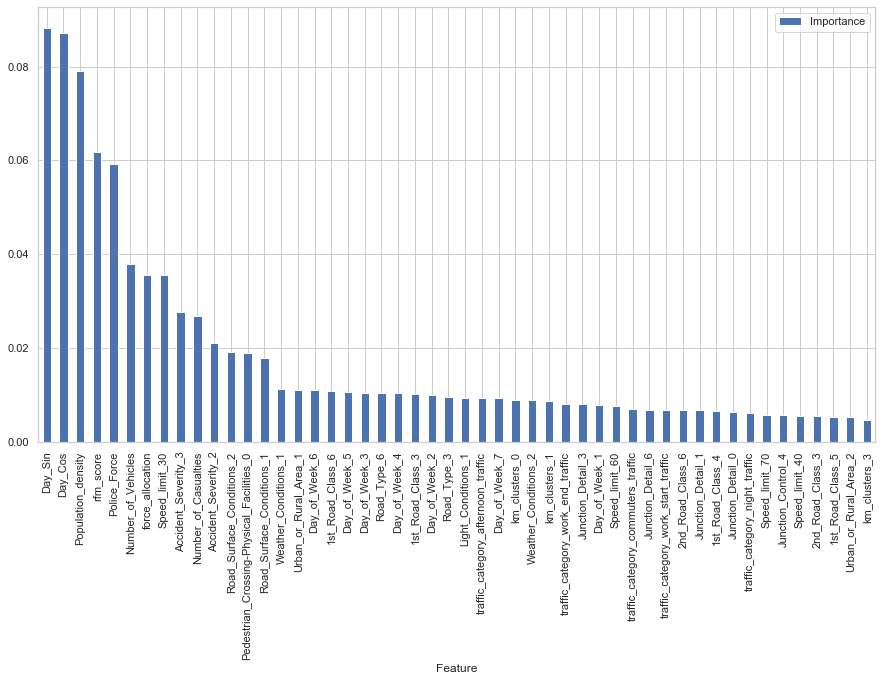

In [91]:
rf_importances[:50].plot.bar(figsize=(15,8))

#### SVM

In [ ]:
svc_oversample = SVC(probability=True)
training_start = time.perf_counter()
svc_oversample.fit(X_train_oversample, y_train_oversample)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc_oversample.predict(X_test_oversample)
y_oversample_svc_preds_proba = svc_oversample.predict_proba(X_test_oversample)
auc_svc_oversample = roc_auc_score(y_test_oversample, y_oversample_svc_preds_proba[:, 1])
prediction_end = time.perf_counter()
acc_svc_oversample = (preds == y_test_oversample).sum().astype(float) / len(preds)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction AUC is: %3.2f" % (auc_svc_oversample))
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc_oversample))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

#### Logistic Regression

In [92]:
lr_oversample = LogisticRegression(random_state = 0)
training_start = time.perf_counter()
lr_oversample.fit(X_train_oversample, y_train_oversample)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = lr_oversample.predict(X_test_oversample)
y_oversample_lr_preds_proba = lr_oversample.predict_proba(X_test_oversample)
auc_lr_oversample = roc_auc_score(y_test_oversample, y_oversample_lr_preds_proba[:, 1])
prediction_end = time.perf_counter()
acc_lr_oversample = (preds == y_test_oversample).sum().astype(float) / len(preds)*100
lr_train_time = training_end-training_start
lr_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Logistic Regression Classifier's prediction AUC is: %3.2f" % (auc_lr_oversample))
print("Scikit-Learn's Logistic Regression Classifier's prediction accuracy is: %3.2f" % (acc_lr_oversample))
print("Time consumed for training: %4.3f seconds" % (lr_train_time))
print("Time consumed for prediction: %6.5f seconds" % (lr_prediction_time))

Scikit-Learn's Logistic Regression Classifier's prediction AUC is: 0.80
Scikit-Learn's Logistic Regression Classifier's prediction accuracy is: 72.43
Time consumed for training: 4.557 seconds
Time consumed for prediction: 0.05107 seconds


#### K-Fold CV

In [93]:
lr_cv_oversample = LogisticRegression()
scores_oversample = cross_val_score(lr_cv_oversample, X_train_oversample, y_train_oversample, cv=5, scoring = 'accuracy')
print("Scores:", scores_oversample)
print("Mean:", scores_oversample.mean())
print("Standard Deviation:", scores_oversample.std())

Scores: [0.72834877 0.72550605 0.73339705 0.7335931  0.7367544 ]
Mean: 0.7315198745282557
Standard Deviation: 0.004035944235662725


#### Neural Nets

In [94]:
# Feature Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

columns = train_df_.columns
col_names = train_df_.columns[:-1]
target =  train_df_.columns[-1]
train_features = train_df_[columns]
test_features = test_df_[columns]

ct = ColumnTransformer([
        (target, StandardScaler(), col_names)], remainder='passthrough')

train_df_nn = pd.DataFrame(ct.fit_transform(train_features),
                        columns=columns)

test_df_nn = pd.DataFrame(ct.fit_transform(test_features),
                        columns=columns)

X_train_oversample_nn, y_train_oversample_nn = train_df_nn.iloc[:,:-1], train_df_nn.iloc[:,-1]
X_test_oversample_nn, y_test_oversample_nn = test_df_nn.iloc[:,:-1], test_df_nn.iloc[:,-1]

In [95]:
model_oversample = tf.keras.Sequential([
    tf.keras.layers.Dense(units=48, input_dim=len(X_train_oversample_nn.columns), activation='relu'),
    tf.keras.layers.Dense(units=24, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

model_history_oversample_1 = compile_and_fit(model_oversample, X_trn=X_train_oversample_nn, \
                                             y_trn=y_train_oversample_nn)

Epoch 1/100
3900/3900 [==============================] - 4s 990us/step - loss: 0.4494 - auc: 0.6717 - mean_absolute_error: 0.2831 - accuracy: 0.81600s - loss: 0.4518 - auc: 0.6674 - mean_absolute_error: 0.2847 - ac - ETA: 0s - loss: 0.4507 - auc: 0.6694 - mean_absolute_error: 0.284
Epoch 2/100
3900/3900 [==============================] - 4s 989us/step - loss: 0.4314 - auc: 0.7087 - mean_absolute_error: 0.2720 - accuracy: 0.8214
Epoch 3/100
3900/3900 [==============================] - 4s 991us/step - loss: 0.4267 - auc: 0.7180 - mean_absolute_error: 0.2690 - accuracy: 0.82230s - loss: 0.4267 - auc: 0.7180 - mean_absolute_error: 0.2690 - accura
Epoch 4/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.4234 - auc: 0.7256 - mean_absolute_error: 0.2675 - accuracy: 0.8229
Epoch 5/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.4244 - auc: 0.7290 - mean_absolute_error: 0.2679 - accuracy: 0.8213
Epoch 6/100
3900/3900 [==============================] 

3900/3900 [==============================] - 4s 1ms/step - loss: 0.3909 - auc: 0.7812 - mean_absolute_error: 0.2460 - accuracy: 0.8327
Epoch 49/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.3893 - auc: 0.7822 - mean_absolute_error: 0.2454 - accuracy: 0.8333: 1s - loss: 0.3877 - auc: 0.7839 - mean_absolute_error: 0.2446 - accuracy - ETA: 1s - loss: 0.3880 - auc:
Epoch 50/100
3900/3900 [==============================] - 4s 999us/step - loss: 0.3898 - auc: 0.7830 - mean_absolute_error: 0.2453 - accuracy: 0.8330
Epoch 51/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.3926 - auc: 0.7794 - mean_absolute_error: 0.2475 - accuracy: 0.8319
Epoch 52/100
3900/3900 [==============================] - 4s 998us/step - loss: 0.3898 - auc: 0.7831 - mean_absolute_error: 0.2460 - accuracy: 0.8326
Epoch 53/100
3900/3900 [==============================] - 4s 992us/step - loss: 0.3918 - auc: 0.7820 - mean_absolute_error: 0.2471 - accuracy: 0.8324
Epoch 54/100


In [96]:
loss_nn_oversample, auc_nn_oversample, mae_nn_oversample, acc_nn_oversample = model_oversample.evaluate(np.asarray(X_test_oversample_nn).astype(np.int),\
                                                                          np.asarray(y_test_oversample_nn).astype(np.int))
print('Test AUC:', auc_nn_oversample)
print('Test Accuracy:', acc_nn_oversample)
print('Mean Absolute Error:', mae_nn_oversample)
print('Test Loss:', acc_nn_oversample)

434/434 [==============================] - 1s 832us/step - loss: 0.4729 - auc: 0.6874 - mean_absolute_error: 0.2643 - accuracy: 0.8064
Test AUC: 0.6873785853385925
Test Accuracy: 0.8063609004020691
Mean Absolute Error: 0.264301598072052
Test Loss: 0.8063609004020691


### Undersampled Dataset

#### One-Hot Encoding

In [97]:
target = model_dataset_undersample['Did_Police_Officer_Attend_Scene_of_Accident']
model_dataset_undersample = model_dataset_undersample.drop(['Did_Police_Officer_Attend_Scene_of_Accident'], axis = 1)
columns_ = list(model_dataset_undersample.select_dtypes(include=['int64','float64']).columns)
str_columns = list(model_dataset_undersample.select_dtypes(include=['object']).columns)
db1 = model_dataset_undersample[columns_]
db2 = pd.get_dummies(model_dataset_undersample[str_columns])
model_dataset_undersample_ = pd.concat([db1, db2, target], axis = 1)

In [98]:
n = len(model_dataset_undersample_)
train_df = model_dataset_undersample_[0:int(n*0.9)]
test_df = model_dataset_undersample_[int(n*0.9):]
X_train_undersample, y_train_undersample = train_df.iloc[:,:-1], train_df.iloc[:,-1]
X_test_undersample, y_test_undersample = test_df.iloc[:,:-1], test_df.iloc[:,-1]

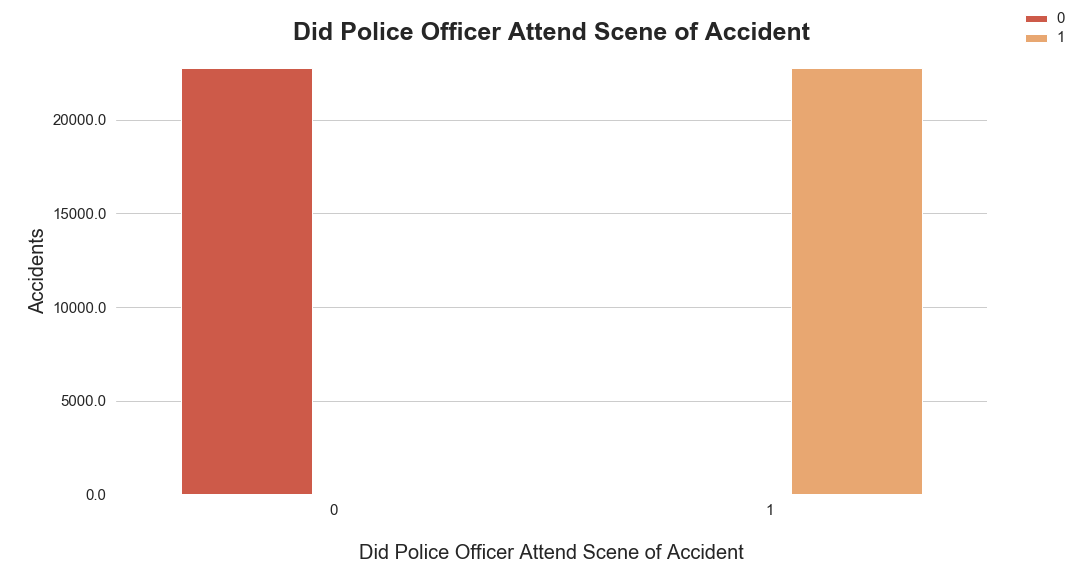

In [99]:
f, ax = plt.subplots(figsize=(15,8))

# Bar plot
sns.barplot(x='Did_Police_Officer_Attend_Scene_of_Accident', y='Accidents', 
            hue='Did_Police_Officer_Attend_Scene_of_Accident', 
            data= train_df.groupby(['Did_Police_Officer_Attend_Scene_of_Accident']).size()\
            .reset_index(name='Accidents'),
            palette = sns.color_palette('RdYlBu'))

# Set plot labels
ax.set_title('Did Police Officer Attend Scene of Accident', fontsize=25, fontweight='bold')
ax.set_xlabel('\nDid Police Officer Attend Scene of Accident', fontsize = 20)
ax.set_ylabel('\nAccidents', fontsize = 20)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), size = 15)
ax.set_yticklabels(ax.get_yticks(), size = 15)
ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize='15')

# Change bar width
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .30)

# Remove Spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

plt.tight_layout()
plt.show()

#### Baseline Models

#### XGBoost

In [100]:
xgb_undersample = xgb.XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb_undersample.fit(X_train_undersample, y_train_undersample)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_undersample_xg_preds = xgb_undersample.predict(X_test_undersample)
y_undersample_xg_preds_proba = xgb_undersample.predict_proba(X_test_undersample)
auc_xgb_undersample = roc_auc_score(y_test_undersample, y_undersample_xg_preds_proba[:, 1])
prediction_end = time.perf_counter()
acc_xgb_undersample = (y_undersample_xg_preds == y_test_undersample).sum().astype(float) / len(y_undersample_xg_preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction AUC is: %3.2f" % (auc_xgb_undersample))
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb_undersample))
print("Time consumed for training: %4.3f seconds" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction AUC is: 0.77
XGBoost's prediction accuracy is: 69.41
Time consumed for training: 7.984 seconds
Time consumed for prediction: 0.03969 seconds


#### K-Fold CV

In [101]:
xgb_cv_undersample = xgb.XGBClassifier(n_estimators=50)
scores_undersample = cross_val_score(xgb_cv_undersample, X_train_undersample, y_train_undersample, cv=5, scoring = 'accuracy')
print("Scores:", scores_undersample)
print("Mean:", scores_undersample.mean())
print("Standard Deviation:", scores_undersample.std())

Scores: [0.6878911  0.68152377 0.68382918 0.68763724 0.68401405]
Mean: 0.6849790679832157
Standard Deviation: 0.0024387864086628055


In [102]:
# Feature Importance
xgb_importances = pd.DataFrame({
    'Feature': X_train_undersample.columns,
    'Importance': xgb_undersample.feature_importances_
})
xgb_importances = xgb_importances.sort_values(by='Importance', ascending=False)
xgb_importances = xgb_importances.set_index('Feature')
xgb_importances

,Importance
Feature,
Speed_limit_30,0.113783
Weather_Conditions_9,0.080360
Accident_Severity_3,0.070698
Speed_limit_20,0.049121
Junction_Detail_1,0.031932
...,...
2nd_Road_Class_2,0.000000
Carriageway_Hazards_3,0.000000
Carriageway_Hazards_-1,0.000000


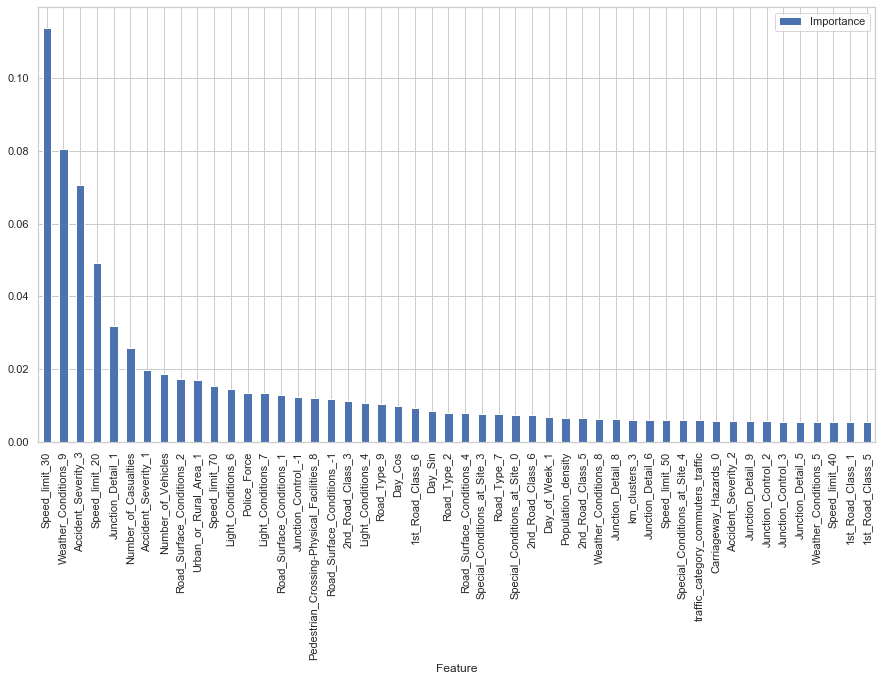

In [103]:
xgb_importances[:50].plot.bar(figsize=(15,8))

#### Random Forest

In [104]:
rfc_undersample = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc_undersample.fit(X_train_undersample, y_train_undersample)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_preds_undersample_rfc = rfc_undersample.predict(X_test_undersample)
y_undersample_rfc_preds_proba = rfc_undersample.predict_proba(X_test_undersample)
auc_rfc_undersample = roc_auc_score(y_test_undersample, y_undersample_rfc_preds_proba[:, 1])
prediction_end = time.perf_counter()
acc_rfc_undersample = (y_preds_undersample_rfc == y_test_undersample).sum().astype(float) / len(y_preds_undersample_rfc)\
*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction AUC is: %3.2f" % (auc_rfc_undersample))
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc_undersample))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction AUC is: 0.68
Scikit-Learn's Random Forest Classifier's prediction accuracy is: 62.58
Time consumed for training: 0.910 seconds
Time consumed for prediction: 0.04994 seconds


#### K-Fold CV

In [105]:
rfc_cv_undersample = RandomForestClassifier(n_estimators=50)
scores_undersample = cross_val_score(rfc_cv_undersample, X_train_undersample, y_train_undersample, cv=5, scoring = 'accuracy')
print("Scores:", scores_undersample)
print("Mean:", scores_undersample.mean())
print("Standard Deviation:", scores_undersample.std())

Scores: [0.64738171 0.64661324 0.64518608 0.6421827  0.64459816]
Mean: 0.6451923763498078
Standard Deviation: 0.001801296578184535


In [106]:
# Feature Importance
rf_importances = pd.DataFrame({
    'Feature': X_train_undersample.columns,
    'Importance': rfc_undersample.feature_importances_
})
rf_importances = rf_importances.sort_values(by='Importance', ascending=False)
rf_importances = rf_importances.set_index('Feature')
rf_importances

,Importance
Feature,
Day_Cos,0.097184
Day_Sin,0.095557
Population_density,0.082188
rfm_score,0.066977
Police_Force,0.065136
...,...
Special_Conditions_at_Site_3,0.000157
2nd_Road_Class_2,0.000121
Special_Conditions_at_Site_2,0.000047


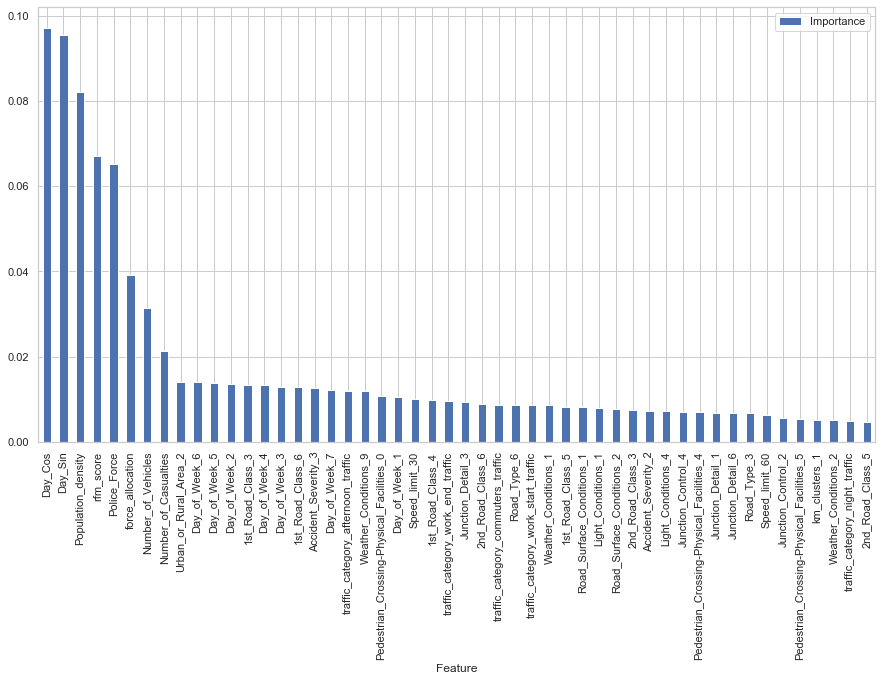

In [107]:
rf_importances[:50].plot.bar(figsize=(15,8))

#### SVM

In [ ]:
svc_undersample = SVC(probability=True)
training_start = time.perf_counter()
svc_undersample.fit(X_train_undersample, y_train_undersample)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc_undersample.predict(X_test_undersample)
y_undersample_svc_preds_proba = svc_undersample.predict_proba(X_test_undersample)
auc_svc_undersample = roc_auc_score(y_test_undersample, y_undersample_svc_preds_proba[:, 1])
prediction_end = time.perf_counter()
acc_svc_undersample = (preds == y_test_undersample).sum().astype(float) / len(preds)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction AUC is: %3.2f" % (auc_svc_undersample))
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc_undersample))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

#### Logistic Regression

In [108]:
lr_undersample = LogisticRegression(random_state = 0)
training_start = time.perf_counter()
lr_undersample.fit(X_train_undersample, y_train_undersample)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = lr_undersample.predict(X_test_undersample)
y_undersample_lr_preds_proba = lr_undersample.predict_proba(X_test_undersample)
auc_lr_undersample = roc_auc_score(y_test_undersample, y_undersample_lr_preds_proba[:, 1])
prediction_end = time.perf_counter()
acc_lr_undersample = (preds == y_test_undersample).sum().astype(float) / len(preds)*100
lr_train_time = training_end-training_start
lr_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Logistic Regression Classifier's prediction AUC is: %3.2f" % (auc_lr_undersample))
print("Scikit-Learn's Logistic Regression Classifier's prediction accuracy is: %3.2f" % (acc_lr_undersample))
print("Time consumed for training: %4.3f seconds" % (lr_train_time))
print("Time consumed for prediction: %6.5f seconds" % (lr_prediction_time))

Scikit-Learn's Logistic Regression Classifier's prediction AUC is: 0.69
Scikit-Learn's Logistic Regression Classifier's prediction accuracy is: 63.76
Time consumed for training: 1.036 seconds
Time consumed for prediction: 0.01378 seconds


#### K-Fold CV

In [109]:
lr_cv_undersample = LogisticRegression()
scores_undersample = cross_val_score(lr_cv_undersample, X_train_undersample, y_train_undersample, cv=5, scoring = 'accuracy')
print("Scores:", scores_undersample)
print("Mean:", scores_undersample.mean())
print("Standard Deviation:", scores_undersample.std())

Scores: [0.63717203 0.63837962 0.63958722 0.63548529 0.63548529]
Mean: 0.6372218897919708
Standard Deviation: 0.0016105405108199338


#### Neural Nets

In [110]:
# Feature Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

columns = train_df_.columns
col_names = train_df_.columns[:-1]
target =  train_df_.columns[-1]
train_features = train_df_[columns]
test_features = test_df_[columns]

ct = ColumnTransformer([
        (target, StandardScaler(), col_names)], remainder='passthrough')

train_df_nn = pd.DataFrame(ct.fit_transform(train_features),
                        columns=columns)

test_df_nn = pd.DataFrame(ct.fit_transform(test_features),
                        columns=columns)

X_train_undersample_nn, y_train_undersample_nn = train_df_nn.iloc[:,:-1], train_df_nn.iloc[:,-1]
X_test_undersample_nn, y_test_undersample_nn = test_df_nn.iloc[:,:-1], test_df_nn.iloc[:,-1]

In [111]:
model_undersample = tf.keras.Sequential([
    tf.keras.layers.Dense(units=48, input_dim=len(X_train_undersample_nn.columns), activation='relu'),
    tf.keras.layers.Dense(units=24, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

model_history_undersample_1 = compile_and_fit(model_undersample, X_trn=X_train_undersample_nn, \
                                             y_trn=y_train_undersample_nn)

Epoch 1/100
3900/3900 [==============================] - 4s 983us/step - loss: 0.4505 - auc: 0.6706 - mean_absolute_error: 0.2827 - accuracy: 0.81620s - loss: 0.4522 - auc: 0.6679 - mean_absolute_error: 0.283
Epoch 2/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.4279 - auc: 0.7101 - mean_absolute_error: 0.2694 - accuracy: 0.8237
Epoch 3/100
3900/3900 [==============================] - 4s 990us/step - loss: 0.4256 - auc: 0.7191 - mean_absolute_error: 0.2681 - accuracy: 0.8232
Epoch 4/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.4225 - auc: 0.7266 - mean_absolute_error: 0.2664 - accuracy: 0.8232
Epoch 5/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.4220 - auc: 0.7296 - mean_absolute_error: 0.2662 - accuracy: 0.8227: 3s - loss: 0.4 - ETA: 1s - loss: 0.4222 - au
Epoch 6/100
3900/3900 [==============================] - 4s 992us/step - loss: 0.4196 - auc: 0.7350 - mean_absolute_error: 0.2651 - accuracy: 0.8227
Epoch 

3900/3900 [==============================] - 4s 987us/step - loss: 0.3880 - auc: 0.7836 - mean_absolute_error: 0.2448 - accuracy: 0.8332
Epoch 49/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.3891 - auc: 0.7817 - mean_absolute_error: 0.2450 - accuracy: 0.8339
Epoch 50/100
3900/3900 [==============================] - 4s 980us/step - loss: 0.3909 - auc: 0.7824 - mean_absolute_error: 0.2466 - accuracy: 0.8326
Epoch 51/100
3900/3900 [==============================] - 4s 1ms/step - loss: 0.3877 - auc: 0.7839 - mean_absolute_error: 0.2447 - accuracy: 0.8337


In [112]:
loss_nn_undersample, auc_nn_undersample, mae_nn_undersample, acc_nn_undersample = model_undersample.evaluate(np.asarray(X_test_undersample_nn).astype(np.int),\
                                                                          np.asarray(y_test_undersample_nn).astype(np.int))
print('Test AUC:', auc_nn_undersample)
print('Test Accuracy:', acc_nn_undersample)
print('Mean Absolute Error:', mae_nn_undersample)
print('Test Loss:', acc_nn_undersample)

434/434 [==============================] - 1s 833us/step - loss: 0.4645 - auc: 0.6880 - mean_absolute_error: 0.2634 - accuracy: 0.8113
Test AUC: 0.6879650950431824
Test Accuracy: 0.8113370537757874
Mean Absolute Error: 0.2633829116821289
Test Loss: 0.8113370537757874


In [113]:
preds = model_undersample.predict(np.asarray(X_test_undersample_nn).astype(np.int))
y_undersample_nn_preds = [1 if n >= 0.5 else 0 for n in preds]
y_undersample_nn_preds = np.asarray(y_undersample_nn_preds, dtype=str)
acc_nn_undersample = (y_undersample_nn_preds == y_test_undersample_nn).sum().astype(float) / len(y_undersample_nn_preds)\
*100
print("Neural Net Classifier's prediction accuracy is: %3.2f" % (acc_nn_undersample))

Neural Net Classifier's prediction accuracy is: 81.13


### Evaluate Sampling Techniques and Models

#### AUC

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between police officer will attend the accident or will not attend the accident.

In [114]:
results = pd.DataFrame({
    'Model': ['XGBoost','XGBoost','XGBoost','Random Forest','Random Forest','Random Forest',
              'Neural Nets', 'Neural Nets', 'Neural Nets', 'Logistic Regression',
              'Logistic Regression','Logistic Regression'],
    'Technique': ['Normal','Oversample','Undersample','Normal','Oversample','Undersample',
                  'Normal','Oversample','Undersample','Normal','Oversample','Undersample'],
    'AUC': [auc_xgb_base, auc_xgb_oversample, auc_xgb_undersample, \
              auc_rfc_base, auc_rfc_oversample, auc_rfc_undersample, \
              auc_nn_base, auc_nn_oversample, auc_nn_undersample, \
              auc_lr_base, auc_lr_oversample, auc_lr_undersample]})
result_df = results.sort_values(by='AUC', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Technique,AUC
Model,,
XGBoost,Oversample,0.909927
Random Forest,Oversample,0.901425
Logistic Regression,Oversample,0.795662
XGBoost,Normal,0.770346
XGBoost,Undersample,0.765815
Logistic Regression,Undersample,0.693791
Neural Nets,Undersample,0.687965
Neural Nets,Oversample,0.687379
Neural Nets,Normal,0.683402


#### Confusion Matrix

A confusion matrix is a summary of prediction results on a classification problem.

The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.

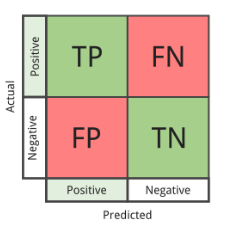

In [115]:
Image(filename='www/confusion.png')

Text(0.5, 1.0, 'Technique: Normal | Model: XGBoost')

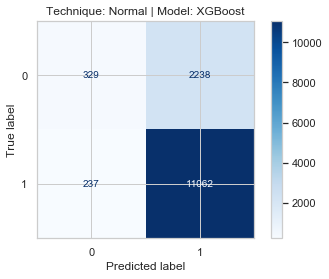

In [116]:
class_names = np.unique(y_test_base)
disp = plot_confusion_matrix(xgb_base, X_test_base, y_test_base,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Technique: Normal | Model: XGBoost")

Text(0.5, 1.0, 'Technique: Normal | Model: Random Forest')

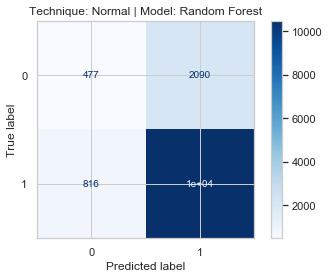

In [117]:
class_names = np.unique(y_test_base)
disp = plot_confusion_matrix(rfc_base, X_test_base, y_test_base,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Technique: Normal | Model: Random Forest")

Text(0.5, 1.0, 'Technique: Normal | Model: Logistic Regression')

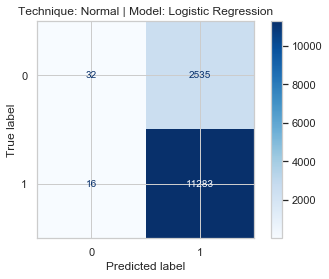

In [118]:
class_names = np.unique(y_test_base)
disp = plot_confusion_matrix(lr_base, X_test_base, y_test_base,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Technique: Normal | Model: Logistic Regression")

Text(0.5, 1.0, 'Technique: Oversample | Model: XGBoost')

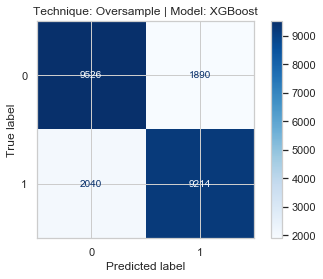

In [119]:
class_names = np.unique(y_test_oversample)
disp = plot_confusion_matrix(xgb_oversample, X_test_oversample, y_test_oversample,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Technique: Oversample | Model: XGBoost")

Text(0.5, 1.0, 'Technique: Oversample | Model: Random Forest')

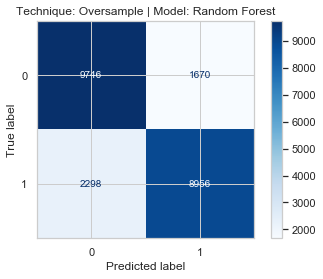

In [120]:
class_names = np.unique(y_test_oversample)
disp = plot_confusion_matrix(rfc_oversample, X_test_oversample, y_test_oversample,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Technique: Oversample | Model: Random Forest")

Text(0.5, 1.0, 'Technique: Oversample | Model: Logistic Regression')

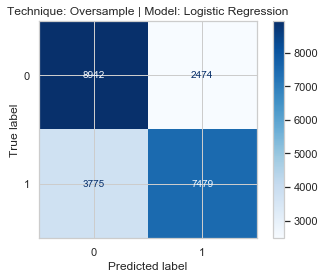

In [121]:
class_names = np.unique(y_test_oversample)
disp = plot_confusion_matrix(lr_oversample, X_test_oversample, y_test_oversample,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Technique: Oversample | Model: Logistic Regression")

Text(0.5, 1.0, 'Technique: Undersample | Model: XGBoost')

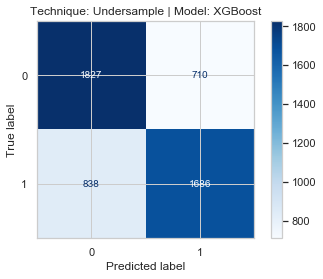

In [122]:
class_names = np.unique(y_test_undersample)
disp = plot_confusion_matrix(xgb_undersample, X_test_undersample, y_test_undersample,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Technique: Undersample | Model: XGBoost")

Text(0.5, 1.0, 'Technique: Undersample | Model: Random Forest')

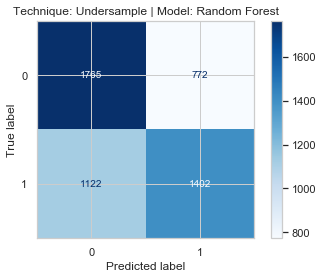

In [123]:
class_names = np.unique(y_test_undersample)
disp = plot_confusion_matrix(rfc_undersample, X_test_undersample, y_test_undersample,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Technique: Undersample | Model: Random Forest")

Text(0.5, 1.0, 'Technique: Undersample | Model: Logistic Regression')

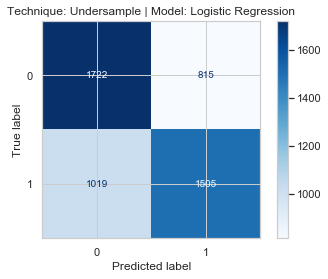

In [124]:
class_names = np.unique(y_test_undersample)
disp = plot_confusion_matrix(lr_undersample, X_test_undersample, y_test_undersample,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Technique: Undersample | Model: Logistic Regression")

#### F1-Score

One can combine precision and recall into one score, which is called the F-score. The F-score is computed with the harmonic mean of precision and recall. Note that it assigns much more weight to low values. As a result of that, the classifier will only get a high F-score, if both recall and precision are high. However, in some cases it could give you a biased result since it doesn’t include TN.

F1-Score = 2 x (Precision x Recall) / (Precision + Recall)

In [125]:
XGBoost_Normal_b = xgb_base.predict(X_test_base)
Random_Forest_Normal_b = rfc_base.predict(X_test_base)
Logistic_Regression_Normal_b = lr_base.predict(X_test_base)
preds = model_base.predict(np.asarray(X_test_base_nn).astype(np.int))
Neural_Nets_Normal_b = [1 if n >= 0.5 else 0 for n in preds]
Neural_Nets_Normal_b = np.asarray(Neural_Nets_Normal_b, dtype=str)

XGBoost_Oversample_b = xgb_oversample.predict(X_test_oversample)
Random_Forest_Oversample_b = rfc_oversample.predict(X_test_oversample)
Logistic_Regression_Oversample_b = lr_oversample.predict(X_test_oversample)
preds = model_oversample.predict(np.asarray(X_test_oversample_nn).astype(np.int))
Neural_Nets_Oversample_b = [1 if n >= 0.5 else 0 for n in preds]
Neural_Nets_Oversample_b = np.asarray(Neural_Nets_Oversample_b, dtype=str)

XGBoost_Undersample_b = xgb_undersample.predict(X_test_undersample)
Random_Forest_Undersample_b = rfc_undersample.predict(X_test_undersample)
Logistic_Regression_Undersample_b = lr_undersample.predict(X_test_undersample)
preds = model_undersample.predict(np.asarray(X_test_undersample_nn).astype(np.int))
Neural_Nets_Undersample_b = [1 if n >= 0.5 else 0 for n in preds]
Neural_Nets_Undersample_b = np.asarray(Neural_Nets_Undersample_b, dtype=str)

In [126]:
test_df_base = pd.concat([X_test_base, y_test_base], axis = 1)
test_df_oversample = pd.concat([X_test_oversample, y_test_oversample], axis = 1)
test_df_undersample = pd.concat([X_test_undersample, y_test_undersample], axis = 1)

test_df_base_nn = pd.concat([X_test_base_nn, y_test_base_nn], axis = 1)
test_df_oversample_nn = pd.concat([X_test_oversample_nn, y_test_oversample_nn], axis = 1)
test_df_undersample_nn = pd.concat([X_test_undersample_nn, y_test_undersample_nn], axis = 1)

#### XGBoost

In [127]:
print("Normal F1-Score:", f1_score(test_df_base['Did_Police_Officer_Attend_Scene_of_Accident'], XGBoost_Normal_b, average='micro'))
print("Oversample F1-Score:", f1_score(test_df_oversample['Did_Police_Officer_Attend_Scene_of_Accident'], XGBoost_Oversample_b, average='micro'))
print("Undersample F1-Score:", f1_score(test_df_undersample['Did_Police_Officer_Attend_Scene_of_Accident'], XGBoost_Undersample_b, average='micro'))

Normal F1-Score: 0.8215058416270011
Oversample F1-Score: 0.8266431407146008
Undersample F1-Score: 0.6941315945465323


#### Random Forest

In [128]:
print("Normal F1-Score:", f1_score(test_df_base['Did_Police_Officer_Attend_Scene_of_Accident'], Random_Forest_Normal_b, average='micro'))
print("Oversample F1-Score:", f1_score(test_df_oversample['Did_Police_Officer_Attend_Scene_of_Accident'], Random_Forest_Oversample_b, average='micro'))
print("Undersample F1-Score:", f1_score(test_df_undersample['Did_Police_Officer_Attend_Scene_of_Accident'], Random_Forest_Undersample_b, average='micro'))

Normal F1-Score: 0.7904226164719458
Oversample F1-Score: 0.8249669166299074
Undersample F1-Score: 0.6257656589606797


#### Logistic Regression

In [129]:
print("Normal F1-Score:", f1_score(test_df_base['Did_Police_Officer_Attend_Scene_of_Accident'], Logistic_Regression_Normal_b, average='micro'))
print("Oversample F1-Score:", f1_score(test_df_oversample['Did_Police_Officer_Attend_Scene_of_Accident'], Logistic_Regression_Oversample_b, average='micro'))
print("Undersample F1-Score:", f1_score(test_df_undersample['Did_Police_Officer_Attend_Scene_of_Accident'], Logistic_Regression_Undersample_b, average='micro'))

Normal F1-Score: 0.8160248088850426
Oversample F1-Score: 0.7243493603881781
Undersample F1-Score: 0.6376210235131397


#### Neural Nets

In [130]:
print("Normal F1-Score:", f1_score(test_df_base_nn['Did_Police_Officer_Attend_Scene_of_Accident'], Neural_Nets_Normal_b, average='micro'))
print("Oversample F1-Score:", f1_score(test_df_oversample_nn['Did_Police_Officer_Attend_Scene_of_Accident'], Neural_Nets_Oversample_b, average='micro'))
print("Undersample F1-Score:", f1_score(test_df_undersample_nn['Did_Police_Officer_Attend_Scene_of_Accident'], Neural_Nets_Undersample_b, average='micro'))

Normal F1-Score: 0.8078753786239723
Oversample F1-Score: 0.8063608827347468
Undersample F1-Score: 0.8113370835136305


#### Matthews Correlation Coefficient (MCC)

MCC takes all the cells of the Confusion Matrix into consideration in its formula:

MCC = TP * TN – FP * FN / √ (TP +FP) * (TP + FN) * (TN + FP) * (TN + FN)

Similar to Correlation Coefficient, the range of values of MCC lie between -1 to +1. A model with a score of +1 is a perfect model and -1 is a poor model. This property is one of the key usefulness of MCC as it leads to easy interpretability.

#### XGBoost

In [131]:
print("Normal MCC:", matthews_corrcoef(test_df_base['Did_Police_Officer_Attend_Scene_of_Accident'], \
                                       XGBoost_Normal_b))
print("Oversample MCC:", matthews_corrcoef(test_df_oversample['Did_Police_Officer_Attend_Scene_of_Accident'], \
                                           XGBoost_Oversample_b))
print("Undersample MCC:", matthews_corrcoef(test_df_undersample['Did_Police_Officer_Attend_Scene_of_Accident'], \
                                            XGBoost_Undersample_b))

Normal MCC: 0.21040334007071343
Oversample MCC: 0.653293003791764
Undersample MCC: 0.3886773531996192


#### Random Forest

In [133]:
print("Normal MCC:", matthews_corrcoef(test_df_base['Did_Police_Officer_Attend_Scene_of_Accident'], \
                                       Random_Forest_Normal_b))
print("Oversample MCC:", matthews_corrcoef(test_df_oversample['Did_Police_Officer_Attend_Scene_of_Accident'], \
                                           Random_Forest_Oversample_b))
print("Undersample MCC:", matthews_corrcoef(test_df_undersample['Did_Police_Officer_Attend_Scene_of_Accident'], \
                                            Random_Forest_Undersample_b))

Normal MCC: 0.15173902934371591
Oversample MCC: 0.6507777541215632
Undersample MCC: 0.2537005522492894


#### Logistic Regression

In [135]:
print("Normal MCC:", matthews_corrcoef(test_df_base['Did_Police_Officer_Attend_Scene_of_Accident'], \
                                       Logistic_Regression_Normal_b))
print("Oversample MCC:", matthews_corrcoef(test_df_oversample['Did_Police_Officer_Attend_Scene_of_Accident'], \
                                           Logistic_Regression_Oversample_b))
print("Undersample MCC:", matthews_corrcoef(test_df_undersample['Did_Police_Officer_Attend_Scene_of_Accident'], \
                                            Logistic_Regression_Undersample_b))

Normal MCC: 0.07307123744553992
Oversample MCC: 0.45120509227460787
Undersample MCC: 0.2759858163128927


#### Neural Nets

In [137]:
print("Normal MCC:", matthews_corrcoef(test_df_base_nn['Did_Police_Officer_Attend_Scene_of_Accident'], \
                                       Neural_Nets_Normal_b))
print("Oversample MCC:", matthews_corrcoef(test_df_oversample_nn['Did_Police_Officer_Attend_Scene_of_Accident'], \
                                           Neural_Nets_Oversample_b))
print("Undersample MCC:", matthews_corrcoef(test_df_undersample_nn['Did_Police_Officer_Attend_Scene_of_Accident'], \
                                            Neural_Nets_Undersample_b))

Normal MCC: 0.1373585452898501
Oversample MCC: 0.10821632221944658
Undersample MCC: 0.12690297792341318


### Model Tuning

#### Data Split

In [139]:
n = len(model_dataset_oversample_)
train_df = model_dataset_oversample_[0:int(n*0.9)]
val_df = model_dataset_oversample_[int(n*0.9):int(n*0.95)]
test_df = model_dataset_oversample_[int(n*0.95):]
X_train_oversample_1, y_train_oversample_1 = train_df.iloc[:,:-1], train_df.iloc[:,-1]
X_val_oversample_1, y_val_oversample_1 = val_df.iloc[:,:-1], val_df.iloc[:,-1]
X_test_oversample_1, y_test_oversample_1 = test_df.iloc[:,:-1], test_df.iloc[:,-1]

#### XGBoost

In [140]:
# Track the model on below URL and set the SQLite DB
mlflow.set_tracking_uri("http://127.0.0.1:5000/")

# Terminal Command to set tracking URI
# mlflow server \
#     --backend-store-uri sqlite:///mlflow.db \
#     --default-artifact-root ./artifacts \
#     --host 0.0.0.0

In [141]:
# Set experiment
experiment = mlflow.get_experiment('0')
print("Name: {}".format(experiment.name))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Experiment ID: {}".format(experiment.experiment_id))

Name: Car Accidents Prediction
Artifact Location: ./artifacts/0
Lifecycle_stage: active
Experiment ID: 0


In [142]:
# Fetch log model information
def fetch_logged_data(run_id):
    client = mlflow.tracking.MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts

# enable autologging
mlflow.sklearn.autolog(log_models=True)
mlflow.xgboost.autolog(log_models=True)

In [143]:
# Hyperparameter tuning for XGBoost Model
xgb_reg = xgb.XGBClassifier()
params = {
        'num_boost_round': [5, 10, 15],
        'eta': [0.05, 0.001, 0.1],
        'max_depth': [6, 5, 8],
        'subsample': [0.9, 1, 0.8],
        'colsample_bytree': [0.9, 1, 0.8],
        'alpha': [0.1, 0.3, 0]
    }

with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='car_accidents_model') as run:
    random_search = RandomizedSearchCV(xgb_reg, params, cv=5, n_iter=50, verbose=1)
    start = time.time()
    random_search.fit(X_train_oversample_1,
                      y_train_oversample_1,
                      eval_set=[(X_train_oversample_1, y_train_oversample_1), (X_val_oversample_1, y_val_oversample_1)],
                      early_stopping_rounds=10,
                      verbose=True)
    best_parameters = random_search.best_params_
    print('RandomizedSearchCV Results: ')
    print(random_search.best_score_)
    print('Best Parameters: ')
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))
    end = time.time()
    print('time elapsed: ' + str(end-start))
    print(' ')
    print('Best Estimator: ')
    print(random_search.best_estimator_)
    y_pred_xgb_oversample = random_search.predict(X_test_oversample_1)

2021/09/25 18:19:57 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: cannot import name 'SupportsIndex' from 'typing_extensions' (/opt/anaconda3/lib/python3.7/site-packages/typing_extensions.py)
2021/09/25 18:19:57 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_ra...`


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[18:19:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.26967	validation_1-error:0.27649
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.27852	validation_1-error:0.28046
[2]	validation_0-error:0.27357	validation_1-error:0.27666
[3]	validation_0-error:0.27123	validation_1-error:0.27587
[4]	validation_0-error:0.27194	validation_1-error:0.27631
[5]	validation_0-error:0.27282	validation_1-error:0.27578
[6]	validation_0-error:0.27150	validation_1-error:0.27649
[7]	va

[21]	validation_0-error:0.24891	validation_1-error:0.25682
[22]	validation_0-error:0.24810	validation_1-error:0.25620
[23]	validation_0-error:0.24719	validation_1-error:0.25443
[24]	validation_0-error:0.24544	validation_1-error:0.25038
[25]	validation_0-error:0.24563	validation_1-error:0.25117
[26]	validation_0-error:0.24267	validation_1-error:0.24879
[27]	validation_0-error:0.24216	validation_1-error:0.24746
[28]	validation_0-error:0.24173	validation_1-error:0.24535
[29]	validation_0-error:0.24126	validation_1-error:0.24614
[30]	validation_0-error:0.23850	validation_1-error:0.24323
[31]	validation_0-error:0.23829	validation_1-error:0.24252
[32]	validation_0-error:0.23743	validation_1-error:0.24182
[33]	validation_0-error:0.23658	validation_1-error:0.24058
[34]	validation_0-error:0.23454	validation_1-error:0.23864
[35]	validation_0-error:0.23422	validation_1-error:0.23838
[36]	validation_0-error:0.23426	validation_1-error:0.23838
[37]	validation_0-error:0.23378	validation_1-error:0.237

[52]	validation_0-error:0.22339	validation_1-error:0.22603
[53]	validation_0-error:0.22297	validation_1-error:0.22611
[54]	validation_0-error:0.22240	validation_1-error:0.22541
[55]	validation_0-error:0.22197	validation_1-error:0.22523
[56]	validation_0-error:0.22171	validation_1-error:0.22488
[57]	validation_0-error:0.22162	validation_1-error:0.22444
[58]	validation_0-error:0.22054	validation_1-error:0.22285
[59]	validation_0-error:0.22022	validation_1-error:0.22303
[60]	validation_0-error:0.21996	validation_1-error:0.22250
[61]	validation_0-error:0.21988	validation_1-error:0.22144
[62]	validation_0-error:0.21940	validation_1-error:0.22126
[63]	validation_0-error:0.21904	validation_1-error:0.22144
[64]	validation_0-error:0.21884	validation_1-error:0.22091
[65]	validation_0-error:0.21868	validation_1-error:0.22082
[66]	validation_0-error:0.21831	validation_1-error:0.22056
[67]	validation_0-error:0.21789	validation_1-error:0.22029
[68]	validation_0-error:0.21755	validation_1-error:0.220

[83]	validation_0-error:0.21269	validation_1-error:0.21482
[84]	validation_0-error:0.21273	validation_1-error:0.21535
[85]	validation_0-error:0.21221	validation_1-error:0.21394
[86]	validation_0-error:0.21221	validation_1-error:0.21438
[87]	validation_0-error:0.21205	validation_1-error:0.21465
[88]	validation_0-error:0.21132	validation_1-error:0.21367
[89]	validation_0-error:0.21116	validation_1-error:0.21394
[90]	validation_0-error:0.21086	validation_1-error:0.21385
[91]	validation_0-error:0.21079	validation_1-error:0.21394
[92]	validation_0-error:0.21074	validation_1-error:0.21315
[93]	validation_0-error:0.21057	validation_1-error:0.21218
[94]	validation_0-error:0.21014	validation_1-error:0.21129
[95]	validation_0-error:0.20996	validation_1-error:0.21156
[96]	validation_0-error:0.20932	validation_1-error:0.21085
[97]	validation_0-error:0.20930	validation_1-error:0.21112
[98]	validation_0-error:0.20931	validation_1-error:0.21120
[99]	validation_0-error:0.20917	validation_1-error:0.211

[5]	validation_0-error:0.26500	validation_1-error:0.26978
[6]	validation_0-error:0.26673	validation_1-error:0.27225
[7]	validation_0-error:0.26669	validation_1-error:0.27243
[8]	validation_0-error:0.26577	validation_1-error:0.27164
[9]	validation_0-error:0.26575	validation_1-error:0.27164
[10]	validation_0-error:0.26579	validation_1-error:0.27155
[11]	validation_0-error:0.26640	validation_1-error:0.27190
[12]	validation_0-error:0.26369	validation_1-error:0.27067
[13]	validation_0-error:0.26393	validation_1-error:0.27093
[14]	validation_0-error:0.26492	validation_1-error:0.27102
[15]	validation_0-error:0.26361	validation_1-error:0.27049
Stopping. Best iteration:
[5]	validation_0-error:0.26500	validation_1-error:0.26978

[18:22:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[94]	validation_0-error:0.21781	validation_1-error:0.21941
[95]	validation_0-error:0.21743	validation_1-error:0.21914
[96]	validation_0-error:0.21743	validation_1-error:0.21932
[97]	validation_0-error:0.21704	validation_1-error:0.21879
[98]	validation_0-error:0.21679	validation_1-error:0.21826
[99]	validation_0-error:0.21663	validation_1-error:0.21791
[18:23:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.26965	validation_1-error:0.27384
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.26931	validation_1-error:0.27543
[2]	

[18:24:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.26978	validation_1-error:0.27640
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.27362	validation_1-error:0.28099
[2]	validation_0-error:0.26977	validation_1-error:0.27640
[3]	validation_0-error:0.26927	validation_1-error:0.27570
[4]	validation_0-error:0.26934	validation_1-error:0.27614
[5]	validation_0-error:0.26933	validation_1-error:0.27614
[6]	validation_0-error:0.26974	validation_1-error:0.27649
[7]	validation_0-error:0.26975	validation_1-error:0.27649
[8]	valida

[10]	validation_0-error:0.26530	validation_1-error:0.27208
[11]	validation_0-error:0.26294	validation_1-error:0.27040
[12]	validation_0-error:0.25771	validation_1-error:0.26502
[13]	validation_0-error:0.25603	validation_1-error:0.26352
[14]	validation_0-error:0.25441	validation_1-error:0.25973
[15]	validation_0-error:0.25498	validation_1-error:0.26026
[16]	validation_0-error:0.25407	validation_1-error:0.25832
[17]	validation_0-error:0.25335	validation_1-error:0.25752
[18]	validation_0-error:0.25207	validation_1-error:0.25664
[19]	validation_0-error:0.24925	validation_1-error:0.25434
[20]	validation_0-error:0.24852	validation_1-error:0.25417
[21]	validation_0-error:0.24791	validation_1-error:0.25276
[22]	validation_0-error:0.24680	validation_1-error:0.25090
[23]	validation_0-error:0.24604	validation_1-error:0.24985
[24]	validation_0-error:0.24528	validation_1-error:0.24993
[25]	validation_0-error:0.24499	validation_1-error:0.25020
[26]	validation_0-error:0.24437	validation_1-error:0.249

[41]	validation_0-error:0.23276	validation_1-error:0.23511
[42]	validation_0-error:0.23191	validation_1-error:0.23450
[43]	validation_0-error:0.23116	validation_1-error:0.23370
[44]	validation_0-error:0.23104	validation_1-error:0.23361
[45]	validation_0-error:0.22890	validation_1-error:0.23203
[46]	validation_0-error:0.22824	validation_1-error:0.23132
[47]	validation_0-error:0.22807	validation_1-error:0.23088
[48]	validation_0-error:0.22801	validation_1-error:0.23088
[49]	validation_0-error:0.22699	validation_1-error:0.22973
[50]	validation_0-error:0.22583	validation_1-error:0.22832
[51]	validation_0-error:0.22609	validation_1-error:0.22955
[52]	validation_0-error:0.22539	validation_1-error:0.22903
[53]	validation_0-error:0.22448	validation_1-error:0.22788
[54]	validation_0-error:0.22421	validation_1-error:0.22797
[55]	validation_0-error:0.22356	validation_1-error:0.22735
[56]	validation_0-error:0.22313	validation_1-error:0.22656
[57]	validation_0-error:0.22312	validation_1-error:0.226

[72]	validation_0-error:0.21581	validation_1-error:0.21650
[73]	validation_0-error:0.21556	validation_1-error:0.21650
[74]	validation_0-error:0.21548	validation_1-error:0.21553
[75]	validation_0-error:0.21536	validation_1-error:0.21526
[76]	validation_0-error:0.21521	validation_1-error:0.21553
[77]	validation_0-error:0.21506	validation_1-error:0.21517
[78]	validation_0-error:0.21514	validation_1-error:0.21465
[79]	validation_0-error:0.21483	validation_1-error:0.21509
[80]	validation_0-error:0.21467	validation_1-error:0.21465
[81]	validation_0-error:0.21424	validation_1-error:0.21456
[82]	validation_0-error:0.21407	validation_1-error:0.21491
[83]	validation_0-error:0.21397	validation_1-error:0.21535
[84]	validation_0-error:0.21363	validation_1-error:0.21482
[85]	validation_0-error:0.21332	validation_1-error:0.21438
[86]	validation_0-error:0.21321	validation_1-error:0.21385
[87]	validation_0-error:0.21322	validation_1-error:0.21332
[88]	validation_0-error:0.21322	validation_1-error:0.213

[0]	validation_0-error:0.26963	validation_1-error:0.27640
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.26971	validation_1-error:0.27649
[2]	validation_0-error:0.26931	validation_1-error:0.27649
[3]	validation_0-error:0.26925	validation_1-error:0.27561
[4]	validation_0-error:0.26780	validation_1-error:0.27393
[5]	validation_0-error:0.26935	validation_1-error:0.27552
[6]	validation_0-error:0.27180	validation_1-error:0.27790
[7]	validation_0-error:0.26890	validation_1-error:0.27499
[8]	validation_0-error:0.26791	validation_1-error:0.27384
[9]	validation_0-error:0.26646	validation_1-error:0.27217
[10]	validation_0-error:0.26609	validation_1-error:0.27305
[11]	validation_0-error:0.26624	validation_1-error:0.27322
[12]	validation_0-error:0.26238	validation_1-error:0.26917
[13]	validation_0-error:0.26208	validation_1-error:0.26872
[14]	validation_0-error

[28]	validation_0-error:0.26205	validation_1-error:0.26784
[29]	validation_0-error:0.25992	validation_1-error:0.26643
[30]	validation_0-error:0.25970	validation_1-error:0.26634
[31]	validation_0-error:0.25873	validation_1-error:0.26520
[32]	validation_0-error:0.25870	validation_1-error:0.26599
[33]	validation_0-error:0.25729	validation_1-error:0.26334
[34]	validation_0-error:0.25467	validation_1-error:0.26034
[35]	validation_0-error:0.25437	validation_1-error:0.26043
[36]	validation_0-error:0.25340	validation_1-error:0.25946
[37]	validation_0-error:0.25324	validation_1-error:0.25867
[38]	validation_0-error:0.25194	validation_1-error:0.25734
[39]	validation_0-error:0.25203	validation_1-error:0.25770
[40]	validation_0-error:0.25005	validation_1-error:0.25540
[41]	validation_0-error:0.24943	validation_1-error:0.25470
[42]	validation_0-error:0.24946	validation_1-error:0.25443
[43]	validation_0-error:0.24935	validation_1-error:0.25408
[44]	validation_0-error:0.24912	validation_1-error:0.254

[59]	validation_0-error:0.24256	validation_1-error:0.24614
[60]	validation_0-error:0.24213	validation_1-error:0.24561
[61]	validation_0-error:0.24161	validation_1-error:0.24526
[62]	validation_0-error:0.24061	validation_1-error:0.24385
[63]	validation_0-error:0.24064	validation_1-error:0.24446
[64]	validation_0-error:0.24005	validation_1-error:0.24367
[65]	validation_0-error:0.23996	validation_1-error:0.24367
[66]	validation_0-error:0.23880	validation_1-error:0.24261
[67]	validation_0-error:0.23864	validation_1-error:0.24244
[68]	validation_0-error:0.23851	validation_1-error:0.24199
[69]	validation_0-error:0.23774	validation_1-error:0.24111
[70]	validation_0-error:0.23765	validation_1-error:0.24085
[71]	validation_0-error:0.23699	validation_1-error:0.24076
[72]	validation_0-error:0.23614	validation_1-error:0.24005
[73]	validation_0-error:0.23621	validation_1-error:0.24014
[74]	validation_0-error:0.23543	validation_1-error:0.23935
[75]	validation_0-error:0.23471	validation_1-error:0.237

[90]	validation_0-error:0.22916	validation_1-error:0.23105
[91]	validation_0-error:0.22910	validation_1-error:0.23088
[92]	validation_0-error:0.22900	validation_1-error:0.23079
[93]	validation_0-error:0.22861	validation_1-error:0.23008
[94]	validation_0-error:0.22741	validation_1-error:0.22876
[95]	validation_0-error:0.22798	validation_1-error:0.22903
[96]	validation_0-error:0.22740	validation_1-error:0.22867
[97]	validation_0-error:0.22703	validation_1-error:0.22823
[98]	validation_0-error:0.22670	validation_1-error:0.22814
[99]	validation_0-error:0.22657	validation_1-error:0.22806
[18:28:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.27091	validation_1-e

[12]	validation_0-error:0.26775	validation_1-error:0.27472
[13]	validation_0-error:0.26816	validation_1-error:0.27296
[14]	validation_0-error:0.26700	validation_1-error:0.27155
[15]	validation_0-error:0.26731	validation_1-error:0.27322
[16]	validation_0-error:0.26648	validation_1-error:0.27208
[17]	validation_0-error:0.26709	validation_1-error:0.27367
[18]	validation_0-error:0.26697	validation_1-error:0.27367
[19]	validation_0-error:0.26694	validation_1-error:0.27367
[20]	validation_0-error:0.26636	validation_1-error:0.27208
[21]	validation_0-error:0.26637	validation_1-error:0.27243
[22]	validation_0-error:0.26516	validation_1-error:0.27120
[23]	validation_0-error:0.26465	validation_1-error:0.27075
[24]	validation_0-error:0.26510	validation_1-error:0.27058
[25]	validation_0-error:0.26317	validation_1-error:0.26908
[26]	validation_0-error:0.26268	validation_1-error:0.26970
[27]	validation_0-error:0.26194	validation_1-error:0.26926
[28]	validation_0-error:0.26059	validation_1-error:0.268

[43]	validation_0-error:0.20583	validation_1-error:0.21094
[44]	validation_0-error:0.20515	validation_1-error:0.21059
[45]	validation_0-error:0.20449	validation_1-error:0.21023
[46]	validation_0-error:0.20397	validation_1-error:0.20962
[47]	validation_0-error:0.20357	validation_1-error:0.20944
[48]	validation_0-error:0.20326	validation_1-error:0.20917
[49]	validation_0-error:0.20284	validation_1-error:0.20891
[50]	validation_0-error:0.20229	validation_1-error:0.20953
[51]	validation_0-error:0.20134	validation_1-error:0.20917
[52]	validation_0-error:0.20082	validation_1-error:0.20856
[53]	validation_0-error:0.20057	validation_1-error:0.20838
[54]	validation_0-error:0.20009	validation_1-error:0.20732
[55]	validation_0-error:0.19973	validation_1-error:0.20697
[56]	validation_0-error:0.19935	validation_1-error:0.20653
[57]	validation_0-error:0.19888	validation_1-error:0.20635
[58]	validation_0-error:0.19787	validation_1-error:0.20609
[59]	validation_0-error:0.19705	validation_1-error:0.205

[74]	validation_0-error:0.18752	validation_1-error:0.19700
[75]	validation_0-error:0.18707	validation_1-error:0.19656
[76]	validation_0-error:0.18687	validation_1-error:0.19718
[77]	validation_0-error:0.18667	validation_1-error:0.19682
[78]	validation_0-error:0.18620	validation_1-error:0.19647
[79]	validation_0-error:0.18602	validation_1-error:0.19638
[80]	validation_0-error:0.18516	validation_1-error:0.19612
[81]	validation_0-error:0.18483	validation_1-error:0.19603
[82]	validation_0-error:0.18442	validation_1-error:0.19594
[83]	validation_0-error:0.18422	validation_1-error:0.19612
[84]	validation_0-error:0.18315	validation_1-error:0.19462
[85]	validation_0-error:0.18260	validation_1-error:0.19391
[86]	validation_0-error:0.18177	validation_1-error:0.19321
[87]	validation_0-error:0.18145	validation_1-error:0.19329
[88]	validation_0-error:0.18122	validation_1-error:0.19312
[89]	validation_0-error:0.18078	validation_1-error:0.19285
[90]	validation_0-error:0.18041	validation_1-error:0.192

[0]	validation_0-error:0.25972	validation_1-error:0.26326
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.25924	validation_1-error:0.26070
[2]	validation_0-error:0.25449	validation_1-error:0.25911
[3]	validation_0-error:0.24437	validation_1-error:0.24985
[4]	validation_0-error:0.24342	validation_1-error:0.25055
[5]	validation_0-error:0.24385	validation_1-error:0.24861
[6]	validation_0-error:0.24093	validation_1-error:0.24579
[7]	validation_0-error:0.23855	validation_1-error:0.24526
[8]	validation_0-error:0.23872	validation_1-error:0.24438
[9]	validation_0-error:0.23836	validation_1-error:0.24446
[10]	validation_0-error:0.23762	validation_1-error:0.24305
[11]	validation_0-error:0.23683	validation_1-error:0.24173
[12]	validation_0-error:0.23513	validation_1-error:0.24111
[13]	validation_0-error:0.23149	validation_1-error:0.23758
[14]	validation_0-error

[28]	validation_0-error:0.21437	validation_1-error:0.22047
[29]	validation_0-error:0.21401	validation_1-error:0.21994
[30]	validation_0-error:0.21332	validation_1-error:0.21862
[31]	validation_0-error:0.21285	validation_1-error:0.21826
[32]	validation_0-error:0.21190	validation_1-error:0.21756
[33]	validation_0-error:0.21141	validation_1-error:0.21738
[34]	validation_0-error:0.21034	validation_1-error:0.21588
[35]	validation_0-error:0.21002	validation_1-error:0.21553
[36]	validation_0-error:0.20979	validation_1-error:0.21570
[37]	validation_0-error:0.20866	validation_1-error:0.21429
[38]	validation_0-error:0.20845	validation_1-error:0.21482
[39]	validation_0-error:0.20734	validation_1-error:0.21297
[40]	validation_0-error:0.20705	validation_1-error:0.21270
[41]	validation_0-error:0.20667	validation_1-error:0.21226
[42]	validation_0-error:0.20639	validation_1-error:0.21218
[43]	validation_0-error:0.20562	validation_1-error:0.21156
[44]	validation_0-error:0.20535	validation_1-error:0.210

[10]	validation_0-error:0.27012	validation_1-error:0.27596
[11]	validation_0-error:0.26962	validation_1-error:0.27587
[12]	validation_0-error:0.27014	validation_1-error:0.27605
[13]	validation_0-error:0.27015	validation_1-error:0.27605
Stopping. Best iteration:
[3]	validation_0-error:0.26918	validation_1-error:0.27516

[18:33:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.26975	validation_1-error:0.27596
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.27358	validation_1-error:0.28055
[2]	validation_0-error:0.26971	valida

[77]	validation_0-error:0.20605	validation_1-error:0.20926
[78]	validation_0-error:0.20592	validation_1-error:0.20926
[79]	validation_0-error:0.20563	validation_1-error:0.20891
[80]	validation_0-error:0.20551	validation_1-error:0.20865
[81]	validation_0-error:0.20534	validation_1-error:0.20856
[82]	validation_0-error:0.20528	validation_1-error:0.20847
[83]	validation_0-error:0.20477	validation_1-error:0.20732
[84]	validation_0-error:0.20462	validation_1-error:0.20741
[85]	validation_0-error:0.20433	validation_1-error:0.20679
[86]	validation_0-error:0.20400	validation_1-error:0.20662
[87]	validation_0-error:0.20290	validation_1-error:0.20547
[88]	validation_0-error:0.20253	validation_1-error:0.20512
[89]	validation_0-error:0.20243	validation_1-error:0.20494
[90]	validation_0-error:0.20190	validation_1-error:0.20441
[91]	validation_0-error:0.20153	validation_1-error:0.20388
[92]	validation_0-error:0.20150	validation_1-error:0.20406
[93]	validation_0-error:0.20139	validation_1-error:0.203

Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.26907	validation_1-error:0.27561
[2]	validation_0-error:0.26634	validation_1-error:0.27190
[3]	validation_0-error:0.26474	validation_1-error:0.27014
[4]	validation_0-error:0.26608	validation_1-error:0.27190
[5]	validation_0-error:0.26239	validation_1-error:0.26961
[6]	validation_0-error:0.25991	validation_1-error:0.26678
[7]	validation_0-error:0.26359	validation_1-error:0.26899
[8]	validation_0-error:0.26369	validation_1-error:0.26970
[9]	validation_0-error:0.25906	validation_1-error:0.26661
[10]	validation_0-error:0.25878	validation_1-error:0.26599
[11]	validation_0-error:0.25774	validation_1-error:0.26493
[12]	validation_0-error:0.25577	validation_1-error:0.26299
[13]	validation_0-error:0.25382	validation_1-error:0.26096
[14]	validation_0-error:0.25324	validation_1-error:0.25999
[15]	validation_0-erro

[29]	validation_0-error:0.23020	validation_1-error:0.23511
[30]	validation_0-error:0.22979	validation_1-error:0.23573
[31]	validation_0-error:0.22851	validation_1-error:0.23423
[32]	validation_0-error:0.22789	validation_1-error:0.23405
[33]	validation_0-error:0.22724	validation_1-error:0.23282
[34]	validation_0-error:0.22590	validation_1-error:0.23229
[35]	validation_0-error:0.22563	validation_1-error:0.23158
[36]	validation_0-error:0.22495	validation_1-error:0.23061
[37]	validation_0-error:0.22390	validation_1-error:0.23017
[38]	validation_0-error:0.22279	validation_1-error:0.22850
[39]	validation_0-error:0.22195	validation_1-error:0.22717
[40]	validation_0-error:0.22110	validation_1-error:0.22594
[41]	validation_0-error:0.22079	validation_1-error:0.22576
[42]	validation_0-error:0.22052	validation_1-error:0.22550
[43]	validation_0-error:0.22019	validation_1-error:0.22373
[44]	validation_0-error:0.21946	validation_1-error:0.22232
[45]	validation_0-error:0.21885	validation_1-error:0.221

[60]	validation_0-error:0.21155	validation_1-error:0.21473
[61]	validation_0-error:0.21128	validation_1-error:0.21429
[62]	validation_0-error:0.21082	validation_1-error:0.21517
[63]	validation_0-error:0.21052	validation_1-error:0.21500
[64]	validation_0-error:0.21008	validation_1-error:0.21473
[65]	validation_0-error:0.20978	validation_1-error:0.21473
[66]	validation_0-error:0.20922	validation_1-error:0.21359
[67]	validation_0-error:0.20904	validation_1-error:0.21385
[68]	validation_0-error:0.20863	validation_1-error:0.21376
[69]	validation_0-error:0.20806	validation_1-error:0.21244
[70]	validation_0-error:0.20765	validation_1-error:0.21288
[71]	validation_0-error:0.20736	validation_1-error:0.21279
[72]	validation_0-error:0.20710	validation_1-error:0.21270
[73]	validation_0-error:0.20686	validation_1-error:0.21244
[74]	validation_0-error:0.20672	validation_1-error:0.21138
[75]	validation_0-error:0.20615	validation_1-error:0.21120
[76]	validation_0-error:0.20585	validation_1-error:0.211

[25]	validation_0-error:0.26962	validation_1-error:0.27596
[26]	validation_0-error:0.26965	validation_1-error:0.27587
Stopping. Best iteration:
[16]	validation_0-error:0.26813	validation_1-error:0.27261

[18:37:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.27091	validation_1-error:0.27799
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.27827	validation_1-error:0.28011
[2]	validation_0-error:0.27442	validation_1-error:0.27781
[3]	validation_0-error:0.27448	validation_1-error:0.27737
[4]	validation_0-error:0.27429	validat

[54]	validation_0-error:0.19646	validation_1-error:0.20415
[55]	validation_0-error:0.19596	validation_1-error:0.20415
[56]	validation_0-error:0.19522	validation_1-error:0.20397
[57]	validation_0-error:0.19491	validation_1-error:0.20406
[58]	validation_0-error:0.19469	validation_1-error:0.20388
[59]	validation_0-error:0.19442	validation_1-error:0.20362
[60]	validation_0-error:0.19394	validation_1-error:0.20300
[61]	validation_0-error:0.19342	validation_1-error:0.20247
[62]	validation_0-error:0.19284	validation_1-error:0.20256
[63]	validation_0-error:0.19202	validation_1-error:0.20176
[64]	validation_0-error:0.19171	validation_1-error:0.20185
[65]	validation_0-error:0.19111	validation_1-error:0.19991
[66]	validation_0-error:0.19103	validation_1-error:0.20009
[67]	validation_0-error:0.19062	validation_1-error:0.19965
[68]	validation_0-error:0.18968	validation_1-error:0.19947
[69]	validation_0-error:0.18854	validation_1-error:0.19885
[70]	validation_0-error:0.18845	validation_1-error:0.198

[85]	validation_0-error:0.18315	validation_1-error:0.19594
[86]	validation_0-error:0.18240	validation_1-error:0.19479
[87]	validation_0-error:0.18209	validation_1-error:0.19471
[88]	validation_0-error:0.18154	validation_1-error:0.19356
[89]	validation_0-error:0.18136	validation_1-error:0.19347
[90]	validation_0-error:0.18034	validation_1-error:0.19250
[91]	validation_0-error:0.18007	validation_1-error:0.19215
[92]	validation_0-error:0.17960	validation_1-error:0.19241
[93]	validation_0-error:0.17951	validation_1-error:0.19259
[94]	validation_0-error:0.17935	validation_1-error:0.19250
[95]	validation_0-error:0.17898	validation_1-error:0.19179
[96]	validation_0-error:0.17831	validation_1-error:0.19118
[97]	validation_0-error:0.17791	validation_1-error:0.19065
[98]	validation_0-error:0.17761	validation_1-error:0.19038
[99]	validation_0-error:0.17746	validation_1-error:0.19047
[18:39:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not

[7]	validation_0-error:0.24222	validation_1-error:0.24985
[8]	validation_0-error:0.24174	validation_1-error:0.24958
[9]	validation_0-error:0.23993	validation_1-error:0.24888
[10]	validation_0-error:0.24028	validation_1-error:0.24905
[11]	validation_0-error:0.23919	validation_1-error:0.24799
[12]	validation_0-error:0.23791	validation_1-error:0.24561
[13]	validation_0-error:0.23597	validation_1-error:0.24358
[14]	validation_0-error:0.23474	validation_1-error:0.24076
[15]	validation_0-error:0.23134	validation_1-error:0.23811
[16]	validation_0-error:0.23016	validation_1-error:0.23670
[17]	validation_0-error:0.22930	validation_1-error:0.23644
[18]	validation_0-error:0.22621	validation_1-error:0.23185
[19]	validation_0-error:0.22455	validation_1-error:0.23026
[20]	validation_0-error:0.22244	validation_1-error:0.22885
[21]	validation_0-error:0.22127	validation_1-error:0.22611
[22]	validation_0-error:0.22030	validation_1-error:0.22594
[23]	validation_0-error:0.21987	validation_1-error:0.22514


[38]	validation_0-error:0.20794	validation_1-error:0.21403
[39]	validation_0-error:0.20773	validation_1-error:0.21341
[40]	validation_0-error:0.20669	validation_1-error:0.21288
[41]	validation_0-error:0.20616	validation_1-error:0.21173
[42]	validation_0-error:0.20568	validation_1-error:0.21191
[43]	validation_0-error:0.20522	validation_1-error:0.21182
[44]	validation_0-error:0.20464	validation_1-error:0.21129
[45]	validation_0-error:0.20410	validation_1-error:0.21076
[46]	validation_0-error:0.20343	validation_1-error:0.21103
[47]	validation_0-error:0.20264	validation_1-error:0.21059
[48]	validation_0-error:0.20223	validation_1-error:0.21032
[49]	validation_0-error:0.20159	validation_1-error:0.20962
[50]	validation_0-error:0.20094	validation_1-error:0.20944
[51]	validation_0-error:0.20056	validation_1-error:0.20944
[52]	validation_0-error:0.19995	validation_1-error:0.20821
[53]	validation_0-error:0.19837	validation_1-error:0.20679
[54]	validation_0-error:0.19805	validation_1-error:0.206

[45]	validation_0-error:0.24743	validation_1-error:0.25311
[46]	validation_0-error:0.24738	validation_1-error:0.25267
[47]	validation_0-error:0.24594	validation_1-error:0.25179
[48]	validation_0-error:0.24579	validation_1-error:0.25232
[49]	validation_0-error:0.24578	validation_1-error:0.25249
[50]	validation_0-error:0.24534	validation_1-error:0.25170
[51]	validation_0-error:0.24461	validation_1-error:0.25082
[52]	validation_0-error:0.24422	validation_1-error:0.25011
[53]	validation_0-error:0.24346	validation_1-error:0.24870
[54]	validation_0-error:0.24298	validation_1-error:0.24852
[55]	validation_0-error:0.24158	validation_1-error:0.24667
[56]	validation_0-error:0.24093	validation_1-error:0.24526
[57]	validation_0-error:0.24079	validation_1-error:0.24605
[58]	validation_0-error:0.24126	validation_1-error:0.24685
[59]	validation_0-error:0.24054	validation_1-error:0.24579
[60]	validation_0-error:0.23999	validation_1-error:0.24499
[61]	validation_0-error:0.23930	validation_1-error:0.245

[76]	validation_0-error:0.23427	validation_1-error:0.23855
[77]	validation_0-error:0.23433	validation_1-error:0.23847
[78]	validation_0-error:0.23378	validation_1-error:0.23732
[79]	validation_0-error:0.23377	validation_1-error:0.23714
[80]	validation_0-error:0.23366	validation_1-error:0.23679
[81]	validation_0-error:0.23294	validation_1-error:0.23591
[82]	validation_0-error:0.23154	validation_1-error:0.23547
[83]	validation_0-error:0.23072	validation_1-error:0.23450
[84]	validation_0-error:0.23047	validation_1-error:0.23405
[85]	validation_0-error:0.23000	validation_1-error:0.23344
[86]	validation_0-error:0.23025	validation_1-error:0.23352
[87]	validation_0-error:0.23029	validation_1-error:0.23361
[88]	validation_0-error:0.23017	validation_1-error:0.23344
[89]	validation_0-error:0.23001	validation_1-error:0.23335
[90]	validation_0-error:0.22956	validation_1-error:0.23247
[91]	validation_0-error:0.22890	validation_1-error:0.23229
[92]	validation_0-error:0.22874	validation_1-error:0.231

[0]	validation_0-error:0.26963	validation_1-error:0.27640
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.26920	validation_1-error:0.27605
[2]	validation_0-error:0.26921	validation_1-error:0.27649
[3]	validation_0-error:0.26926	validation_1-error:0.27605
[4]	validation_0-error:0.26993	validation_1-error:0.27658
[5]	validation_0-error:0.26929	validation_1-error:0.27578
[6]	validation_0-error:0.26930	validation_1-error:0.27578
[7]	validation_0-error:0.26918	validation_1-error:0.27631
[8]	validation_0-error:0.26942	validation_1-error:0.27587
[9]	validation_0-error:0.26779	validation_1-error:0.27393
[10]	validation_0-error:0.26771	validation_1-error:0.27375
[11]	validation_0-error:0.26830	validation_1-error:0.27455
[12]	validation_0-error:0.26982	validation_1-error:0.27640
[13]	validation_0-error:0.26978	validation_1-error:0.27649
[14]	validation_0-error

[78]	validation_0-error:0.22520	validation_1-error:0.22991
[79]	validation_0-error:0.22494	validation_1-error:0.22938
[80]	validation_0-error:0.22457	validation_1-error:0.22911
[81]	validation_0-error:0.22380	validation_1-error:0.22867
[82]	validation_0-error:0.22378	validation_1-error:0.22850
[83]	validation_0-error:0.22356	validation_1-error:0.22850
[84]	validation_0-error:0.22331	validation_1-error:0.22832
[85]	validation_0-error:0.22262	validation_1-error:0.22744
[86]	validation_0-error:0.22238	validation_1-error:0.22744
[87]	validation_0-error:0.22221	validation_1-error:0.22744
[88]	validation_0-error:0.22184	validation_1-error:0.22735
[89]	validation_0-error:0.22172	validation_1-error:0.22770
[90]	validation_0-error:0.22103	validation_1-error:0.22691
[91]	validation_0-error:0.22071	validation_1-error:0.22664
[92]	validation_0-error:0.22020	validation_1-error:0.22594
[93]	validation_0-error:0.22021	validation_1-error:0.22567
[94]	validation_0-error:0.21979	validation_1-error:0.225

[84]	validation_0-error:0.22139	validation_1-error:0.22417
[85]	validation_0-error:0.22130	validation_1-error:0.22453
[86]	validation_0-error:0.22080	validation_1-error:0.22426
[87]	validation_0-error:0.22060	validation_1-error:0.22391
[88]	validation_0-error:0.22025	validation_1-error:0.22338
[89]	validation_0-error:0.22022	validation_1-error:0.22311
[90]	validation_0-error:0.21987	validation_1-error:0.22276
[91]	validation_0-error:0.21955	validation_1-error:0.22276
[92]	validation_0-error:0.21943	validation_1-error:0.22259
[93]	validation_0-error:0.21883	validation_1-error:0.22206
[94]	validation_0-error:0.21857	validation_1-error:0.22206
[95]	validation_0-error:0.21831	validation_1-error:0.22250
[96]	validation_0-error:0.21793	validation_1-error:0.22197
[97]	validation_0-error:0.21763	validation_1-error:0.22153
[98]	validation_0-error:0.21748	validation_1-error:0.22073
[99]	validation_0-error:0.21681	validation_1-error:0.22020
[18:45:48] WARNING: /Users/travis/build/dmlc/xgboost/src

[6]	validation_0-error:0.27178	validation_1-error:0.27525
[7]	validation_0-error:0.26844	validation_1-error:0.27314
[8]	validation_0-error:0.26844	validation_1-error:0.27314
[9]	validation_0-error:0.26826	validation_1-error:0.27322
[10]	validation_0-error:0.26844	validation_1-error:0.27314
[11]	validation_0-error:0.26804	validation_1-error:0.27428
[12]	validation_0-error:0.26787	validation_1-error:0.27402
[13]	validation_0-error:0.26787	validation_1-error:0.27287
[14]	validation_0-error:0.26790	validation_1-error:0.27287
[15]	validation_0-error:0.26724	validation_1-error:0.27349
[16]	validation_0-error:0.26736	validation_1-error:0.27270
[17]	validation_0-error:0.26680	validation_1-error:0.27296
[18]	validation_0-error:0.26608	validation_1-error:0.27278
[19]	validation_0-error:0.26576	validation_1-error:0.27314
[20]	validation_0-error:0.26580	validation_1-error:0.27234
[21]	validation_0-error:0.26546	validation_1-error:0.27217
[22]	validation_0-error:0.26398	validation_1-error:0.27040
[

[37]	validation_0-error:0.25333	validation_1-error:0.26017
[38]	validation_0-error:0.25263	validation_1-error:0.25902
[39]	validation_0-error:0.25104	validation_1-error:0.25849
[40]	validation_0-error:0.24993	validation_1-error:0.25770
[41]	validation_0-error:0.24911	validation_1-error:0.25690
[42]	validation_0-error:0.24937	validation_1-error:0.25593
[43]	validation_0-error:0.24858	validation_1-error:0.25655
[44]	validation_0-error:0.24899	validation_1-error:0.25576
[45]	validation_0-error:0.24849	validation_1-error:0.25523
[46]	validation_0-error:0.24815	validation_1-error:0.25434
[47]	validation_0-error:0.24809	validation_1-error:0.25479
[48]	validation_0-error:0.24762	validation_1-error:0.25452
[49]	validation_0-error:0.24761	validation_1-error:0.25470
[50]	validation_0-error:0.24712	validation_1-error:0.25355
[51]	validation_0-error:0.24681	validation_1-error:0.25284
[52]	validation_0-error:0.24615	validation_1-error:0.25355
[53]	validation_0-error:0.24571	validation_1-error:0.252

[68]	validation_0-error:0.23626	validation_1-error:0.24067
[69]	validation_0-error:0.23599	validation_1-error:0.24058
[70]	validation_0-error:0.23562	validation_1-error:0.23952
[71]	validation_0-error:0.23510	validation_1-error:0.23952
[72]	validation_0-error:0.23506	validation_1-error:0.23908
[73]	validation_0-error:0.23463	validation_1-error:0.23864
[74]	validation_0-error:0.23436	validation_1-error:0.23820
[75]	validation_0-error:0.23396	validation_1-error:0.23811
[76]	validation_0-error:0.23298	validation_1-error:0.23670
[77]	validation_0-error:0.23305	validation_1-error:0.23661
[78]	validation_0-error:0.23307	validation_1-error:0.23635
[79]	validation_0-error:0.23225	validation_1-error:0.23476
[80]	validation_0-error:0.23205	validation_1-error:0.23441
[81]	validation_0-error:0.23156	validation_1-error:0.23432
[82]	validation_0-error:0.23126	validation_1-error:0.23335
[83]	validation_0-error:0.23124	validation_1-error:0.23282
[84]	validation_0-error:0.23107	validation_1-error:0.232

[99]	validation_0-error:0.22781	validation_1-error:0.22938
[18:48:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.26963	validation_1-error:0.27640
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.27814	validation_1-error:0.27966
[2]	validation_0-error:0.27366	validation_1-error:0.27666
[3]	validation_0-error:0.27396	validation_1-error:0.27658
[4]	validation_0-error:0.27000	validation_1-error:0.27402
[5]	validation_0-error:0.27251	validation_1-error:0.27525
[6]	validation_0-error:0.27176	validation_1-error:0.27543
[7]	valid

[99]	validation_0-error:0.17837	validation_1-error:0.19197
[18:49:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.25943	validation_1-error:0.26414
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.26100	validation_1-error:0.26149
[2]	validation_0-error:0.25277	validation_1-error:0.25629
[3]	validation_0-error:0.24654	validation_1-error:0.25214
[4]	validation_0-error:0.24441	validation_1-error:0.25126
[5]	validation_0-error:0.24417	validation_1-error:0.24790
[6]	validation_0-error:0.24042	validation_1-error:0.24623
[7]	valid

[21]	validation_0-error:0.22235	validation_1-error:0.22673
[22]	validation_0-error:0.22073	validation_1-error:0.22470
[23]	validation_0-error:0.21948	validation_1-error:0.22400
[24]	validation_0-error:0.21872	validation_1-error:0.22214
[25]	validation_0-error:0.21763	validation_1-error:0.22117
[26]	validation_0-error:0.21640	validation_1-error:0.22020
[27]	validation_0-error:0.21569	validation_1-error:0.21959
[28]	validation_0-error:0.21452	validation_1-error:0.21809
[29]	validation_0-error:0.21394	validation_1-error:0.21782
[30]	validation_0-error:0.21332	validation_1-error:0.21659
[31]	validation_0-error:0.21255	validation_1-error:0.21623
[32]	validation_0-error:0.21165	validation_1-error:0.21659
[33]	validation_0-error:0.21103	validation_1-error:0.21535
[34]	validation_0-error:0.21030	validation_1-error:0.21456
[35]	validation_0-error:0.20981	validation_1-error:0.21359
[36]	validation_0-error:0.20933	validation_1-error:0.21341
[37]	validation_0-error:0.20841	validation_1-error:0.212

[52]	validation_0-error:0.19858	validation_1-error:0.20556
[53]	validation_0-error:0.19836	validation_1-error:0.20547
[54]	validation_0-error:0.19804	validation_1-error:0.20556
[55]	validation_0-error:0.19749	validation_1-error:0.20538
[56]	validation_0-error:0.19660	validation_1-error:0.20441
[57]	validation_0-error:0.19616	validation_1-error:0.20326
[58]	validation_0-error:0.19589	validation_1-error:0.20309
[59]	validation_0-error:0.19573	validation_1-error:0.20335
[60]	validation_0-error:0.19506	validation_1-error:0.20326
[61]	validation_0-error:0.19479	validation_1-error:0.20256
[62]	validation_0-error:0.19471	validation_1-error:0.20194
[63]	validation_0-error:0.19367	validation_1-error:0.20079
[64]	validation_0-error:0.19296	validation_1-error:0.20026
[65]	validation_0-error:0.19244	validation_1-error:0.20035
[66]	validation_0-error:0.19207	validation_1-error:0.20044
[67]	validation_0-error:0.19088	validation_1-error:0.19956
[68]	validation_0-error:0.19012	validation_1-error:0.199

[83]	validation_0-error:0.18385	validation_1-error:0.19409
[84]	validation_0-error:0.18380	validation_1-error:0.19418
[85]	validation_0-error:0.18355	validation_1-error:0.19444
[86]	validation_0-error:0.18317	validation_1-error:0.19444
[87]	validation_0-error:0.18311	validation_1-error:0.19444
[88]	validation_0-error:0.18290	validation_1-error:0.19427
[89]	validation_0-error:0.18275	validation_1-error:0.19382
[90]	validation_0-error:0.18259	validation_1-error:0.19365
[91]	validation_0-error:0.18243	validation_1-error:0.19374
[92]	validation_0-error:0.18179	validation_1-error:0.19338
[93]	validation_0-error:0.18137	validation_1-error:0.19321
[94]	validation_0-error:0.18116	validation_1-error:0.19285
[95]	validation_0-error:0.18076	validation_1-error:0.19241
[96]	validation_0-error:0.17998	validation_1-error:0.19224
[97]	validation_0-error:0.17983	validation_1-error:0.19171
[98]	validation_0-error:0.17929	validation_1-error:0.19082
[99]	validation_0-error:0.17916	validation_1-error:0.190

[17]	validation_0-error:0.26479	validation_1-error:0.26987
[18]	validation_0-error:0.26481	validation_1-error:0.26996
[19]	validation_0-error:0.26424	validation_1-error:0.26978
[20]	validation_0-error:0.26438	validation_1-error:0.26978
[21]	validation_0-error:0.26474	validation_1-error:0.27049
[22]	validation_0-error:0.26472	validation_1-error:0.27058
[23]	validation_0-error:0.26474	validation_1-error:0.27067
[24]	validation_0-error:0.26474	validation_1-error:0.27067
[25]	validation_0-error:0.26474	validation_1-error:0.27058
[26]	validation_0-error:0.26475	validation_1-error:0.27067
[27]	validation_0-error:0.26475	validation_1-error:0.27049
[28]	validation_0-error:0.26513	validation_1-error:0.27102
[29]	validation_0-error:0.26513	validation_1-error:0.27102
Stopping. Best iteration:
[19]	validation_0-error:0.26424	validation_1-error:0.26978

[18:53:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be acc

[11]	validation_0-error:0.25866	validation_1-error:0.26317
[12]	validation_0-error:0.25866	validation_1-error:0.26317
[13]	validation_0-error:0.25866	validation_1-error:0.26317
[14]	validation_0-error:0.25893	validation_1-error:0.26326
[15]	validation_0-error:0.25893	validation_1-error:0.26326
Stopping. Best iteration:
[5]	validation_0-error:0.25875	validation_1-error:0.26317

[18:54:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.25924	validation_1-error:0.26273
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.25925	valid

[7]	validation_0-error:0.25343	validation_1-error:0.26008
[8]	validation_0-error:0.25395	validation_1-error:0.26052
[9]	validation_0-error:0.25160	validation_1-error:0.25876
[10]	validation_0-error:0.25295	validation_1-error:0.25937
[11]	validation_0-error:0.25189	validation_1-error:0.25770
[12]	validation_0-error:0.25152	validation_1-error:0.25840
[13]	validation_0-error:0.25122	validation_1-error:0.25787
[14]	validation_0-error:0.25112	validation_1-error:0.25832
[15]	validation_0-error:0.25121	validation_1-error:0.25805
[16]	validation_0-error:0.25155	validation_1-error:0.25787
[17]	validation_0-error:0.25083	validation_1-error:0.25752
[18]	validation_0-error:0.25105	validation_1-error:0.25796
[19]	validation_0-error:0.25145	validation_1-error:0.25884
[20]	validation_0-error:0.25174	validation_1-error:0.25982
[21]	validation_0-error:0.25070	validation_1-error:0.25814
[22]	validation_0-error:0.25105	validation_1-error:0.25770
[23]	validation_0-error:0.25001	validation_1-error:0.25637


[6]	validation_0-error:0.24734	validation_1-error:0.25338
[7]	validation_0-error:0.24768	validation_1-error:0.25302
[8]	validation_0-error:0.24719	validation_1-error:0.25399
[9]	validation_0-error:0.24559	validation_1-error:0.25240
[10]	validation_0-error:0.24700	validation_1-error:0.25461
[11]	validation_0-error:0.24613	validation_1-error:0.25329
[12]	validation_0-error:0.24554	validation_1-error:0.25338
[13]	validation_0-error:0.24508	validation_1-error:0.25223
[14]	validation_0-error:0.24512	validation_1-error:0.25134
[15]	validation_0-error:0.24636	validation_1-error:0.25240
[16]	validation_0-error:0.24690	validation_1-error:0.25196
[17]	validation_0-error:0.24721	validation_1-error:0.25205
[18]	validation_0-error:0.24742	validation_1-error:0.25267
[19]	validation_0-error:0.24791	validation_1-error:0.25338
[20]	validation_0-error:0.24813	validation_1-error:0.25390
[21]	validation_0-error:0.24822	validation_1-error:0.25399
[22]	validation_0-error:0.24885	validation_1-error:0.25470
[

[0]	validation_0-error:0.25950	validation_1-error:0.26820
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.25831	validation_1-error:0.26493
[2]	validation_0-error:0.25336	validation_1-error:0.26140
[3]	validation_0-error:0.25158	validation_1-error:0.25761
[4]	validation_0-error:0.24545	validation_1-error:0.25126
[5]	validation_0-error:0.24511	validation_1-error:0.25090
[6]	validation_0-error:0.24304	validation_1-error:0.24720
[7]	validation_0-error:0.24223	validation_1-error:0.24746
[8]	validation_0-error:0.24201	validation_1-error:0.24799
[9]	validation_0-error:0.24153	validation_1-error:0.24746
[10]	validation_0-error:0.24041	validation_1-error:0.24817
[11]	validation_0-error:0.23975	validation_1-error:0.24535
[12]	validation_0-error:0.23728	validation_1-error:0.24323
[13]	validation_0-error:0.23622	validation_1-error:0.24199
[14]	validation_0-error

[28]	validation_0-error:0.21515	validation_1-error:0.22091
[29]	validation_0-error:0.21433	validation_1-error:0.21950
[30]	validation_0-error:0.21387	validation_1-error:0.21914
[31]	validation_0-error:0.21270	validation_1-error:0.21712
[32]	validation_0-error:0.21238	validation_1-error:0.21738
[33]	validation_0-error:0.21191	validation_1-error:0.21659
[34]	validation_0-error:0.21033	validation_1-error:0.21412
[35]	validation_0-error:0.20953	validation_1-error:0.21385
[36]	validation_0-error:0.20935	validation_1-error:0.21297
[37]	validation_0-error:0.20804	validation_1-error:0.21138
[38]	validation_0-error:0.20769	validation_1-error:0.20962
[39]	validation_0-error:0.20705	validation_1-error:0.20865
[40]	validation_0-error:0.20667	validation_1-error:0.20970
[41]	validation_0-error:0.20638	validation_1-error:0.20926
[42]	validation_0-error:0.20583	validation_1-error:0.20953
[43]	validation_0-error:0.20455	validation_1-error:0.20856
[44]	validation_0-error:0.20424	validation_1-error:0.208

[59]	validation_0-error:0.19603	validation_1-error:0.20203
[60]	validation_0-error:0.19585	validation_1-error:0.20176
[61]	validation_0-error:0.19545	validation_1-error:0.20132
[62]	validation_0-error:0.19521	validation_1-error:0.20106
[63]	validation_0-error:0.19500	validation_1-error:0.20106
[64]	validation_0-error:0.19383	validation_1-error:0.19929
[65]	validation_0-error:0.19324	validation_1-error:0.19859
[66]	validation_0-error:0.19285	validation_1-error:0.19815
[67]	validation_0-error:0.19229	validation_1-error:0.19797
[68]	validation_0-error:0.19113	validation_1-error:0.19718
[69]	validation_0-error:0.19042	validation_1-error:0.19647
[70]	validation_0-error:0.19007	validation_1-error:0.19638
[71]	validation_0-error:0.18944	validation_1-error:0.19629
[72]	validation_0-error:0.18929	validation_1-error:0.19621
[73]	validation_0-error:0.18887	validation_1-error:0.19568
[74]	validation_0-error:0.18789	validation_1-error:0.19550
[75]	validation_0-error:0.18779	validation_1-error:0.195

[90]	validation_0-error:0.18054	validation_1-error:0.19127
[91]	validation_0-error:0.18043	validation_1-error:0.19091
[92]	validation_0-error:0.18013	validation_1-error:0.19038
[93]	validation_0-error:0.17998	validation_1-error:0.19038
[94]	validation_0-error:0.17938	validation_1-error:0.19003
[95]	validation_0-error:0.17892	validation_1-error:0.18915
[96]	validation_0-error:0.17868	validation_1-error:0.18906
[97]	validation_0-error:0.17850	validation_1-error:0.18897
[98]	validation_0-error:0.17834	validation_1-error:0.18924
[99]	validation_0-error:0.17819	validation_1-error:0.18906
[18:59:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.25899	validation_1-e

[12]	validation_0-error:0.26192	validation_1-error:0.26767
[13]	validation_0-error:0.25874	validation_1-error:0.26652
[14]	validation_0-error:0.25689	validation_1-error:0.26440
[15]	validation_0-error:0.25341	validation_1-error:0.26096
[16]	validation_0-error:0.25441	validation_1-error:0.26281
[17]	validation_0-error:0.25183	validation_1-error:0.25999
[18]	validation_0-error:0.24877	validation_1-error:0.25620
[19]	validation_0-error:0.24806	validation_1-error:0.25540
[20]	validation_0-error:0.24763	validation_1-error:0.25382
[21]	validation_0-error:0.24661	validation_1-error:0.25302
[22]	validation_0-error:0.24629	validation_1-error:0.25152
[23]	validation_0-error:0.24547	validation_1-error:0.25161
[24]	validation_0-error:0.24486	validation_1-error:0.25099
[25]	validation_0-error:0.24319	validation_1-error:0.24949
[26]	validation_0-error:0.24246	validation_1-error:0.24879
[27]	validation_0-error:0.24136	validation_1-error:0.24702
[28]	validation_0-error:0.24069	validation_1-error:0.246

[43]	validation_0-error:0.22965	validation_1-error:0.23044
[44]	validation_0-error:0.22934	validation_1-error:0.23053
[45]	validation_0-error:0.22798	validation_1-error:0.23008
[46]	validation_0-error:0.22696	validation_1-error:0.22911
[47]	validation_0-error:0.22673	validation_1-error:0.22797
[48]	validation_0-error:0.22592	validation_1-error:0.22744
[49]	validation_0-error:0.22600	validation_1-error:0.22788
[50]	validation_0-error:0.22542	validation_1-error:0.22726
[51]	validation_0-error:0.22491	validation_1-error:0.22611
[52]	validation_0-error:0.22388	validation_1-error:0.22417
[53]	validation_0-error:0.22318	validation_1-error:0.22373
[54]	validation_0-error:0.22285	validation_1-error:0.22285
[55]	validation_0-error:0.22235	validation_1-error:0.22303
[56]	validation_0-error:0.22175	validation_1-error:0.22197
[57]	validation_0-error:0.22092	validation_1-error:0.22100
[58]	validation_0-error:0.22026	validation_1-error:0.22064
[59]	validation_0-error:0.22007	validation_1-error:0.220

[74]	validation_0-error:0.21598	validation_1-error:0.21712
[75]	validation_0-error:0.21565	validation_1-error:0.21685
[76]	validation_0-error:0.21530	validation_1-error:0.21676
[77]	validation_0-error:0.21503	validation_1-error:0.21685
[78]	validation_0-error:0.21490	validation_1-error:0.21659
[79]	validation_0-error:0.21454	validation_1-error:0.21632
[80]	validation_0-error:0.21447	validation_1-error:0.21562
[81]	validation_0-error:0.21449	validation_1-error:0.21570
[82]	validation_0-error:0.21388	validation_1-error:0.21526
[83]	validation_0-error:0.21366	validation_1-error:0.21473
[84]	validation_0-error:0.21362	validation_1-error:0.21482
[85]	validation_0-error:0.21323	validation_1-error:0.21491
[86]	validation_0-error:0.21304	validation_1-error:0.21526
[87]	validation_0-error:0.21290	validation_1-error:0.21509
[88]	validation_0-error:0.21235	validation_1-error:0.21412
[89]	validation_0-error:0.21184	validation_1-error:0.21323
[90]	validation_0-error:0.21171	validation_1-error:0.212

[0]	validation_0-error:0.26985	validation_1-error:0.27684
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.27893	validation_1-error:0.28002
[2]	validation_0-error:0.27460	validation_1-error:0.27622
[3]	validation_0-error:0.27052	validation_1-error:0.27464
[4]	validation_0-error:0.26858	validation_1-error:0.27305
[5]	validation_0-error:0.27207	validation_1-error:0.27499
[6]	validation_0-error:0.26847	validation_1-error:0.27322
[7]	validation_0-error:0.26599	validation_1-error:0.27084
[8]	validation_0-error:0.26398	validation_1-error:0.26899
[9]	validation_0-error:0.26302	validation_1-error:0.26731
[10]	validation_0-error:0.26375	validation_1-error:0.26908
[11]	validation_0-error:0.26204	validation_1-error:0.26872
[12]	validation_0-error:0.25971	validation_1-error:0.26581
[13]	validation_0-error:0.25662	validation_1-error:0.26273
[14]	validation_0-error

[28]	validation_0-error:0.26039	validation_1-error:0.26634
[29]	validation_0-error:0.25802	validation_1-error:0.26370
[30]	validation_0-error:0.25635	validation_1-error:0.26299
[31]	validation_0-error:0.25626	validation_1-error:0.26246
[32]	validation_0-error:0.25572	validation_1-error:0.26078
[33]	validation_0-error:0.25518	validation_1-error:0.26114
[34]	validation_0-error:0.25426	validation_1-error:0.26123
[35]	validation_0-error:0.25314	validation_1-error:0.25982
[36]	validation_0-error:0.25238	validation_1-error:0.25884
[37]	validation_0-error:0.25222	validation_1-error:0.25752
[38]	validation_0-error:0.25133	validation_1-error:0.25629
[39]	validation_0-error:0.25062	validation_1-error:0.25532
[40]	validation_0-error:0.24948	validation_1-error:0.25434
[41]	validation_0-error:0.24834	validation_1-error:0.25487
[42]	validation_0-error:0.24805	validation_1-error:0.25302
[43]	validation_0-error:0.24853	validation_1-error:0.25329
[44]	validation_0-error:0.24744	validation_1-error:0.252

[59]	validation_0-error:0.24221	validation_1-error:0.24649
[60]	validation_0-error:0.24109	validation_1-error:0.24517
[61]	validation_0-error:0.24071	validation_1-error:0.24491
[62]	validation_0-error:0.24031	validation_1-error:0.24358
[63]	validation_0-error:0.23942	validation_1-error:0.24288
[64]	validation_0-error:0.23919	validation_1-error:0.24261
[65]	validation_0-error:0.23902	validation_1-error:0.24182
[66]	validation_0-error:0.23784	validation_1-error:0.24129
[67]	validation_0-error:0.23756	validation_1-error:0.24120
[68]	validation_0-error:0.23735	validation_1-error:0.24102
[69]	validation_0-error:0.23723	validation_1-error:0.24146
[70]	validation_0-error:0.23679	validation_1-error:0.24094
[71]	validation_0-error:0.23626	validation_1-error:0.24102
[72]	validation_0-error:0.23606	validation_1-error:0.24067
[73]	validation_0-error:0.23568	validation_1-error:0.23961
[74]	validation_0-error:0.23540	validation_1-error:0.23926
[75]	validation_0-error:0.23466	validation_1-error:0.238

[90]	validation_0-error:0.22725	validation_1-error:0.22938
[91]	validation_0-error:0.22720	validation_1-error:0.22973
[92]	validation_0-error:0.22702	validation_1-error:0.22929
[93]	validation_0-error:0.22688	validation_1-error:0.22894
[94]	validation_0-error:0.22661	validation_1-error:0.22894
[95]	validation_0-error:0.22637	validation_1-error:0.22850
[96]	validation_0-error:0.22623	validation_1-error:0.22761
[97]	validation_0-error:0.22603	validation_1-error:0.22735
[98]	validation_0-error:0.22582	validation_1-error:0.22717
[99]	validation_0-error:0.22544	validation_1-error:0.22673
[19:05:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.27091	validation_1-e

[12]	validation_0-error:0.26772	validation_1-error:0.27384
[13]	validation_0-error:0.26765	validation_1-error:0.27375
[14]	validation_0-error:0.26774	validation_1-error:0.27384
[15]	validation_0-error:0.26826	validation_1-error:0.27472
[16]	validation_0-error:0.26899	validation_1-error:0.27578
[17]	validation_0-error:0.26817	validation_1-error:0.27481
[18]	validation_0-error:0.26825	validation_1-error:0.27464
[19]	validation_0-error:0.26831	validation_1-error:0.27499
[20]	validation_0-error:0.26805	validation_1-error:0.27472
[21]	validation_0-error:0.26626	validation_1-error:0.27384
[22]	validation_0-error:0.26555	validation_1-error:0.27217
[23]	validation_0-error:0.26572	validation_1-error:0.27199
[24]	validation_0-error:0.26635	validation_1-error:0.27367
[25]	validation_0-error:0.26425	validation_1-error:0.27111
[26]	validation_0-error:0.26277	validation_1-error:0.26970
[27]	validation_0-error:0.26338	validation_1-error:0.27084
[28]	validation_0-error:0.26255	validation_1-error:0.270

[0]	validation_0-error:0.26859	validation_1-error:0.27314
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.26912	validation_1-error:0.27199
[2]	validation_0-error:0.26854	validation_1-error:0.27120
[3]	validation_0-error:0.26971	validation_1-error:0.27270
[4]	validation_0-error:0.26662	validation_1-error:0.27155
[5]	validation_0-error:0.26965	validation_1-error:0.27270
[6]	validation_0-error:0.26935	validation_1-error:0.27199
[7]	validation_0-error:0.26901	validation_1-error:0.27287
[8]	validation_0-error:0.26798	validation_1-error:0.27234
[9]	validation_0-error:0.26787	validation_1-error:0.27190
[10]	validation_0-error:0.26637	validation_1-error:0.27120
[11]	validation_0-error:0.26655	validation_1-error:0.27155
[12]	validation_0-error:0.26608	validation_1-error:0.27128
Stopping. Best iteration:
[2]	validation_0-error:0.26854	validation_1-error:0.2712

[10]	validation_0-error:0.25311	validation_1-error:0.25779
[11]	validation_0-error:0.25244	validation_1-error:0.25611
[12]	validation_0-error:0.25199	validation_1-error:0.25770
[13]	validation_0-error:0.24937	validation_1-error:0.25434
[14]	validation_0-error:0.24823	validation_1-error:0.25470
[15]	validation_0-error:0.24829	validation_1-error:0.25426
[16]	validation_0-error:0.24756	validation_1-error:0.25329
[17]	validation_0-error:0.24566	validation_1-error:0.25214
[18]	validation_0-error:0.24440	validation_1-error:0.25073
[19]	validation_0-error:0.24226	validation_1-error:0.24711
[20]	validation_0-error:0.24194	validation_1-error:0.24685
[21]	validation_0-error:0.24173	validation_1-error:0.24632
[22]	validation_0-error:0.24040	validation_1-error:0.24596
[23]	validation_0-error:0.23932	validation_1-error:0.24446
[24]	validation_0-error:0.23789	validation_1-error:0.24226
[25]	validation_0-error:0.23636	validation_1-error:0.24032
[26]	validation_0-error:0.23519	validation_1-error:0.239

[41]	validation_0-error:0.22210	validation_1-error:0.22426
[42]	validation_0-error:0.22115	validation_1-error:0.22373
[43]	validation_0-error:0.21979	validation_1-error:0.22223
[44]	validation_0-error:0.21964	validation_1-error:0.22197
[45]	validation_0-error:0.21919	validation_1-error:0.22153
[46]	validation_0-error:0.21918	validation_1-error:0.22056
[47]	validation_0-error:0.21838	validation_1-error:0.21994
[48]	validation_0-error:0.21767	validation_1-error:0.22038
[49]	validation_0-error:0.21722	validation_1-error:0.21959
[50]	validation_0-error:0.21658	validation_1-error:0.21906
[51]	validation_0-error:0.21624	validation_1-error:0.21888
[52]	validation_0-error:0.21588	validation_1-error:0.21862
[53]	validation_0-error:0.21555	validation_1-error:0.21826
[54]	validation_0-error:0.21501	validation_1-error:0.21720
[55]	validation_0-error:0.21446	validation_1-error:0.21685
[56]	validation_0-error:0.21417	validation_1-error:0.21667
[57]	validation_0-error:0.21421	validation_1-error:0.216

[72]	validation_0-error:0.20933	validation_1-error:0.21209
[73]	validation_0-error:0.20919	validation_1-error:0.21209
[74]	validation_0-error:0.20853	validation_1-error:0.21156
[75]	validation_0-error:0.20838	validation_1-error:0.21103
[76]	validation_0-error:0.20801	validation_1-error:0.21023
[77]	validation_0-error:0.20797	validation_1-error:0.21068
[78]	validation_0-error:0.20750	validation_1-error:0.21015
[79]	validation_0-error:0.20734	validation_1-error:0.20988
[80]	validation_0-error:0.20670	validation_1-error:0.20873
[81]	validation_0-error:0.20623	validation_1-error:0.20776
[82]	validation_0-error:0.20608	validation_1-error:0.20750
[83]	validation_0-error:0.20588	validation_1-error:0.20759
[84]	validation_0-error:0.20579	validation_1-error:0.20785
[85]	validation_0-error:0.20542	validation_1-error:0.20785
[86]	validation_0-error:0.20494	validation_1-error:0.20785
[87]	validation_0-error:0.20481	validation_1-error:0.20759
[88]	validation_0-error:0.20460	validation_1-error:0.207

[0]	validation_0-error:0.26855	validation_1-error:0.27234
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.26813	validation_1-error:0.27049
[2]	validation_0-error:0.26650	validation_1-error:0.26634
[3]	validation_0-error:0.26101	validation_1-error:0.26431
[4]	validation_0-error:0.26012	validation_1-error:0.26343
[5]	validation_0-error:0.25961	validation_1-error:0.26449
[6]	validation_0-error:0.25827	validation_1-error:0.26255
[7]	validation_0-error:0.25655	validation_1-error:0.26070
[8]	validation_0-error:0.25607	validation_1-error:0.26132
[9]	validation_0-error:0.25585	validation_1-error:0.26052
[10]	validation_0-error:0.25535	validation_1-error:0.26149
[11]	validation_0-error:0.25429	validation_1-error:0.26008
[12]	validation_0-error:0.25247	validation_1-error:0.25699
[13]	validation_0-error:0.24983	validation_1-error:0.25593
[14]	validation_0-error

[4]	validation_0-error:0.26929	validation_1-error:0.27561
[5]	validation_0-error:0.26940	validation_1-error:0.27570
[6]	validation_0-error:0.26939	validation_1-error:0.27578
[7]	validation_0-error:0.26938	validation_1-error:0.27596
[8]	validation_0-error:0.26922	validation_1-error:0.27596
[9]	validation_0-error:0.26936	validation_1-error:0.27578
[10]	validation_0-error:0.26924	validation_1-error:0.27570
[11]	validation_0-error:0.26923	validation_1-error:0.27570
[12]	validation_0-error:0.26923	validation_1-error:0.27570
[13]	validation_0-error:0.26923	validation_1-error:0.27578
[14]	validation_0-error:0.26921	validation_1-error:0.27587
Stopping. Best iteration:
[4]	validation_0-error:0.26929	validation_1-error:0.27561

[19:10:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

[22]	validation_0-error:0.23872	validation_1-error:0.24429
[23]	validation_0-error:0.23757	validation_1-error:0.24270
[24]	validation_0-error:0.23720	validation_1-error:0.24164
[25]	validation_0-error:0.23706	validation_1-error:0.24226
[26]	validation_0-error:0.23597	validation_1-error:0.24058
[27]	validation_0-error:0.23496	validation_1-error:0.23979
[28]	validation_0-error:0.23447	validation_1-error:0.23882
[29]	validation_0-error:0.23395	validation_1-error:0.23820
[30]	validation_0-error:0.23341	validation_1-error:0.23891
[31]	validation_0-error:0.23250	validation_1-error:0.23891
[32]	validation_0-error:0.23254	validation_1-error:0.23873
[33]	validation_0-error:0.23172	validation_1-error:0.23847
[34]	validation_0-error:0.23112	validation_1-error:0.23811
[35]	validation_0-error:0.22929	validation_1-error:0.23547
[36]	validation_0-error:0.22849	validation_1-error:0.23441
[37]	validation_0-error:0.22699	validation_1-error:0.23300
[38]	validation_0-error:0.22623	validation_1-error:0.231

[53]	validation_0-error:0.21732	validation_1-error:0.22311
[54]	validation_0-error:0.21679	validation_1-error:0.22311
[55]	validation_0-error:0.21655	validation_1-error:0.22294
[56]	validation_0-error:0.21588	validation_1-error:0.22214
[57]	validation_0-error:0.21556	validation_1-error:0.22250
[58]	validation_0-error:0.21520	validation_1-error:0.22126
[59]	validation_0-error:0.21460	validation_1-error:0.22117
[60]	validation_0-error:0.21431	validation_1-error:0.22012
[61]	validation_0-error:0.21405	validation_1-error:0.22012
[62]	validation_0-error:0.21372	validation_1-error:0.22020
[63]	validation_0-error:0.21338	validation_1-error:0.22003
[64]	validation_0-error:0.21237	validation_1-error:0.21906
[65]	validation_0-error:0.21169	validation_1-error:0.21800
[66]	validation_0-error:0.21158	validation_1-error:0.21844
[67]	validation_0-error:0.21141	validation_1-error:0.21862
[68]	validation_0-error:0.21125	validation_1-error:0.21835
[69]	validation_0-error:0.21095	validation_1-error:0.218

[84]	validation_0-error:0.20380	validation_1-error:0.20688
[85]	validation_0-error:0.20364	validation_1-error:0.20750
[86]	validation_0-error:0.20342	validation_1-error:0.20750
[87]	validation_0-error:0.20310	validation_1-error:0.20732
[88]	validation_0-error:0.20307	validation_1-error:0.20688
[89]	validation_0-error:0.20292	validation_1-error:0.20688
[90]	validation_0-error:0.20275	validation_1-error:0.20715
[91]	validation_0-error:0.20265	validation_1-error:0.20697
[92]	validation_0-error:0.20233	validation_1-error:0.20706
[93]	validation_0-error:0.20220	validation_1-error:0.20662
[94]	validation_0-error:0.20168	validation_1-error:0.20653
[95]	validation_0-error:0.20155	validation_1-error:0.20565
[96]	validation_0-error:0.20129	validation_1-error:0.20547
[97]	validation_0-error:0.20106	validation_1-error:0.20485
[98]	validation_0-error:0.20082	validation_1-error:0.20476
[99]	validation_0-error:0.20083	validation_1-error:0.20494
[19:12:51] WARNING: /Users/travis/build/dmlc/xgboost/src

[6]	validation_0-error:0.26526	validation_1-error:0.27120
[7]	validation_0-error:0.26429	validation_1-error:0.27111
[8]	validation_0-error:0.26358	validation_1-error:0.26961
[9]	validation_0-error:0.26136	validation_1-error:0.26837
[10]	validation_0-error:0.25873	validation_1-error:0.26555
[11]	validation_0-error:0.25759	validation_1-error:0.26537
[12]	validation_0-error:0.25431	validation_1-error:0.26202
[13]	validation_0-error:0.25229	validation_1-error:0.25973
[14]	validation_0-error:0.25035	validation_1-error:0.25849
[15]	validation_0-error:0.24934	validation_1-error:0.25646
[16]	validation_0-error:0.24727	validation_1-error:0.25426
[17]	validation_0-error:0.24546	validation_1-error:0.25232
[18]	validation_0-error:0.24454	validation_1-error:0.25161
[19]	validation_0-error:0.24320	validation_1-error:0.25020
[20]	validation_0-error:0.24160	validation_1-error:0.24826
[21]	validation_0-error:0.23849	validation_1-error:0.24526
[22]	validation_0-error:0.23628	validation_1-error:0.24261
[

[37]	validation_0-error:0.22437	validation_1-error:0.22894
[38]	validation_0-error:0.22425	validation_1-error:0.22955
[39]	validation_0-error:0.22314	validation_1-error:0.22700
[40]	validation_0-error:0.22274	validation_1-error:0.22682
[41]	validation_0-error:0.22239	validation_1-error:0.22673
[42]	validation_0-error:0.22202	validation_1-error:0.22691
[43]	validation_0-error:0.22158	validation_1-error:0.22576
[44]	validation_0-error:0.22079	validation_1-error:0.22550
[45]	validation_0-error:0.21971	validation_1-error:0.22541
[46]	validation_0-error:0.21952	validation_1-error:0.22479
[47]	validation_0-error:0.21868	validation_1-error:0.22391
[48]	validation_0-error:0.21863	validation_1-error:0.22373
[49]	validation_0-error:0.21815	validation_1-error:0.22311
[50]	validation_0-error:0.21770	validation_1-error:0.22276
[51]	validation_0-error:0.21728	validation_1-error:0.22188
[52]	validation_0-error:0.21687	validation_1-error:0.22100
[53]	validation_0-error:0.21644	validation_1-error:0.220

[68]	validation_0-error:0.20887	validation_1-error:0.21120
[69]	validation_0-error:0.20850	validation_1-error:0.21147
[70]	validation_0-error:0.20847	validation_1-error:0.21112
[71]	validation_0-error:0.20835	validation_1-error:0.21050
[72]	validation_0-error:0.20842	validation_1-error:0.21050
[73]	validation_0-error:0.20814	validation_1-error:0.21041
[74]	validation_0-error:0.20760	validation_1-error:0.21006
[75]	validation_0-error:0.20738	validation_1-error:0.20988
[76]	validation_0-error:0.20726	validation_1-error:0.20944
[77]	validation_0-error:0.20668	validation_1-error:0.20935
[78]	validation_0-error:0.20604	validation_1-error:0.20873
[79]	validation_0-error:0.20573	validation_1-error:0.20821
[80]	validation_0-error:0.20547	validation_1-error:0.20847
[81]	validation_0-error:0.20528	validation_1-error:0.20803
[82]	validation_0-error:0.20509	validation_1-error:0.20829
[83]	validation_0-error:0.20492	validation_1-error:0.20838
[84]	validation_0-error:0.20442	validation_1-error:0.207

[99]	validation_0-error:0.20007	validation_1-error:0.20362
[19:16:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.26865	validation_1-error:0.27367
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.26862	validation_1-error:0.27596
[2]	validation_0-error:0.26645	validation_1-error:0.27190
[3]	validation_0-error:0.26466	validation_1-error:0.27040
[4]	validation_0-error:0.26453	validation_1-error:0.27005
[5]	validation_0-error:0.26204	validation_1-error:0.26855
[6]	validation_0-error:0.26090	validation_1-error:0.26837
[7]	valid

[21]	validation_0-error:0.24165	validation_1-error:0.24940
[22]	validation_0-error:0.24064	validation_1-error:0.24746
[23]	validation_0-error:0.23902	validation_1-error:0.24543
[24]	validation_0-error:0.23779	validation_1-error:0.24296
[25]	validation_0-error:0.23569	validation_1-error:0.23961
[26]	validation_0-error:0.23490	validation_1-error:0.23882
[27]	validation_0-error:0.23347	validation_1-error:0.23811
[28]	validation_0-error:0.23259	validation_1-error:0.23758
[29]	validation_0-error:0.23204	validation_1-error:0.23600
[30]	validation_0-error:0.23070	validation_1-error:0.23450
[31]	validation_0-error:0.22960	validation_1-error:0.23300
[32]	validation_0-error:0.22892	validation_1-error:0.23326
[33]	validation_0-error:0.22859	validation_1-error:0.23282
[34]	validation_0-error:0.22843	validation_1-error:0.23326
[35]	validation_0-error:0.22564	validation_1-error:0.22867
[36]	validation_0-error:0.22502	validation_1-error:0.22753
[37]	validation_0-error:0.22487	validation_1-error:0.227

[52]	validation_0-error:0.21544	validation_1-error:0.21853
[53]	validation_0-error:0.21516	validation_1-error:0.21782
[54]	validation_0-error:0.21492	validation_1-error:0.21809
[55]	validation_0-error:0.21443	validation_1-error:0.21747
[56]	validation_0-error:0.21428	validation_1-error:0.21756
[57]	validation_0-error:0.21305	validation_1-error:0.21570
[58]	validation_0-error:0.21293	validation_1-error:0.21597
[59]	validation_0-error:0.21248	validation_1-error:0.21579
[60]	validation_0-error:0.21196	validation_1-error:0.21570
[61]	validation_0-error:0.21137	validation_1-error:0.21517
[62]	validation_0-error:0.21112	validation_1-error:0.21491
[63]	validation_0-error:0.21076	validation_1-error:0.21420
[64]	validation_0-error:0.20985	validation_1-error:0.21341
[65]	validation_0-error:0.20943	validation_1-error:0.21376
[66]	validation_0-error:0.20919	validation_1-error:0.21332
[67]	validation_0-error:0.20901	validation_1-error:0.21253
[68]	validation_0-error:0.20873	validation_1-error:0.212

[83]	validation_0-error:0.20325	validation_1-error:0.20715
[84]	validation_0-error:0.20292	validation_1-error:0.20644
[85]	validation_0-error:0.20268	validation_1-error:0.20600
[86]	validation_0-error:0.20264	validation_1-error:0.20582
[87]	validation_0-error:0.20258	validation_1-error:0.20573
[88]	validation_0-error:0.20211	validation_1-error:0.20520
[89]	validation_0-error:0.20145	validation_1-error:0.20441
[90]	validation_0-error:0.20072	validation_1-error:0.20397
[91]	validation_0-error:0.20064	validation_1-error:0.20423
[92]	validation_0-error:0.20047	validation_1-error:0.20397
[93]	validation_0-error:0.20029	validation_1-error:0.20432
[94]	validation_0-error:0.20014	validation_1-error:0.20406
[95]	validation_0-error:0.19969	validation_1-error:0.20406
[96]	validation_0-error:0.19954	validation_1-error:0.20370
[97]	validation_0-error:0.19927	validation_1-error:0.20379
[98]	validation_0-error:0.19901	validation_1-error:0.20344
[99]	validation_0-error:0.19855	validation_1-error:0.203

[5]	validation_0-error:0.26246	validation_1-error:0.26864
[6]	validation_0-error:0.26154	validation_1-error:0.26908
[7]	validation_0-error:0.26161	validation_1-error:0.26899
[8]	validation_0-error:0.26155	validation_1-error:0.26908
[9]	validation_0-error:0.26077	validation_1-error:0.26820
[10]	validation_0-error:0.26040	validation_1-error:0.26758
[11]	validation_0-error:0.25948	validation_1-error:0.26696
[12]	validation_0-error:0.25501	validation_1-error:0.26264
[13]	validation_0-error:0.25409	validation_1-error:0.26123
[14]	validation_0-error:0.25149	validation_1-error:0.25990
[15]	validation_0-error:0.24983	validation_1-error:0.25920
[16]	validation_0-error:0.24821	validation_1-error:0.25770
[17]	validation_0-error:0.24659	validation_1-error:0.25549
[18]	validation_0-error:0.24426	validation_1-error:0.25293
[19]	validation_0-error:0.24256	validation_1-error:0.25055
[20]	validation_0-error:0.24162	validation_1-error:0.24958
[21]	validation_0-error:0.23954	validation_1-error:0.24676
[2

[7]	validation_0-error:0.26480	validation_1-error:0.26828
[8]	validation_0-error:0.26748	validation_1-error:0.27111
[9]	validation_0-error:0.26739	validation_1-error:0.27199
[10]	validation_0-error:0.26742	validation_1-error:0.27225
[11]	validation_0-error:0.26468	validation_1-error:0.26872
[12]	validation_0-error:0.26478	validation_1-error:0.26802
[13]	validation_0-error:0.26471	validation_1-error:0.26855
[14]	validation_0-error:0.26471	validation_1-error:0.26864
[15]	validation_0-error:0.26474	validation_1-error:0.26872
Stopping. Best iteration:
[5]	validation_0-error:0.26472	validation_1-error:0.26802

[19:21:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error

[30]	validation_0-error:0.23950	validation_1-error:0.24429
[31]	validation_0-error:0.23930	validation_1-error:0.24411
[32]	validation_0-error:0.23887	validation_1-error:0.24332
[33]	validation_0-error:0.23662	validation_1-error:0.23944
[34]	validation_0-error:0.23468	validation_1-error:0.23794
[35]	validation_0-error:0.23427	validation_1-error:0.23820
[36]	validation_0-error:0.23368	validation_1-error:0.23723
[37]	validation_0-error:0.23378	validation_1-error:0.23705
[38]	validation_0-error:0.23370	validation_1-error:0.23705
[39]	validation_0-error:0.23298	validation_1-error:0.23626
[40]	validation_0-error:0.23258	validation_1-error:0.23573
[41]	validation_0-error:0.23245	validation_1-error:0.23555
[42]	validation_0-error:0.22995	validation_1-error:0.23264
[43]	validation_0-error:0.22929	validation_1-error:0.23176
[44]	validation_0-error:0.22817	validation_1-error:0.23105
[45]	validation_0-error:0.22759	validation_1-error:0.22823
[46]	validation_0-error:0.22687	validation_1-error:0.228

[61]	validation_0-error:0.22010	validation_1-error:0.22135
[62]	validation_0-error:0.21980	validation_1-error:0.22029
[63]	validation_0-error:0.21928	validation_1-error:0.22064
[64]	validation_0-error:0.21864	validation_1-error:0.22020
[65]	validation_0-error:0.21811	validation_1-error:0.22029
[66]	validation_0-error:0.21800	validation_1-error:0.21994
[67]	validation_0-error:0.21793	validation_1-error:0.21914
[68]	validation_0-error:0.21776	validation_1-error:0.21879
[69]	validation_0-error:0.21774	validation_1-error:0.21835
[70]	validation_0-error:0.21754	validation_1-error:0.21879
[71]	validation_0-error:0.21725	validation_1-error:0.21826
[72]	validation_0-error:0.21703	validation_1-error:0.21782
[73]	validation_0-error:0.21668	validation_1-error:0.21694
[74]	validation_0-error:0.21630	validation_1-error:0.21623
[75]	validation_0-error:0.21630	validation_1-error:0.21632
[76]	validation_0-error:0.21597	validation_1-error:0.21659
[77]	validation_0-error:0.21587	validation_1-error:0.216

[92]	validation_0-error:0.21131	validation_1-error:0.21438
[93]	validation_0-error:0.21127	validation_1-error:0.21429
[94]	validation_0-error:0.21119	validation_1-error:0.21447
[95]	validation_0-error:0.21081	validation_1-error:0.21473
[96]	validation_0-error:0.21066	validation_1-error:0.21447
[97]	validation_0-error:0.21028	validation_1-error:0.21447
[98]	validation_0-error:0.21018	validation_1-error:0.21350
[99]	validation_0-error:0.20996	validation_1-error:0.21341
[19:23:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.27091	validation_1-error:0.27799
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train

[14]	validation_0-error:0.25540	validation_1-error:0.26317
[15]	validation_0-error:0.25262	validation_1-error:0.25999
[16]	validation_0-error:0.25234	validation_1-error:0.25955
[17]	validation_0-error:0.25073	validation_1-error:0.25823
[18]	validation_0-error:0.25098	validation_1-error:0.25849
[19]	validation_0-error:0.24957	validation_1-error:0.25726
[20]	validation_0-error:0.24859	validation_1-error:0.25673
[21]	validation_0-error:0.24829	validation_1-error:0.25629
[22]	validation_0-error:0.24621	validation_1-error:0.25355
[23]	validation_0-error:0.24492	validation_1-error:0.25240
[24]	validation_0-error:0.24427	validation_1-error:0.25126
[25]	validation_0-error:0.24290	validation_1-error:0.24993
[26]	validation_0-error:0.24244	validation_1-error:0.24914
[27]	validation_0-error:0.24048	validation_1-error:0.24596
[28]	validation_0-error:0.23981	validation_1-error:0.24402
[29]	validation_0-error:0.23897	validation_1-error:0.24332
[30]	validation_0-error:0.23849	validation_1-error:0.243

[15]	validation_0-error:0.26839	validation_1-error:0.27287
[16]	validation_0-error:0.26791	validation_1-error:0.27305
[17]	validation_0-error:0.26910	validation_1-error:0.27472
[18]	validation_0-error:0.26911	validation_1-error:0.27472
[19]	validation_0-error:0.26911	validation_1-error:0.27464
[20]	validation_0-error:0.26910	validation_1-error:0.27472
[21]	validation_0-error:0.26929	validation_1-error:0.27534
[22]	validation_0-error:0.26927	validation_1-error:0.27534
[23]	validation_0-error:0.26929	validation_1-error:0.27525
[24]	validation_0-error:0.26929	validation_1-error:0.27534
[25]	validation_0-error:0.26928	validation_1-error:0.27525
Stopping. Best iteration:
[15]	validation_0-error:0.26839	validation_1-error:0.27287

[19:24:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters

[7]	validation_0-error:0.25143	validation_1-error:0.25743
[8]	validation_0-error:0.25000	validation_1-error:0.25602
[9]	validation_0-error:0.24960	validation_1-error:0.25549
[10]	validation_0-error:0.24718	validation_1-error:0.25338
[11]	validation_0-error:0.24771	validation_1-error:0.25434
[12]	validation_0-error:0.24423	validation_1-error:0.25046
[13]	validation_0-error:0.24376	validation_1-error:0.25055
[14]	validation_0-error:0.24337	validation_1-error:0.24993
[15]	validation_0-error:0.24276	validation_1-error:0.24905
[16]	validation_0-error:0.24227	validation_1-error:0.24852
[17]	validation_0-error:0.24235	validation_1-error:0.24896
[18]	validation_0-error:0.24146	validation_1-error:0.24790
[19]	validation_0-error:0.24054	validation_1-error:0.24649
[20]	validation_0-error:0.24012	validation_1-error:0.24676
[21]	validation_0-error:0.23988	validation_1-error:0.24641
[22]	validation_0-error:0.23949	validation_1-error:0.24552
[23]	validation_0-error:0.23925	validation_1-error:0.24570


[38]	validation_0-error:0.22593	validation_1-error:0.23291
[39]	validation_0-error:0.22565	validation_1-error:0.23282
[40]	validation_0-error:0.22402	validation_1-error:0.23017
[41]	validation_0-error:0.22308	validation_1-error:0.22885
[42]	validation_0-error:0.22224	validation_1-error:0.22903
[43]	validation_0-error:0.22174	validation_1-error:0.22858
[44]	validation_0-error:0.22083	validation_1-error:0.22876
[45]	validation_0-error:0.22040	validation_1-error:0.22788
[46]	validation_0-error:0.21992	validation_1-error:0.22708
[47]	validation_0-error:0.21925	validation_1-error:0.22744
[48]	validation_0-error:0.21907	validation_1-error:0.22708
[49]	validation_0-error:0.21909	validation_1-error:0.22682
[50]	validation_0-error:0.21838	validation_1-error:0.22558
[51]	validation_0-error:0.21777	validation_1-error:0.22417
[52]	validation_0-error:0.21737	validation_1-error:0.22435
[53]	validation_0-error:0.21693	validation_1-error:0.22347
[54]	validation_0-error:0.21651	validation_1-error:0.222

[69]	validation_0-error:0.20977	validation_1-error:0.21412
[70]	validation_0-error:0.20935	validation_1-error:0.21429
[71]	validation_0-error:0.20904	validation_1-error:0.21367
[72]	validation_0-error:0.20888	validation_1-error:0.21270
[73]	validation_0-error:0.20838	validation_1-error:0.21262
[74]	validation_0-error:0.20814	validation_1-error:0.21218
[75]	validation_0-error:0.20800	validation_1-error:0.21253
[76]	validation_0-error:0.20731	validation_1-error:0.21270
[77]	validation_0-error:0.20698	validation_1-error:0.21191
[78]	validation_0-error:0.20678	validation_1-error:0.21156
[79]	validation_0-error:0.20620	validation_1-error:0.21050
[80]	validation_0-error:0.20579	validation_1-error:0.21103
[81]	validation_0-error:0.20555	validation_1-error:0.20988
[82]	validation_0-error:0.20537	validation_1-error:0.20953
[83]	validation_0-error:0.20507	validation_1-error:0.20935
[84]	validation_0-error:0.20495	validation_1-error:0.20926
[85]	validation_0-error:0.20472	validation_1-error:0.208

[19:27:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.25853	validation_1-error:0.26114
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.25785	validation_1-error:0.26299
[2]	validation_0-error:0.25767	validation_1-error:0.26176
[3]	validation_0-error:0.25496	validation_1-error:0.25893
[4]	validation_0-error:0.25561	validation_1-error:0.26299
[5]	validation_0-error:0.25230	validation_1-error:0.25893
[6]	validation_0-error:0.24993	validation_1-error:0.25682
[7]	validation_0-error:0.25005	validation_1-error:0.25682
[8]	valida

[22]	validation_0-error:0.24084	validation_1-error:0.24782
[23]	validation_0-error:0.23999	validation_1-error:0.24658
[24]	validation_0-error:0.23922	validation_1-error:0.24685
[25]	validation_0-error:0.23927	validation_1-error:0.24570
[26]	validation_0-error:0.23824	validation_1-error:0.24508
[27]	validation_0-error:0.23754	validation_1-error:0.24402
[28]	validation_0-error:0.23687	validation_1-error:0.24367
[29]	validation_0-error:0.23597	validation_1-error:0.24314
[30]	validation_0-error:0.23534	validation_1-error:0.24226
[31]	validation_0-error:0.23427	validation_1-error:0.24244
[32]	validation_0-error:0.23378	validation_1-error:0.24111
[33]	validation_0-error:0.23258	validation_1-error:0.23997
[34]	validation_0-error:0.23132	validation_1-error:0.23705
[35]	validation_0-error:0.23000	validation_1-error:0.23582
[36]	validation_0-error:0.22898	validation_1-error:0.23591
[37]	validation_0-error:0.22749	validation_1-error:0.23361
[38]	validation_0-error:0.22670	validation_1-error:0.232

[53]	validation_0-error:0.21657	validation_1-error:0.22029
[54]	validation_0-error:0.21625	validation_1-error:0.22038
[55]	validation_0-error:0.21566	validation_1-error:0.22073
[56]	validation_0-error:0.21540	validation_1-error:0.22064
[57]	validation_0-error:0.21518	validation_1-error:0.22047
[58]	validation_0-error:0.21430	validation_1-error:0.21985
[59]	validation_0-error:0.21359	validation_1-error:0.21844
[60]	validation_0-error:0.21347	validation_1-error:0.21791
[61]	validation_0-error:0.21297	validation_1-error:0.21738
[62]	validation_0-error:0.21261	validation_1-error:0.21729
[63]	validation_0-error:0.21247	validation_1-error:0.21703
[64]	validation_0-error:0.21206	validation_1-error:0.21764
[65]	validation_0-error:0.21186	validation_1-error:0.21720
[66]	validation_0-error:0.21173	validation_1-error:0.21703
[67]	validation_0-error:0.21130	validation_1-error:0.21659
[68]	validation_0-error:0.21107	validation_1-error:0.21650
[69]	validation_0-error:0.21035	validation_1-error:0.215

[84]	validation_0-error:0.20443	validation_1-error:0.21068
[85]	validation_0-error:0.20420	validation_1-error:0.21006
[86]	validation_0-error:0.20400	validation_1-error:0.20988
[87]	validation_0-error:0.20376	validation_1-error:0.21006
[88]	validation_0-error:0.20318	validation_1-error:0.20900
[89]	validation_0-error:0.20289	validation_1-error:0.20856
[90]	validation_0-error:0.20215	validation_1-error:0.20821
[91]	validation_0-error:0.20200	validation_1-error:0.20767
[92]	validation_0-error:0.20167	validation_1-error:0.20706
[93]	validation_0-error:0.20146	validation_1-error:0.20715
[94]	validation_0-error:0.20120	validation_1-error:0.20732
[95]	validation_0-error:0.20116	validation_1-error:0.20706
[96]	validation_0-error:0.20096	validation_1-error:0.20715
[97]	validation_0-error:0.20067	validation_1-error:0.20635
[98]	validation_0-error:0.20043	validation_1-error:0.20635
[99]	validation_0-error:0.20020	validation_1-error:0.20626
[19:30:42] WARNING: /Users/travis/build/dmlc/xgboost/src

[6]	validation_0-error:0.25261	validation_1-error:0.25584
[7]	validation_0-error:0.25019	validation_1-error:0.25717
[8]	validation_0-error:0.25021	validation_1-error:0.25726
[9]	validation_0-error:0.24965	validation_1-error:0.25717
[10]	validation_0-error:0.24861	validation_1-error:0.25629
[11]	validation_0-error:0.24653	validation_1-error:0.25434
[12]	validation_0-error:0.24510	validation_1-error:0.25267
[13]	validation_0-error:0.24352	validation_1-error:0.25240
[14]	validation_0-error:0.24461	validation_1-error:0.25232
[15]	validation_0-error:0.24349	validation_1-error:0.25214
[16]	validation_0-error:0.24398	validation_1-error:0.25267
[17]	validation_0-error:0.24238	validation_1-error:0.25082
[18]	validation_0-error:0.24205	validation_1-error:0.25029
[19]	validation_0-error:0.24171	validation_1-error:0.25029
[20]	validation_0-error:0.24030	validation_1-error:0.25020
[21]	validation_0-error:0.23996	validation_1-error:0.24958
[22]	validation_0-error:0.23948	validation_1-error:0.24896
[

[37]	validation_0-error:0.23256	validation_1-error:0.23485
[38]	validation_0-error:0.23246	validation_1-error:0.23520
[39]	validation_0-error:0.23181	validation_1-error:0.23450
[40]	validation_0-error:0.23130	validation_1-error:0.23361
[41]	validation_0-error:0.23099	validation_1-error:0.23441
[42]	validation_0-error:0.23000	validation_1-error:0.23300
[43]	validation_0-error:0.22979	validation_1-error:0.23308
[44]	validation_0-error:0.22906	validation_1-error:0.23273
[45]	validation_0-error:0.22860	validation_1-error:0.23150
[46]	validation_0-error:0.22739	validation_1-error:0.23035
[47]	validation_0-error:0.22748	validation_1-error:0.23035
[48]	validation_0-error:0.22665	validation_1-error:0.22885
[49]	validation_0-error:0.22711	validation_1-error:0.23079
[50]	validation_0-error:0.22640	validation_1-error:0.22991
[51]	validation_0-error:0.22545	validation_1-error:0.22841
[52]	validation_0-error:0.22493	validation_1-error:0.22779
[53]	validation_0-error:0.22456	validation_1-error:0.227

[68]	validation_0-error:0.21755	validation_1-error:0.21985
[69]	validation_0-error:0.21732	validation_1-error:0.22020
[70]	validation_0-error:0.21722	validation_1-error:0.22082
[71]	validation_0-error:0.21715	validation_1-error:0.22100
[72]	validation_0-error:0.21640	validation_1-error:0.22047
[73]	validation_0-error:0.21613	validation_1-error:0.22012
[74]	validation_0-error:0.21577	validation_1-error:0.21985
[75]	validation_0-error:0.21560	validation_1-error:0.21950
[76]	validation_0-error:0.21537	validation_1-error:0.21959
[77]	validation_0-error:0.21529	validation_1-error:0.21994
[78]	validation_0-error:0.21518	validation_1-error:0.21844
[79]	validation_0-error:0.21459	validation_1-error:0.21853
[80]	validation_0-error:0.21451	validation_1-error:0.21870
[81]	validation_0-error:0.21413	validation_1-error:0.21782
[82]	validation_0-error:0.21403	validation_1-error:0.21764
[83]	validation_0-error:0.21393	validation_1-error:0.21791
[84]	validation_0-error:0.21382	validation_1-error:0.216

[99]	validation_0-error:0.21120	validation_1-error:0.21244
[19:33:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.26975	validation_1-error:0.27596
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.26981	validation_1-error:0.27614
[2]	validation_0-error:0.26983	validation_1-error:0.27649
[3]	validation_0-error:0.26946	validation_1-error:0.27543
[4]	validation_0-error:0.27368	validation_1-error:0.27861
[5]	validation_0-error:0.26911	validation_1-error:0.27446
[6]	validation_0-error:0.26894	validation_1-error:0.27534
[7]	valid

[21]	validation_0-error:0.24813	validation_1-error:0.25496
[22]	validation_0-error:0.24757	validation_1-error:0.25329
[23]	validation_0-error:0.24698	validation_1-error:0.25258
[24]	validation_0-error:0.24651	validation_1-error:0.25320
[25]	validation_0-error:0.24509	validation_1-error:0.25108
[26]	validation_0-error:0.24414	validation_1-error:0.25002
[27]	validation_0-error:0.24087	validation_1-error:0.24446
[28]	validation_0-error:0.23944	validation_1-error:0.24438
[29]	validation_0-error:0.23908	validation_1-error:0.24367
[30]	validation_0-error:0.23874	validation_1-error:0.24332
[31]	validation_0-error:0.23715	validation_1-error:0.24208
[32]	validation_0-error:0.23642	validation_1-error:0.24173
[33]	validation_0-error:0.23604	validation_1-error:0.24067
[34]	validation_0-error:0.23561	validation_1-error:0.24041
[35]	validation_0-error:0.23523	validation_1-error:0.23961
[36]	validation_0-error:0.23393	validation_1-error:0.23873
[37]	validation_0-error:0.23394	validation_1-error:0.238

[52]	validation_0-error:0.22336	validation_1-error:0.22453
[53]	validation_0-error:0.22251	validation_1-error:0.22409
[54]	validation_0-error:0.22214	validation_1-error:0.22391
[55]	validation_0-error:0.22150	validation_1-error:0.22364
[56]	validation_0-error:0.22152	validation_1-error:0.22364
[57]	validation_0-error:0.22117	validation_1-error:0.22285
[58]	validation_0-error:0.22064	validation_1-error:0.22197
[59]	validation_0-error:0.22017	validation_1-error:0.22153
[60]	validation_0-error:0.21983	validation_1-error:0.22117
[61]	validation_0-error:0.21959	validation_1-error:0.22153
[62]	validation_0-error:0.21921	validation_1-error:0.22020
[63]	validation_0-error:0.21897	validation_1-error:0.22003
[64]	validation_0-error:0.21884	validation_1-error:0.22029
[65]	validation_0-error:0.21866	validation_1-error:0.22029
[66]	validation_0-error:0.21799	validation_1-error:0.21932
[67]	validation_0-error:0.21762	validation_1-error:0.21914
[68]	validation_0-error:0.21762	validation_1-error:0.218

[83]	validation_0-error:0.21446	validation_1-error:0.21623
[84]	validation_0-error:0.21441	validation_1-error:0.21570
[85]	validation_0-error:0.21371	validation_1-error:0.21526
[86]	validation_0-error:0.21312	validation_1-error:0.21535
[87]	validation_0-error:0.21297	validation_1-error:0.21562
[88]	validation_0-error:0.21237	validation_1-error:0.21420
[89]	validation_0-error:0.21213	validation_1-error:0.21465
[90]	validation_0-error:0.21196	validation_1-error:0.21438
[91]	validation_0-error:0.21201	validation_1-error:0.21447
[92]	validation_0-error:0.21184	validation_1-error:0.21412
[93]	validation_0-error:0.21177	validation_1-error:0.21376
[94]	validation_0-error:0.21164	validation_1-error:0.21279
[95]	validation_0-error:0.21139	validation_1-error:0.21262
[96]	validation_0-error:0.21111	validation_1-error:0.21226
[97]	validation_0-error:0.21094	validation_1-error:0.21226
[98]	validation_0-error:0.21096	validation_1-error:0.21270
[99]	validation_0-error:0.21069	validation_1-error:0.212

[5]	validation_0-error:0.26986	validation_1-error:0.27420
[6]	validation_0-error:0.26837	validation_1-error:0.27358
[7]	validation_0-error:0.26465	validation_1-error:0.27014
[8]	validation_0-error:0.26642	validation_1-error:0.27199
[9]	validation_0-error:0.26517	validation_1-error:0.27155
[10]	validation_0-error:0.26419	validation_1-error:0.27049
[11]	validation_0-error:0.26285	validation_1-error:0.26855
[12]	validation_0-error:0.26108	validation_1-error:0.26749
[13]	validation_0-error:0.25803	validation_1-error:0.26449
[14]	validation_0-error:0.25683	validation_1-error:0.26317
[15]	validation_0-error:0.25367	validation_1-error:0.26070
[16]	validation_0-error:0.25437	validation_1-error:0.26123
[17]	validation_0-error:0.25207	validation_1-error:0.25832
[18]	validation_0-error:0.25292	validation_1-error:0.25982
[19]	validation_0-error:0.24993	validation_1-error:0.25717
[20]	validation_0-error:0.24807	validation_1-error:0.25487
[21]	validation_0-error:0.24694	validation_1-error:0.25382
[2

[36]	validation_0-error:0.23610	validation_1-error:0.23864
[37]	validation_0-error:0.23505	validation_1-error:0.23697
[38]	validation_0-error:0.23384	validation_1-error:0.23635
[39]	validation_0-error:0.23327	validation_1-error:0.23635
[40]	validation_0-error:0.23266	validation_1-error:0.23591
[41]	validation_0-error:0.23225	validation_1-error:0.23573
[42]	validation_0-error:0.23082	validation_1-error:0.23414
[43]	validation_0-error:0.23024	validation_1-error:0.23317
[44]	validation_0-error:0.23007	validation_1-error:0.23335
[45]	validation_0-error:0.22860	validation_1-error:0.23264
[46]	validation_0-error:0.22822	validation_1-error:0.23229
[47]	validation_0-error:0.22787	validation_1-error:0.23167
[48]	validation_0-error:0.22697	validation_1-error:0.23167
[49]	validation_0-error:0.22644	validation_1-error:0.23026
[50]	validation_0-error:0.22619	validation_1-error:0.22973
[51]	validation_0-error:0.22589	validation_1-error:0.22929
[52]	validation_0-error:0.22546	validation_1-error:0.228

[0]	validation_0-error:0.26858	validation_1-error:0.27305
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.26895	validation_1-error:0.27146
[2]	validation_0-error:0.26811	validation_1-error:0.26749
[3]	validation_0-error:0.26716	validation_1-error:0.26758
[4]	validation_0-error:0.26559	validation_1-error:0.26811
[5]	validation_0-error:0.26872	validation_1-error:0.27093
[6]	validation_0-error:0.26657	validation_1-error:0.26934
[7]	validation_0-error:0.26540	validation_1-error:0.26784
[8]	validation_0-error:0.26480	validation_1-error:0.26776
[9]	validation_0-error:0.26530	validation_1-error:0.26820
[10]	validation_0-error:0.26494	validation_1-error:0.26828
[11]	validation_0-error:0.26448	validation_1-error:0.26776
[12]	validation_0-error:0.26340	validation_1-error:0.26670
[13]	validation_0-error:0.26233	validation_1-error:0.26626
[14]	validation_0-error

[19]	validation_0-error:0.25551	validation_1-error:0.26167
[20]	validation_0-error:0.25480	validation_1-error:0.26123
[21]	validation_0-error:0.25469	validation_1-error:0.26158
[22]	validation_0-error:0.25317	validation_1-error:0.25999
[23]	validation_0-error:0.25265	validation_1-error:0.25867
[24]	validation_0-error:0.25277	validation_1-error:0.25928
[25]	validation_0-error:0.25139	validation_1-error:0.25752
[26]	validation_0-error:0.25111	validation_1-error:0.25690
[27]	validation_0-error:0.25043	validation_1-error:0.25611
[28]	validation_0-error:0.25009	validation_1-error:0.25593
[29]	validation_0-error:0.24932	validation_1-error:0.25593
[30]	validation_0-error:0.24865	validation_1-error:0.25479
[31]	validation_0-error:0.24862	validation_1-error:0.25461
[32]	validation_0-error:0.24840	validation_1-error:0.25443
[33]	validation_0-error:0.24698	validation_1-error:0.25364
[34]	validation_0-error:0.24590	validation_1-error:0.25223
[35]	validation_0-error:0.24582	validation_1-error:0.252

[50]	validation_0-error:0.23601	validation_1-error:0.23997
[51]	validation_0-error:0.23587	validation_1-error:0.24023
[52]	validation_0-error:0.23571	validation_1-error:0.23988
[53]	validation_0-error:0.23478	validation_1-error:0.23794
[54]	validation_0-error:0.23461	validation_1-error:0.23767
[55]	validation_0-error:0.23465	validation_1-error:0.23758
[56]	validation_0-error:0.23380	validation_1-error:0.23652
[57]	validation_0-error:0.23336	validation_1-error:0.23582
[58]	validation_0-error:0.23228	validation_1-error:0.23494
[59]	validation_0-error:0.23195	validation_1-error:0.23485
[60]	validation_0-error:0.23129	validation_1-error:0.23405
[61]	validation_0-error:0.23132	validation_1-error:0.23388
[62]	validation_0-error:0.23054	validation_1-error:0.23229
[63]	validation_0-error:0.23002	validation_1-error:0.23150
[64]	validation_0-error:0.22909	validation_1-error:0.23035
[65]	validation_0-error:0.22841	validation_1-error:0.23088
[66]	validation_0-error:0.22802	validation_1-error:0.230

[81]	validation_0-error:0.22188	validation_1-error:0.22188
[82]	validation_0-error:0.22154	validation_1-error:0.22179
[83]	validation_0-error:0.22078	validation_1-error:0.22153
[84]	validation_0-error:0.22057	validation_1-error:0.22117
[85]	validation_0-error:0.22025	validation_1-error:0.22091
[86]	validation_0-error:0.21973	validation_1-error:0.22082
[87]	validation_0-error:0.21927	validation_1-error:0.22020
[88]	validation_0-error:0.21880	validation_1-error:0.21985
[89]	validation_0-error:0.21829	validation_1-error:0.21976
[90]	validation_0-error:0.21816	validation_1-error:0.21994
[91]	validation_0-error:0.21808	validation_1-error:0.21941
[92]	validation_0-error:0.21765	validation_1-error:0.21879
[93]	validation_0-error:0.21751	validation_1-error:0.21950
[94]	validation_0-error:0.21716	validation_1-error:0.21809
[95]	validation_0-error:0.21691	validation_1-error:0.21835
[96]	validation_0-error:0.21647	validation_1-error:0.21756
[97]	validation_0-error:0.21655	validation_1-error:0.217

[76]	validation_0-error:0.22371	validation_1-error:0.22797
[77]	validation_0-error:0.22361	validation_1-error:0.22753
[78]	validation_0-error:0.22291	validation_1-error:0.22753
[79]	validation_0-error:0.22269	validation_1-error:0.22673
[80]	validation_0-error:0.22202	validation_1-error:0.22532
[81]	validation_0-error:0.22185	validation_1-error:0.22488
[82]	validation_0-error:0.22116	validation_1-error:0.22435
[83]	validation_0-error:0.22098	validation_1-error:0.22373
[84]	validation_0-error:0.22091	validation_1-error:0.22417
[85]	validation_0-error:0.22030	validation_1-error:0.22382
[86]	validation_0-error:0.22004	validation_1-error:0.22391
[87]	validation_0-error:0.22023	validation_1-error:0.22364
[88]	validation_0-error:0.21964	validation_1-error:0.22303
[89]	validation_0-error:0.21937	validation_1-error:0.22285
[90]	validation_0-error:0.21922	validation_1-error:0.22259
[91]	validation_0-error:0.21894	validation_1-error:0.22250
[92]	validation_0-error:0.21908	validation_1-error:0.223

[0]	validation_0-error:0.25867	validation_1-error:0.26467
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.25566	validation_1-error:0.26096
[2]	validation_0-error:0.25027	validation_1-error:0.25417
[3]	validation_0-error:0.25213	validation_1-error:0.25884
[4]	validation_0-error:0.25111	validation_1-error:0.25814
[5]	validation_0-error:0.24384	validation_1-error:0.25020
[6]	validation_0-error:0.24076	validation_1-error:0.24826
[7]	validation_0-error:0.24071	validation_1-error:0.24782
[8]	validation_0-error:0.23822	validation_1-error:0.24499
[9]	validation_0-error:0.23785	validation_1-error:0.24464
[10]	validation_0-error:0.23577	validation_1-error:0.24049
[11]	validation_0-error:0.23405	validation_1-error:0.23908
[12]	validation_0-error:0.23320	validation_1-error:0.24041
[13]	validation_0-error:0.23324	validation_1-error:0.24076
[14]	validation_0-error

[28]	validation_0-error:0.21425	validation_1-error:0.21879
[29]	validation_0-error:0.21355	validation_1-error:0.21826
[30]	validation_0-error:0.21266	validation_1-error:0.21738
[31]	validation_0-error:0.21215	validation_1-error:0.21676
[32]	validation_0-error:0.21186	validation_1-error:0.21720
[33]	validation_0-error:0.21102	validation_1-error:0.21544
[34]	validation_0-error:0.20927	validation_1-error:0.21385
[35]	validation_0-error:0.20898	validation_1-error:0.21429
[36]	validation_0-error:0.20837	validation_1-error:0.21420
[37]	validation_0-error:0.20770	validation_1-error:0.21306
[38]	validation_0-error:0.20683	validation_1-error:0.21182
[39]	validation_0-error:0.20616	validation_1-error:0.21103
[40]	validation_0-error:0.20558	validation_1-error:0.21050
[41]	validation_0-error:0.20459	validation_1-error:0.20891
[42]	validation_0-error:0.20430	validation_1-error:0.20882
[43]	validation_0-error:0.20400	validation_1-error:0.20882
[44]	validation_0-error:0.20306	validation_1-error:0.208

[59]	validation_0-error:0.19435	validation_1-error:0.20203
[60]	validation_0-error:0.19408	validation_1-error:0.20141
[61]	validation_0-error:0.19335	validation_1-error:0.20088
[62]	validation_0-error:0.19312	validation_1-error:0.20062
[63]	validation_0-error:0.19289	validation_1-error:0.20026
[64]	validation_0-error:0.19257	validation_1-error:0.20062
[65]	validation_0-error:0.19198	validation_1-error:0.20053
[66]	validation_0-error:0.19196	validation_1-error:0.20000
[67]	validation_0-error:0.19095	validation_1-error:0.19912
[68]	validation_0-error:0.19004	validation_1-error:0.19859
[69]	validation_0-error:0.18981	validation_1-error:0.19850
[70]	validation_0-error:0.18959	validation_1-error:0.19832
[71]	validation_0-error:0.18953	validation_1-error:0.19824
[72]	validation_0-error:0.18905	validation_1-error:0.19832
[73]	validation_0-error:0.18841	validation_1-error:0.19815
[74]	validation_0-error:0.18807	validation_1-error:0.19806
[75]	validation_0-error:0.18800	validation_1-error:0.197

[90]	validation_0-error:0.18074	validation_1-error:0.19312
[91]	validation_0-error:0.18046	validation_1-error:0.19268
[92]	validation_0-error:0.18003	validation_1-error:0.19241
[93]	validation_0-error:0.17979	validation_1-error:0.19259
[94]	validation_0-error:0.17957	validation_1-error:0.19232
[95]	validation_0-error:0.17918	validation_1-error:0.19215
[96]	validation_0-error:0.17893	validation_1-error:0.19188
[97]	validation_0-error:0.17834	validation_1-error:0.19135
[98]	validation_0-error:0.17799	validation_1-error:0.19100
[99]	validation_0-error:0.17785	validation_1-error:0.19074
[19:41:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.25953	validation_1-e

[12]	validation_0-error:0.24524	validation_1-error:0.25117
[13]	validation_0-error:0.24414	validation_1-error:0.25046
[14]	validation_0-error:0.24316	validation_1-error:0.25011
[15]	validation_0-error:0.24171	validation_1-error:0.24870
[16]	validation_0-error:0.24102	validation_1-error:0.24764
[17]	validation_0-error:0.24047	validation_1-error:0.24738
[18]	validation_0-error:0.24074	validation_1-error:0.24826
[19]	validation_0-error:0.24057	validation_1-error:0.24808
[20]	validation_0-error:0.24041	validation_1-error:0.24755
[21]	validation_0-error:0.23888	validation_1-error:0.24658
[22]	validation_0-error:0.23787	validation_1-error:0.24420
[23]	validation_0-error:0.23635	validation_1-error:0.24252
[24]	validation_0-error:0.23565	validation_1-error:0.24111
[25]	validation_0-error:0.23495	validation_1-error:0.24191
[26]	validation_0-error:0.23412	validation_1-error:0.24049
[27]	validation_0-error:0.23420	validation_1-error:0.24014
[28]	validation_0-error:0.23288	validation_1-error:0.238

[43]	validation_0-error:0.22197	validation_1-error:0.22832
[44]	validation_0-error:0.22157	validation_1-error:0.22823
[45]	validation_0-error:0.22111	validation_1-error:0.22761
[46]	validation_0-error:0.22073	validation_1-error:0.22753
[47]	validation_0-error:0.21979	validation_1-error:0.22603
[48]	validation_0-error:0.21911	validation_1-error:0.22541
[49]	validation_0-error:0.21865	validation_1-error:0.22506
[50]	validation_0-error:0.21818	validation_1-error:0.22470
[51]	validation_0-error:0.21769	validation_1-error:0.22391
[52]	validation_0-error:0.21695	validation_1-error:0.22320
[53]	validation_0-error:0.21683	validation_1-error:0.22356
[54]	validation_0-error:0.21613	validation_1-error:0.22329
[55]	validation_0-error:0.21566	validation_1-error:0.22329
[56]	validation_0-error:0.21511	validation_1-error:0.22294
[57]	validation_0-error:0.21458	validation_1-error:0.22188
[58]	validation_0-error:0.21408	validation_1-error:0.22117
[59]	validation_0-error:0.21377	validation_1-error:0.221

[74]	validation_0-error:0.20812	validation_1-error:0.21359
[75]	validation_0-error:0.20799	validation_1-error:0.21350
[76]	validation_0-error:0.20748	validation_1-error:0.21306
[77]	validation_0-error:0.20727	validation_1-error:0.21262
[78]	validation_0-error:0.20712	validation_1-error:0.21235
[79]	validation_0-error:0.20673	validation_1-error:0.21191
[80]	validation_0-error:0.20651	validation_1-error:0.21147
[81]	validation_0-error:0.20623	validation_1-error:0.21094
[82]	validation_0-error:0.20589	validation_1-error:0.21103
[83]	validation_0-error:0.20575	validation_1-error:0.21032
[84]	validation_0-error:0.20518	validation_1-error:0.20953
[85]	validation_0-error:0.20485	validation_1-error:0.20909
[86]	validation_0-error:0.20468	validation_1-error:0.20979
[87]	validation_0-error:0.20413	validation_1-error:0.20953
[88]	validation_0-error:0.20354	validation_1-error:0.20909
[89]	validation_0-error:0.20320	validation_1-error:0.20865
[90]	validation_0-error:0.20270	validation_1-error:0.207

[0]	validation_0-error:0.25907	validation_1-error:0.26414
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.25870	validation_1-error:0.26370
[2]	validation_0-error:0.25895	validation_1-error:0.26626
[3]	validation_0-error:0.25879	validation_1-error:0.26608
[4]	validation_0-error:0.25441	validation_1-error:0.26246
[5]	validation_0-error:0.25451	validation_1-error:0.26273
[6]	validation_0-error:0.25099	validation_1-error:0.25796
[7]	validation_0-error:0.25195	validation_1-error:0.25937
[8]	validation_0-error:0.25039	validation_1-error:0.25708
[9]	validation_0-error:0.24899	validation_1-error:0.25567
[10]	validation_0-error:0.24868	validation_1-error:0.25611
[11]	validation_0-error:0.24860	validation_1-error:0.25576
[12]	validation_0-error:0.24551	validation_1-error:0.25161
[13]	validation_0-error:0.24449	validation_1-error:0.25090
[14]	validation_0-error

[28]	validation_0-error:0.23613	validation_1-error:0.24385
[29]	validation_0-error:0.23531	validation_1-error:0.24164
[30]	validation_0-error:0.23397	validation_1-error:0.24049
[31]	validation_0-error:0.23306	validation_1-error:0.23970
[32]	validation_0-error:0.23320	validation_1-error:0.23979
[33]	validation_0-error:0.23182	validation_1-error:0.23749
[34]	validation_0-error:0.23025	validation_1-error:0.23661
[35]	validation_0-error:0.22994	validation_1-error:0.23626
[36]	validation_0-error:0.22877	validation_1-error:0.23397
[37]	validation_0-error:0.22757	validation_1-error:0.23326
[38]	validation_0-error:0.22628	validation_1-error:0.23150
[39]	validation_0-error:0.22576	validation_1-error:0.23150
[40]	validation_0-error:0.22492	validation_1-error:0.22991
[41]	validation_0-error:0.22427	validation_1-error:0.22973
[42]	validation_0-error:0.22387	validation_1-error:0.22938
[43]	validation_0-error:0.22309	validation_1-error:0.22867
[44]	validation_0-error:0.22247	validation_1-error:0.228

[59]	validation_0-error:0.21296	validation_1-error:0.22003
[60]	validation_0-error:0.21280	validation_1-error:0.21994
[61]	validation_0-error:0.21200	validation_1-error:0.21870
[62]	validation_0-error:0.21173	validation_1-error:0.21809
[63]	validation_0-error:0.21175	validation_1-error:0.21791
[64]	validation_0-error:0.21105	validation_1-error:0.21800
[65]	validation_0-error:0.21091	validation_1-error:0.21747
[66]	validation_0-error:0.21057	validation_1-error:0.21659
[67]	validation_0-error:0.21025	validation_1-error:0.21667
[68]	validation_0-error:0.21002	validation_1-error:0.21623
[69]	validation_0-error:0.20992	validation_1-error:0.21623
[70]	validation_0-error:0.20932	validation_1-error:0.21641
[71]	validation_0-error:0.20901	validation_1-error:0.21553
[72]	validation_0-error:0.20874	validation_1-error:0.21456
[73]	validation_0-error:0.20860	validation_1-error:0.21447
[74]	validation_0-error:0.20831	validation_1-error:0.21394
[75]	validation_0-error:0.20810	validation_1-error:0.213

[90]	validation_0-error:0.20265	validation_1-error:0.20829
[91]	validation_0-error:0.20223	validation_1-error:0.20821
[92]	validation_0-error:0.20205	validation_1-error:0.20794
[93]	validation_0-error:0.20176	validation_1-error:0.20776
[94]	validation_0-error:0.20141	validation_1-error:0.20759
[95]	validation_0-error:0.20112	validation_1-error:0.20723
[96]	validation_0-error:0.20097	validation_1-error:0.20697
[97]	validation_0-error:0.20081	validation_1-error:0.20715
[98]	validation_0-error:0.20044	validation_1-error:0.20662
[99]	validation_0-error:0.19992	validation_1-error:0.20609
[19:49:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.25810	validation_1-e

[12]	validation_0-error:0.25168	validation_1-error:0.25708
[13]	validation_0-error:0.24913	validation_1-error:0.25390
[14]	validation_0-error:0.24784	validation_1-error:0.25399
[15]	validation_0-error:0.24796	validation_1-error:0.25417
[16]	validation_0-error:0.24732	validation_1-error:0.25293
[17]	validation_0-error:0.24516	validation_1-error:0.25170
[18]	validation_0-error:0.24359	validation_1-error:0.24967
[19]	validation_0-error:0.24347	validation_1-error:0.24967
[20]	validation_0-error:0.24281	validation_1-error:0.24852
[21]	validation_0-error:0.24203	validation_1-error:0.24826
[22]	validation_0-error:0.23933	validation_1-error:0.24314
[23]	validation_0-error:0.23896	validation_1-error:0.24235
[24]	validation_0-error:0.23695	validation_1-error:0.23988
[25]	validation_0-error:0.23576	validation_1-error:0.23891
[26]	validation_0-error:0.23462	validation_1-error:0.23732
[27]	validation_0-error:0.23295	validation_1-error:0.23494
[28]	validation_0-error:0.23303	validation_1-error:0.235

[43]	validation_0-error:0.22018	validation_1-error:0.22311
[44]	validation_0-error:0.21949	validation_1-error:0.22179
[45]	validation_0-error:0.21915	validation_1-error:0.22197
[46]	validation_0-error:0.21817	validation_1-error:0.22153
[47]	validation_0-error:0.21766	validation_1-error:0.22047
[48]	validation_0-error:0.21688	validation_1-error:0.21941
[49]	validation_0-error:0.21631	validation_1-error:0.21994
[50]	validation_0-error:0.21566	validation_1-error:0.21853
[51]	validation_0-error:0.21532	validation_1-error:0.21853
[52]	validation_0-error:0.21503	validation_1-error:0.21888
[53]	validation_0-error:0.21423	validation_1-error:0.21791
[54]	validation_0-error:0.21372	validation_1-error:0.21782
[55]	validation_0-error:0.21342	validation_1-error:0.21738
[56]	validation_0-error:0.21331	validation_1-error:0.21623
[57]	validation_0-error:0.21334	validation_1-error:0.21544
[58]	validation_0-error:0.21257	validation_1-error:0.21465
[59]	validation_0-error:0.21216	validation_1-error:0.214

[74]	validation_0-error:0.20851	validation_1-error:0.21120
[75]	validation_0-error:0.20824	validation_1-error:0.21112
[76]	validation_0-error:0.20816	validation_1-error:0.21085
[77]	validation_0-error:0.20785	validation_1-error:0.21076
[78]	validation_0-error:0.20764	validation_1-error:0.21129
[79]	validation_0-error:0.20700	validation_1-error:0.20988
[80]	validation_0-error:0.20680	validation_1-error:0.20917
[81]	validation_0-error:0.20647	validation_1-error:0.20847
[82]	validation_0-error:0.20497	validation_1-error:0.20741
[83]	validation_0-error:0.20470	validation_1-error:0.20759
[84]	validation_0-error:0.20407	validation_1-error:0.20670
[85]	validation_0-error:0.20378	validation_1-error:0.20644
[86]	validation_0-error:0.20337	validation_1-error:0.20618
[87]	validation_0-error:0.20308	validation_1-error:0.20635
[88]	validation_0-error:0.20286	validation_1-error:0.20591
[89]	validation_0-error:0.20264	validation_1-error:0.20591
[90]	validation_0-error:0.20253	validation_1-error:0.205

[0]	validation_0-error:0.26855	validation_1-error:0.27234
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.26817	validation_1-error:0.27049
[2]	validation_0-error:0.26654	validation_1-error:0.26634
[3]	validation_0-error:0.26099	validation_1-error:0.26423
[4]	validation_0-error:0.26012	validation_1-error:0.26334
[5]	validation_0-error:0.25961	validation_1-error:0.26449
[6]	validation_0-error:0.25967	validation_1-error:0.26387
[7]	validation_0-error:0.25726	validation_1-error:0.26070
[8]	validation_0-error:0.25697	validation_1-error:0.26132
[9]	validation_0-error:0.25615	validation_1-error:0.26026
[10]	validation_0-error:0.25520	validation_1-error:0.26087
[11]	validation_0-error:0.25429	validation_1-error:0.25946
[12]	validation_0-error:0.25255	validation_1-error:0.25699
[13]	validation_0-error:0.24966	validation_1-error:0.25593
[14]	validation_0-error

Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.27843	validation_1-error:0.27914
[2]	validation_0-error:0.27194	validation_1-error:0.27508
[3]	validation_0-error:0.27440	validation_1-error:0.27666
[4]	validation_0-error:0.27150	validation_1-error:0.27534
[5]	validation_0-error:0.27251	validation_1-error:0.27587
[6]	validation_0-error:0.27189	validation_1-error:0.27525
[7]	validation_0-error:0.27253	validation_1-error:0.27587
[8]	validation_0-error:0.27181	validation_1-error:0.27490
[9]	validation_0-error:0.26851	validation_1-error:0.27322
[10]	validation_0-error:0.26852	validation_1-error:0.27331
[11]	validation_0-error:0.26908	validation_1-error:0.27402
[12]	validation_0-error:0.26912	validation_1-error:0.27393
[13]	validation_0-error:0.26854	validation_1-error:0.27331
[14]	validation_0-error:0.26842	validation_1-error:0.27322
[15]	validation_0-erro

[5]	validation_0-error:0.26938	validation_1-error:0.27570
[6]	validation_0-error:0.26937	validation_1-error:0.27570
[7]	validation_0-error:0.27322	validation_1-error:0.27966
[8]	validation_0-error:0.27290	validation_1-error:0.27922
[9]	validation_0-error:0.27355	validation_1-error:0.28011
[10]	validation_0-error:0.27438	validation_1-error:0.27878
[11]	validation_0-error:0.27436	validation_1-error:0.27958
[12]	validation_0-error:0.27547	validation_1-error:0.27861
[13]	validation_0-error:0.26777	validation_1-error:0.27349
[14]	validation_0-error:0.26795	validation_1-error:0.27358
[15]	validation_0-error:0.26795	validation_1-error:0.27358
[16]	validation_0-error:0.27061	validation_1-error:0.27587
[17]	validation_0-error:0.26826	validation_1-error:0.27393
[18]	validation_0-error:0.26855	validation_1-error:0.27411
[19]	validation_0-error:0.26849	validation_1-error:0.27455
[20]	validation_0-error:0.26848	validation_1-error:0.27455
[21]	validation_0-error:0.26951	validation_1-error:0.27614
[2

[18]	validation_0-error:0.26818	validation_1-error:0.27455
[19]	validation_0-error:0.26819	validation_1-error:0.27455
[20]	validation_0-error:0.26817	validation_1-error:0.27455
[21]	validation_0-error:0.26815	validation_1-error:0.27446
[22]	validation_0-error:0.26935	validation_1-error:0.27605
[23]	validation_0-error:0.26853	validation_1-error:0.27446
Stopping. Best iteration:
[13]	validation_0-error:0.26626	validation_1-error:0.27261

[19:54:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.26967	validation_1-error:0.27649
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't

[16]	validation_0-error:0.26835	validation_1-error:0.27199
[17]	validation_0-error:0.26721	validation_1-error:0.27234
[18]	validation_0-error:0.26737	validation_1-error:0.27234
[19]	validation_0-error:0.26765	validation_1-error:0.27331
[20]	validation_0-error:0.26758	validation_1-error:0.27305
[21]	validation_0-error:0.26775	validation_1-error:0.27331
[22]	validation_0-error:0.26921	validation_1-error:0.27525
[23]	validation_0-error:0.26922	validation_1-error:0.27525
[24]	validation_0-error:0.26922	validation_1-error:0.27525
[25]	validation_0-error:0.26924	validation_1-error:0.27525
[26]	validation_0-error:0.26921	validation_1-error:0.27525
Stopping. Best iteration:
[16]	validation_0-error:0.26835	validation_1-error:0.27199

[19:55:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters

[10]	validation_0-error:0.26975	validation_1-error:0.27631
[11]	validation_0-error:0.26974	validation_1-error:0.27631
Stopping. Best iteration:
[1]	validation_0-error:0.26954	validation_1-error:0.27631

[19:55:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.26990	validation_1-error:0.27684
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.26915	validation_1-error:0.27561
[2]	validation_0-error:0.26912	validation_1-error:0.27596
[3]	validation_0-error:0.26917	validation_1-error:0.27587
[4]	validation_0-error:0.26908	validati

[75]	validation_0-error:0.20741	validation_1-error:0.21262
[76]	validation_0-error:0.20689	validation_1-error:0.21244
[77]	validation_0-error:0.20669	validation_1-error:0.21200
[78]	validation_0-error:0.20658	validation_1-error:0.21209
[79]	validation_0-error:0.20598	validation_1-error:0.21103
[80]	validation_0-error:0.20579	validation_1-error:0.21129
[81]	validation_0-error:0.20537	validation_1-error:0.21068
[82]	validation_0-error:0.20518	validation_1-error:0.21059
[83]	validation_0-error:0.20499	validation_1-error:0.21103
[84]	validation_0-error:0.20497	validation_1-error:0.21068
[85]	validation_0-error:0.20461	validation_1-error:0.21068
[86]	validation_0-error:0.20432	validation_1-error:0.21041
[87]	validation_0-error:0.20378	validation_1-error:0.21076
[88]	validation_0-error:0.20352	validation_1-error:0.21050
[89]	validation_0-error:0.20272	validation_1-error:0.21015
[90]	validation_0-error:0.20219	validation_1-error:0.20865
[91]	validation_0-error:0.20218	validation_1-error:0.208

[0]	validation_0-error:0.25976	validation_1-error:0.26255
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.25881	validation_1-error:0.26123
[2]	validation_0-error:0.25824	validation_1-error:0.26167
[3]	validation_0-error:0.25729	validation_1-error:0.26078
[4]	validation_0-error:0.25317	validation_1-error:0.25673
[5]	validation_0-error:0.25123	validation_1-error:0.25532
[6]	validation_0-error:0.24954	validation_1-error:0.25443
[7]	validation_0-error:0.24642	validation_1-error:0.25073
[8]	validation_0-error:0.24523	validation_1-error:0.24755
[9]	validation_0-error:0.24427	validation_1-error:0.24702
[10]	validation_0-error:0.24326	validation_1-error:0.24711
[11]	validation_0-error:0.24309	validation_1-error:0.24932
[12]	validation_0-error:0.24363	validation_1-error:0.24976
[13]	validation_0-error:0.24252	validation_1-error:0.24729
[14]	validation_0-error

[28]	validation_0-error:0.23397	validation_1-error:0.24191
[29]	validation_0-error:0.23321	validation_1-error:0.24076
[30]	validation_0-error:0.23191	validation_1-error:0.23899
[31]	validation_0-error:0.23158	validation_1-error:0.23767
[32]	validation_0-error:0.23063	validation_1-error:0.23679
[33]	validation_0-error:0.22976	validation_1-error:0.23555
[34]	validation_0-error:0.22813	validation_1-error:0.23397
[35]	validation_0-error:0.22703	validation_1-error:0.23308
[36]	validation_0-error:0.22611	validation_1-error:0.23220
[37]	validation_0-error:0.22552	validation_1-error:0.23194
[38]	validation_0-error:0.22479	validation_1-error:0.23132
[39]	validation_0-error:0.22412	validation_1-error:0.23088
[40]	validation_0-error:0.22335	validation_1-error:0.22903
[41]	validation_0-error:0.22282	validation_1-error:0.22841
[42]	validation_0-error:0.22207	validation_1-error:0.22806
[43]	validation_0-error:0.22192	validation_1-error:0.22841
[44]	validation_0-error:0.22145	validation_1-error:0.228

[59]	validation_0-error:0.24076	validation_1-error:0.24579
[60]	validation_0-error:0.24016	validation_1-error:0.24579
[61]	validation_0-error:0.24032	validation_1-error:0.24491
[62]	validation_0-error:0.24001	validation_1-error:0.24438
[63]	validation_0-error:0.23966	validation_1-error:0.24482
[64]	validation_0-error:0.23936	validation_1-error:0.24411
[65]	validation_0-error:0.23857	validation_1-error:0.24288
[66]	validation_0-error:0.23850	validation_1-error:0.24270
[67]	validation_0-error:0.23765	validation_1-error:0.24155
[68]	validation_0-error:0.23797	validation_1-error:0.24305
[69]	validation_0-error:0.23641	validation_1-error:0.24129
[70]	validation_0-error:0.23600	validation_1-error:0.24076
[71]	validation_0-error:0.23576	validation_1-error:0.24023
[72]	validation_0-error:0.23563	validation_1-error:0.24032
[73]	validation_0-error:0.23547	validation_1-error:0.23979
[74]	validation_0-error:0.23532	validation_1-error:0.23944
[75]	validation_0-error:0.23512	validation_1-error:0.239

[90]	validation_0-error:0.22921	validation_1-error:0.23229
[91]	validation_0-error:0.22902	validation_1-error:0.23203
[92]	validation_0-error:0.22883	validation_1-error:0.23211
[93]	validation_0-error:0.22819	validation_1-error:0.23061
[94]	validation_0-error:0.22835	validation_1-error:0.23141
[95]	validation_0-error:0.22779	validation_1-error:0.23061
[96]	validation_0-error:0.22817	validation_1-error:0.23167
[97]	validation_0-error:0.22741	validation_1-error:0.23105
[98]	validation_0-error:0.22728	validation_1-error:0.23070
[99]	validation_0-error:0.22700	validation_1-error:0.23017
[20:00:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.26974	validation_1-e

[12]	validation_0-error:0.26489	validation_1-error:0.26978
[13]	validation_0-error:0.26150	validation_1-error:0.26634
[14]	validation_0-error:0.26254	validation_1-error:0.26731
[15]	validation_0-error:0.26197	validation_1-error:0.26784
[16]	validation_0-error:0.26252	validation_1-error:0.26828
[17]	validation_0-error:0.26348	validation_1-error:0.26961
[18]	validation_0-error:0.26288	validation_1-error:0.26917
[19]	validation_0-error:0.26256	validation_1-error:0.26917
[20]	validation_0-error:0.26220	validation_1-error:0.26943
[21]	validation_0-error:0.26243	validation_1-error:0.27049
[22]	validation_0-error:0.26177	validation_1-error:0.26872
[23]	validation_0-error:0.26079	validation_1-error:0.26784
Stopping. Best iteration:
[13]	validation_0-error:0.26150	validation_1-error:0.26634

[20:01:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bind

[8]	validation_0-error:0.26530	validation_1-error:0.27164
[9]	validation_0-error:0.26531	validation_1-error:0.27155
[10]	validation_0-error:0.26528	validation_1-error:0.27120
[11]	validation_0-error:0.26571	validation_1-error:0.27172
[12]	validation_0-error:0.26554	validation_1-error:0.27172
[13]	validation_0-error:0.26192	validation_1-error:0.26917
[14]	validation_0-error:0.26525	validation_1-error:0.27155
[15]	validation_0-error:0.26153	validation_1-error:0.26828
[16]	validation_0-error:0.26219	validation_1-error:0.26846
[17]	validation_0-error:0.25887	validation_1-error:0.26626
[18]	validation_0-error:0.25903	validation_1-error:0.26590
[19]	validation_0-error:0.25821	validation_1-error:0.26467
[20]	validation_0-error:0.25931	validation_1-error:0.26590
[21]	validation_0-error:0.25685	validation_1-error:0.26352
[22]	validation_0-error:0.25655	validation_1-error:0.26299
[23]	validation_0-error:0.25661	validation_1-error:0.26343
[24]	validation_0-error:0.25556	validation_1-error:0.26237

[13]	validation_0-error:0.26305	validation_1-error:0.26952
[14]	validation_0-error:0.26096	validation_1-error:0.26687
[15]	validation_0-error:0.26002	validation_1-error:0.26626
[16]	validation_0-error:0.25946	validation_1-error:0.26617
[17]	validation_0-error:0.25939	validation_1-error:0.26590
[18]	validation_0-error:0.25933	validation_1-error:0.26617
[19]	validation_0-error:0.25908	validation_1-error:0.26626
[20]	validation_0-error:0.25858	validation_1-error:0.26599
[21]	validation_0-error:0.25860	validation_1-error:0.26626
[22]	validation_0-error:0.25796	validation_1-error:0.26511
[23]	validation_0-error:0.25903	validation_1-error:0.26617
[24]	validation_0-error:0.25776	validation_1-error:0.26511
[25]	validation_0-error:0.25687	validation_1-error:0.26361
[26]	validation_0-error:0.25660	validation_1-error:0.26308
[27]	validation_0-error:0.25471	validation_1-error:0.26176
[28]	validation_0-error:0.25408	validation_1-error:0.26158
[29]	validation_0-error:0.25217	validation_1-error:0.258

[44]	validation_0-error:0.23748	validation_1-error:0.24358
[45]	validation_0-error:0.23700	validation_1-error:0.24411
[46]	validation_0-error:0.23682	validation_1-error:0.24385
[47]	validation_0-error:0.23560	validation_1-error:0.24270
[48]	validation_0-error:0.23555	validation_1-error:0.24288
[49]	validation_0-error:0.23553	validation_1-error:0.24252
[50]	validation_0-error:0.23473	validation_1-error:0.24076
[51]	validation_0-error:0.23439	validation_1-error:0.24102
[52]	validation_0-error:0.23379	validation_1-error:0.24102
[53]	validation_0-error:0.23296	validation_1-error:0.23952
[54]	validation_0-error:0.23223	validation_1-error:0.23864
[55]	validation_0-error:0.23215	validation_1-error:0.23838
[56]	validation_0-error:0.23180	validation_1-error:0.23635
[57]	validation_0-error:0.23129	validation_1-error:0.23617
[58]	validation_0-error:0.23104	validation_1-error:0.23652
[59]	validation_0-error:0.23066	validation_1-error:0.23608
[60]	validation_0-error:0.23018	validation_1-error:0.235

[75]	validation_0-error:0.22316	validation_1-error:0.22744
[76]	validation_0-error:0.22261	validation_1-error:0.22656
[77]	validation_0-error:0.22262	validation_1-error:0.22629
[78]	validation_0-error:0.22231	validation_1-error:0.22550
[79]	validation_0-error:0.22210	validation_1-error:0.22523
[80]	validation_0-error:0.22165	validation_1-error:0.22514
[81]	validation_0-error:0.22135	validation_1-error:0.22488
[82]	validation_0-error:0.22127	validation_1-error:0.22426
[83]	validation_0-error:0.22058	validation_1-error:0.22329
[84]	validation_0-error:0.22046	validation_1-error:0.22276
[85]	validation_0-error:0.22013	validation_1-error:0.22276
[86]	validation_0-error:0.21993	validation_1-error:0.22232
[87]	validation_0-error:0.21980	validation_1-error:0.22241
[88]	validation_0-error:0.21918	validation_1-error:0.22170
[89]	validation_0-error:0.21894	validation_1-error:0.22179
[90]	validation_0-error:0.21851	validation_1-error:0.22100
[91]	validation_0-error:0.21842	validation_1-error:0.221

[82]	validation_0-error:0.23186	validation_1-error:0.23591
[83]	validation_0-error:0.23155	validation_1-error:0.23538
[84]	validation_0-error:0.23134	validation_1-error:0.23485
[85]	validation_0-error:0.23049	validation_1-error:0.23476
[86]	validation_0-error:0.22999	validation_1-error:0.23397
[87]	validation_0-error:0.22976	validation_1-error:0.23282
[88]	validation_0-error:0.22946	validation_1-error:0.23229
[89]	validation_0-error:0.22939	validation_1-error:0.23176
[90]	validation_0-error:0.22920	validation_1-error:0.23185
[91]	validation_0-error:0.22890	validation_1-error:0.23132
[92]	validation_0-error:0.22872	validation_1-error:0.23114
[93]	validation_0-error:0.22858	validation_1-error:0.23105
[94]	validation_0-error:0.22808	validation_1-error:0.23026
[95]	validation_0-error:0.22781	validation_1-error:0.22982
[96]	validation_0-error:0.22696	validation_1-error:0.22920
[97]	validation_0-error:0.22640	validation_1-error:0.22911
[98]	validation_0-error:0.22632	validation_1-error:0.228

[4]	validation_0-error:0.26932	validation_1-error:0.27552
[5]	validation_0-error:0.26937	validation_1-error:0.27570
[6]	validation_0-error:0.26941	validation_1-error:0.27570
[7]	validation_0-error:0.26935	validation_1-error:0.27543
[8]	validation_0-error:0.26934	validation_1-error:0.27543
[9]	validation_0-error:0.26942	validation_1-error:0.27570
[10]	validation_0-error:0.26946	validation_1-error:0.27561
[11]	validation_0-error:0.26951	validation_1-error:0.27578
[12]	validation_0-error:0.26935	validation_1-error:0.27552
[13]	validation_0-error:0.26886	validation_1-error:0.27516
[14]	validation_0-error:0.26888	validation_1-error:0.27516
[15]	validation_0-error:0.26888	validation_1-error:0.27525
[16]	validation_0-error:0.26883	validation_1-error:0.27525
[17]	validation_0-error:0.26722	validation_1-error:0.27402
[18]	validation_0-error:0.26683	validation_1-error:0.27234
[19]	validation_0-error:0.26663	validation_1-error:0.27322
[20]	validation_0-error:0.26673	validation_1-error:0.27375
[21

[3]	validation_0-error:0.25159	validation_1-error:0.25761
[4]	validation_0-error:0.24549	validation_1-error:0.25117
[5]	validation_0-error:0.24570	validation_1-error:0.25143
[6]	validation_0-error:0.24342	validation_1-error:0.24773
[7]	validation_0-error:0.24315	validation_1-error:0.24843
[8]	validation_0-error:0.24230	validation_1-error:0.24852
[9]	validation_0-error:0.24164	validation_1-error:0.24738
[10]	validation_0-error:0.24062	validation_1-error:0.24835
[11]	validation_0-error:0.24044	validation_1-error:0.24658
[12]	validation_0-error:0.23753	validation_1-error:0.24332
[13]	validation_0-error:0.23690	validation_1-error:0.24226
[14]	validation_0-error:0.23502	validation_1-error:0.24102
[15]	validation_0-error:0.23444	validation_1-error:0.24085
[16]	validation_0-error:0.23203	validation_1-error:0.23891
[17]	validation_0-error:0.22900	validation_1-error:0.23555
[18]	validation_0-error:0.22725	validation_1-error:0.23361
[19]	validation_0-error:0.22623	validation_1-error:0.23255
[20]

[34]	validation_0-error:0.21130	validation_1-error:0.21720
[35]	validation_0-error:0.21039	validation_1-error:0.21570
[36]	validation_0-error:0.20985	validation_1-error:0.21429
[37]	validation_0-error:0.20916	validation_1-error:0.21385
[38]	validation_0-error:0.20861	validation_1-error:0.21315
[39]	validation_0-error:0.20776	validation_1-error:0.21270
[40]	validation_0-error:0.20672	validation_1-error:0.21200
[41]	validation_0-error:0.20647	validation_1-error:0.21164
[42]	validation_0-error:0.20571	validation_1-error:0.21112
[43]	validation_0-error:0.20532	validation_1-error:0.21085
[44]	validation_0-error:0.20457	validation_1-error:0.20997
[45]	validation_0-error:0.20354	validation_1-error:0.20917
[46]	validation_0-error:0.20291	validation_1-error:0.20829
[47]	validation_0-error:0.20198	validation_1-error:0.20759
[48]	validation_0-error:0.20163	validation_1-error:0.20732
[49]	validation_0-error:0.20117	validation_1-error:0.20688
[50]	validation_0-error:0.20061	validation_1-error:0.206

[65]	validation_0-error:0.19275	validation_1-error:0.19735
[66]	validation_0-error:0.19239	validation_1-error:0.19726
[67]	validation_0-error:0.19170	validation_1-error:0.19726
[68]	validation_0-error:0.19055	validation_1-error:0.19674
[69]	validation_0-error:0.18920	validation_1-error:0.19612
[70]	validation_0-error:0.18881	validation_1-error:0.19638
[71]	validation_0-error:0.18820	validation_1-error:0.19568
[72]	validation_0-error:0.18799	validation_1-error:0.19576
[73]	validation_0-error:0.18773	validation_1-error:0.19603
[74]	validation_0-error:0.18690	validation_1-error:0.19532
[75]	validation_0-error:0.18640	validation_1-error:0.19550
[76]	validation_0-error:0.18622	validation_1-error:0.19594
[77]	validation_0-error:0.18572	validation_1-error:0.19524
[78]	validation_0-error:0.18539	validation_1-error:0.19524
[79]	validation_0-error:0.18489	validation_1-error:0.19479
[80]	validation_0-error:0.18462	validation_1-error:0.19488
[81]	validation_0-error:0.18435	validation_1-error:0.194

[96]	validation_0-error:0.17978	validation_1-error:0.19206
[97]	validation_0-error:0.17948	validation_1-error:0.19197
[98]	validation_0-error:0.17927	validation_1-error:0.19188
[99]	validation_0-error:0.17915	validation_1-error:0.19144
[20:09:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.25896	validation_1-error:0.26149
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.25866	validation_1-error:0.25982
[2]	validation_0-error:0.25154	validation_1-error:0.25276
[3]	validation_0-error:0.25048	validation_1-error:0.25258
[4]	va

[18]	validation_0-error:0.26622	validation_1-error:0.27252
[19]	validation_0-error:0.26599	validation_1-error:0.27287
[20]	validation_0-error:0.26564	validation_1-error:0.27208
[21]	validation_0-error:0.26588	validation_1-error:0.27252
[22]	validation_0-error:0.26390	validation_1-error:0.27014
[23]	validation_0-error:0.26405	validation_1-error:0.27049
[24]	validation_0-error:0.26307	validation_1-error:0.26970
[25]	validation_0-error:0.26315	validation_1-error:0.26987
[26]	validation_0-error:0.26059	validation_1-error:0.26802
[27]	validation_0-error:0.25886	validation_1-error:0.26608
[28]	validation_0-error:0.25809	validation_1-error:0.26520
[29]	validation_0-error:0.25576	validation_1-error:0.26326
[30]	validation_0-error:0.25545	validation_1-error:0.26264
[31]	validation_0-error:0.25479	validation_1-error:0.26237
[32]	validation_0-error:0.25446	validation_1-error:0.26281
[33]	validation_0-error:0.25325	validation_1-error:0.26078
[34]	validation_0-error:0.25304	validation_1-error:0.259

[49]	validation_0-error:0.24569	validation_1-error:0.25223
[50]	validation_0-error:0.24499	validation_1-error:0.25240
[51]	validation_0-error:0.24357	validation_1-error:0.24958
[52]	validation_0-error:0.24364	validation_1-error:0.24879
[53]	validation_0-error:0.24415	validation_1-error:0.24967
[54]	validation_0-error:0.24355	validation_1-error:0.24861
[55]	validation_0-error:0.24247	validation_1-error:0.24764
[56]	validation_0-error:0.24165	validation_1-error:0.24702
[57]	validation_0-error:0.24182	validation_1-error:0.24702
[58]	validation_0-error:0.24134	validation_1-error:0.24676
[59]	validation_0-error:0.24112	validation_1-error:0.24693
[60]	validation_0-error:0.24069	validation_1-error:0.24658
[61]	validation_0-error:0.24022	validation_1-error:0.24596
[62]	validation_0-error:0.24026	validation_1-error:0.24552
[63]	validation_0-error:0.23898	validation_1-error:0.24411
[64]	validation_0-error:0.23908	validation_1-error:0.24429
[65]	validation_0-error:0.23890	validation_1-error:0.244

[80]	validation_0-error:0.23219	validation_1-error:0.23344
[81]	validation_0-error:0.23137	validation_1-error:0.23255
[82]	validation_0-error:0.23104	validation_1-error:0.23211
[83]	validation_0-error:0.23075	validation_1-error:0.23185
[84]	validation_0-error:0.23047	validation_1-error:0.23150
[85]	validation_0-error:0.22962	validation_1-error:0.23088
[86]	validation_0-error:0.23004	validation_1-error:0.23097
[87]	validation_0-error:0.22974	validation_1-error:0.23141
[88]	validation_0-error:0.22970	validation_1-error:0.23105
[89]	validation_0-error:0.22953	validation_1-error:0.23079
[90]	validation_0-error:0.22796	validation_1-error:0.22938
[91]	validation_0-error:0.22737	validation_1-error:0.22858
[92]	validation_0-error:0.22669	validation_1-error:0.22744
[93]	validation_0-error:0.22637	validation_1-error:0.22726
[94]	validation_0-error:0.22618	validation_1-error:0.22726
[95]	validation_0-error:0.22587	validation_1-error:0.22673
[96]	validation_0-error:0.22569	validation_1-error:0.226

[2]	validation_0-error:0.27366	validation_1-error:0.27666
[3]	validation_0-error:0.27399	validation_1-error:0.27675
[4]	validation_0-error:0.27004	validation_1-error:0.27428
[5]	validation_0-error:0.27252	validation_1-error:0.27534
[6]	validation_0-error:0.27178	validation_1-error:0.27543
[7]	validation_0-error:0.26826	validation_1-error:0.27349
[8]	validation_0-error:0.26825	validation_1-error:0.27349
[9]	validation_0-error:0.26683	validation_1-error:0.27172
[10]	validation_0-error:0.26749	validation_1-error:0.27243
[11]	validation_0-error:0.26831	validation_1-error:0.27490
[12]	validation_0-error:0.26797	validation_1-error:0.27534
[13]	validation_0-error:0.26826	validation_1-error:0.27331
[14]	validation_0-error:0.26703	validation_1-error:0.27190
[15]	validation_0-error:0.26742	validation_1-error:0.27367
[16]	validation_0-error:0.26642	validation_1-error:0.27252
[17]	validation_0-error:0.26664	validation_1-error:0.27349
[18]	validation_0-error:0.26718	validation_1-error:0.27411
[19]	

2021/09/25 20:14:26 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under ./artifacts/0/20085800fd63432a82942b882d602624/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.
2021/09/25 20:14:26 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under ./artifacts/0/20085800fd63432a82942b882d602624/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.
2021/09/25 20:14:2

RandomizedSearchCV Results: 
0.8137528794785082
Best Parameters: 
alpha: 0
colsample_bytree: 1
eta: 0.1
max_depth: 8
num_boost_round: 15
subsample: 1
time elapsed: 6870.344026088715
 
Best Estimator: 
XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_boost_round=15,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [157]:
# Set target as integer
y_train_oversample = y_train_oversample.astype(int)
y_test_oversample = y_test_oversample.astype(int)

In [217]:
# Save best parameters for final model training
params = random_search.best_params_
params['eval_metric'] = 'mae'
num_boost_round = 200

# Convert dataset into DMatrix for XGBoost native implementation
dtrain = xgb.DMatrix(X_train_oversample, label=y_train_oversample)
dtest = xgb.DMatrix(X_test_oversample, label=y_test_oversample)

[13:48:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-mae:0.48494
Will train until Test-mae hasn't improved in 20 rounds.
[1]	Test-mae:0.47153
[2]	Test-mae:0.45938
[3]	Test-mae:0.44810
[4]	Test-mae:0.43833
[5]	Test-mae:0.42904
[6]	Test-mae:0.42089
[7]	Test-mae:0.41344
[8]	Test-mae:0.40679
[9]	Test-mae:0.40066
[10]	Test-mae:0.39512
[11]	Test-mae:0.39004
[12]	Test-mae:0.38541
[13]	Test-mae:0.38066
[14]	Test-mae:0.37690
[15]	Test-mae:0.37272
[16]	Test-mae:0.36899
[17]	Test-mae:0.36512
[18]	Test-mae:0.36165
[19]	Test-mae:0.35888
[20]	Test-mae:0.35585
[21]	Test-mae:0.35375
[22]	Test-mae:0.35127
[23]	Test-mae:0.34895
[24]	Test-mae:0.34649
[25]	Test-mae:0.34471
[26]	Test-mae:0.3

2021/09/26 13:50:32 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under ./artifacts/0/1c92a0bef7274b7e8d07c25422cb70a4/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.
2021/09/26 13:50:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1c92a0bef7274b7e8d07c25422cb70a4. Failed operations: [RestException("INVALID_PARAMETER_VALUE: Changing param values is not allowed. Param with key=\'num_boost_round\' was already logged with value=\'15\' for run ID=\'1c92a0bef7274b7e

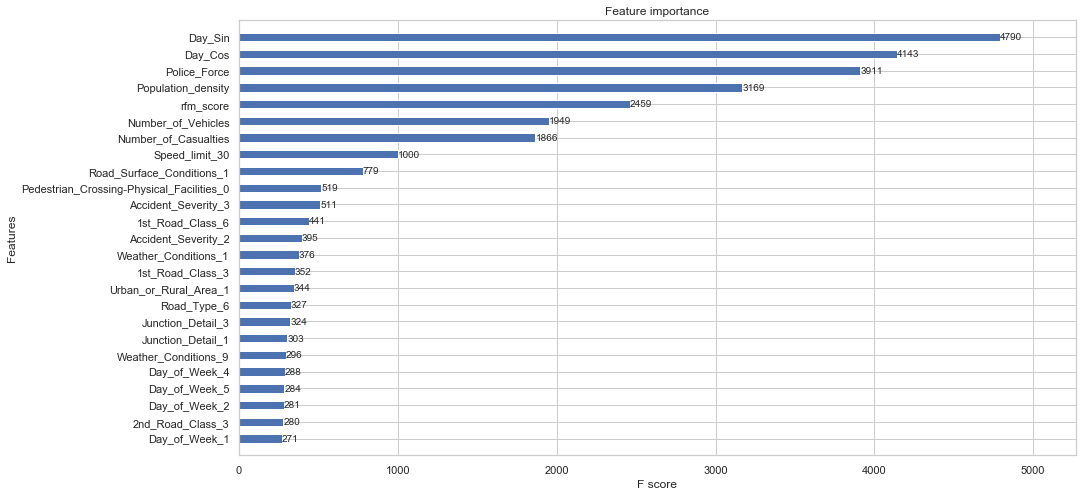

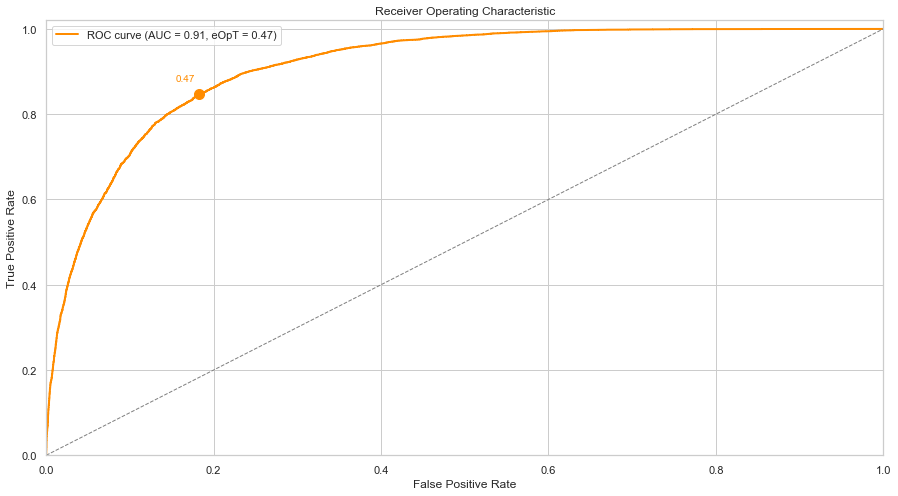

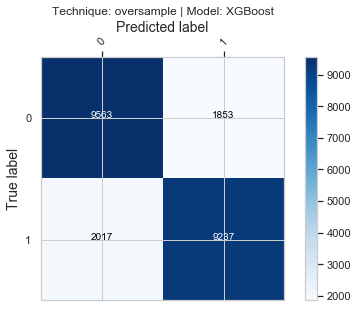

In [218]:
# Training Final Model
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='xgboost_model') as run:
    xgb_reg_main = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=[(dtest, "Test")], early_stopping_rounds=20)
    mlflow.set_tag('model_name', 'car_accidents_model_xgb')
    # Log Parameters
    mlflow.log_param('subsample', params['subsample'])
    mlflow.log_param('max_depth', params['max_depth'])
    mlflow.log_param('eta', params['eta'])
    mlflow.log_param('colsample_bytree', params['colsample_bytree'])
    mlflow.log_param('alpha', params['alpha'])
    y_xgb_preds_main = xgb_reg_main.predict(dtest)
    y_xgb_preds_main = [1 if n >= 0.5 else 0 for n in y_xgb_preds_main]
    y_xgb_preds_main_proba = xgb_reg_main.predict(dtest)
    # Calculating Metrics
    auc_xgb_main = roc_auc_score(y_test_oversample, y_xgb_preds_main_proba)
    acc_xgb_main = (y_xgb_preds_main == y_test_oversample).sum().astype(float) / len(y_xgb_preds_main)*100
    f1_xgb_main = f1_score(y_test_oversample, y_xgb_preds_main, average='micro')
    mcc_xgb_main = matthews_corrcoef(y_test_oversample, y_xgb_preds_main)
    features = X_train_oversample.columns
    # Feature Importance
    ax = xgb.plot_importance(xgb_reg_main, max_num_features=25, height=0.5, importance_type='weight')
    fig = ax.figure
    fig.set_size_inches(15, 8)
    fig.savefig('www/xgb_results/xgb_main_imp.png',dpi=100, bbox_inches = 'tight')
    # Test ROC
    roc_xgb_main = metric_graph(y_test_oversample, y_xgb_preds_main_proba, metric='roc', figsize=(15, 8), 
                            filename='www/xgb_results/xgb_main_roc.png')
    # Test Confusion Matrix
    import matplotlib.pyplot as plt
    class_names = np.unique(y_test_oversample)
    matrix = confusion_matrix(y_test_oversample, y_xgb_preds_main)
    plt.clf()
    # place labels at the top
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')
    # plot the matrix per se
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    # plot colorbar to the right
    plt.colorbar()
    fmt = 'd'
    # write the number of predictions in each bucket
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):

        # if background is dark, use a white number, and vice-versa
        plt.text(j, i, format(matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if matrix[i, j] > thresh else "black")
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label',size=14)
    plt.xlabel('Predicted label',size=14)
    plt.title('Technique: oversample | Model: XGBoost')
    plt.savefig('www/xgb_results/xgb_main_cm.png',dpi=100, bbox_inches = 'tight')
    # Test Log Metrics
    mlflow.log_metric('test_auc', auc_xgb_main)
    mlflow.log_metric('test_accuracy', acc_xgb_main)
    mlflow.log_metric('test_f1_score', f1_xgb_main)
    mlflow.log_metric('test_mcc_score', mcc_xgb_main)
    mlflow.log_artifacts('www/xgb_results')
    # Log Features
    pd.DataFrame(columns = X_train_oversample.columns).to_csv('xgb_features.csv', index=False)
    mlflow.log_artifact('xgb_features.csv', artifact_path='features')

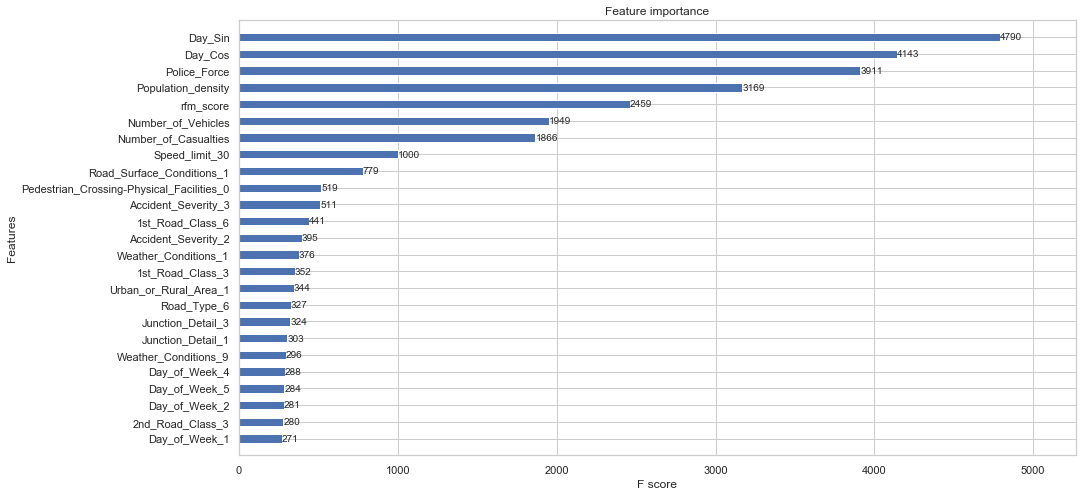

In [161]:
ax = xgb.plot_importance(xgb_reg_main, max_num_features=25, height=0.5, importance_type='weight')
fig = ax.figure
fig.set_size_inches(15, 8)

#### ROC Curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate

True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

- TPR = TP / TP + FN

False Positive Rate (FPR) is defined as follows:

- FPR = FP / FP + TN

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

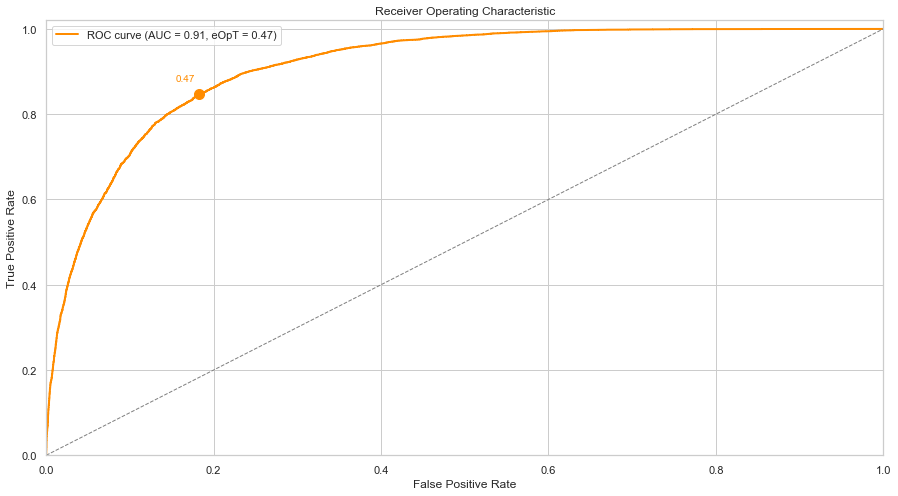

{'0': {'auc': {'val': 0.910900713461189, 'naive': 0.5},
  'eopt': {'val': 0.4682705,
   'x': 0.18202522775052557,
   'y': 0.8463657366269771}},
 'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fbf51eaf950>}

In [163]:
metric_graph(y_test_oversample, y_xgb_preds_main_proba, metric='roc', figsize=(15, 8))

#### Random Forest

In [164]:
# Hyperparameter tuning for Random Forest Model
rfc_reg = RandomForestClassifier()

params = {
        'bootstrap': [True, False],
        'class_weight': [None, 'balanced', 'balanced_subsample'],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': [3, 4, 6, 8],
        'min_samples_split': range(2, 10),
        'n_estimators': [100, 250, 500],
        'max_depth': [4, 6, 8, None],
        'ccp_alpha': [0.1, 0.0, 0.01, 0.001]
    }

with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='car_accidents_model_2') as run:
    random_search = RandomizedSearchCV(rfc_reg, params, cv=5, n_iter=50, verbose=1)
    start = time.time()
    random_search.fit(X_train_oversample,
                      y_train_oversample)
    best_parameters = random_search.best_params_
    print('RandomizedSearchCV Results: ')
    print(random_search.best_score_)
    print('Best Parameters: ')
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))
    end = time.time()
    print('time elapsed: ' + str(end-start))
    print(' ')
    print('Best Estimator: ')
    print(random_search.best_estimator_)
    y_pred_rfc_oversample = random_search.predict(X_test_oversample)

2021/09/25 20:51:50 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `{'bootstrap': [True, False], 'class_weight': [None, 'balanced', 'balanced_subsample'], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_leaf': [3, 4, 6, 8], 'min_samples_split': range(2, 10), 'n_estimators': [100, 250, 500], 'max_depth': [4,...`


Fitting 5 folds for each of 50 candidates, totalling 250 fits


2021/09/26 00:24:35 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under ./artifacts/0/77d1fd4297d44856993d18ecba56eed3/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.
2021/09/26 00:25:55 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under ./artifacts/0/77d1fd4297d44856993d18ecba56eed3/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.
2021/09/26 00:25:5

RandomizedSearchCV Results: 
0.8326716659314807
Best Parameters: 
bootstrap: False
ccp_alpha: 0.0
class_weight: 'balanced_subsample'
max_depth: None
max_features: 'sqrt'
min_samples_leaf: 3
min_samples_split: 3
n_estimators: 500
time elapsed: 12849.151228904724
 
Best Estimator: 
RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=3, n_estimators=500)


2021/09/26 03:04:41 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under ./artifacts/0/806df37a0a92452dbdaf889243bbf9c8/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.
2021/09/26 03:05:55 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under ./artifacts/0/806df37a0a92452dbdaf889243bbf9c8/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


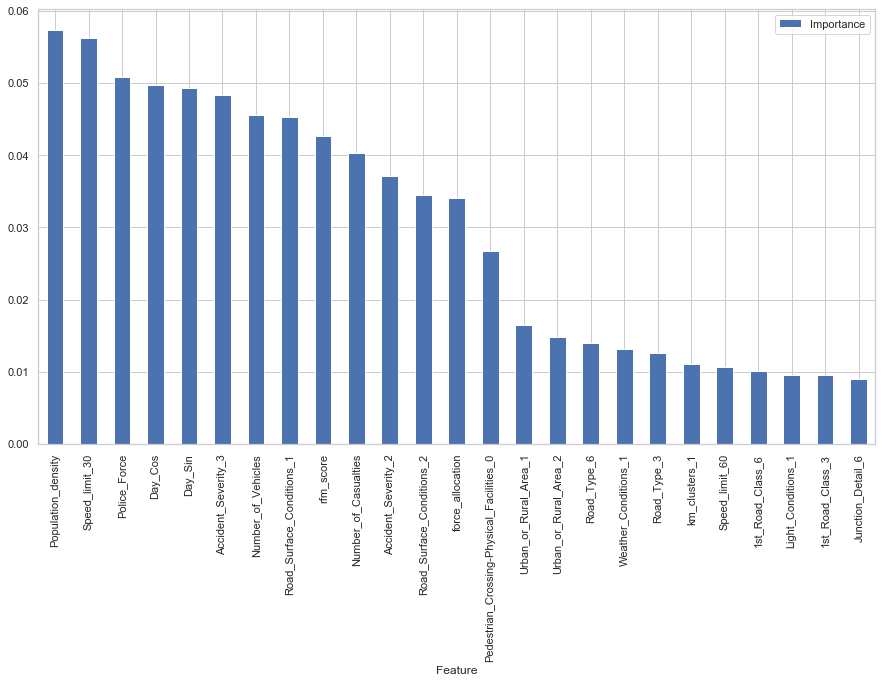

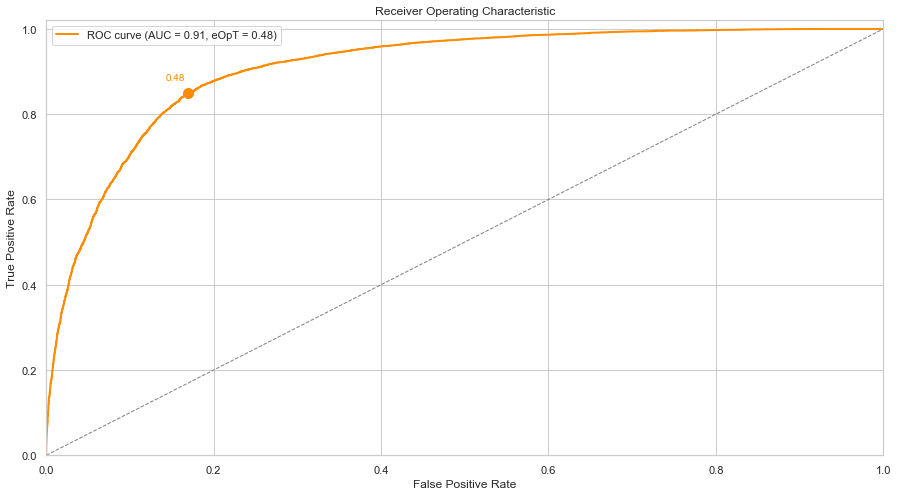

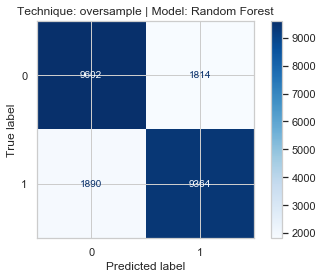

In [213]:
# Final Random Forest Model
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='random_forest_model') as run:
    rfc_reg_main = RandomForestClassifier(**random_search.best_params_)
    rfc_reg_main.fit(X_train_oversample, y_train_oversample)
    mlflow.set_tag('model_name', 'car_accidents_model_rf')
    # Save Model
    signature = infer_signature(X_train_oversample, rfc_reg_main.predict(X_train_oversample))
    mlflow.sklearn.log_model(rfc_reg_main, 'rf_model', signature=signature)
    y_preds_rfc_main = rfc_reg_main.predict(X_test_oversample)
    y_preds_rfc_main_proba = rfc_reg_main.predict_proba(X_test_oversample)
    # Calculating Metrics
    auc_rfc_main = roc_auc_score(y_test_oversample, y_preds_rfc_main_proba[:, 1])
    acc_rfc_main = (y_preds_rfc_main == y_test_oversample).sum().astype(float) / len(y_preds_rfc_main)*100
    f1_rfc_main = f1_score(y_test_oversample, y_preds_rfc_main, average='micro')
    mcc_rfc_main = matthews_corrcoef(y_test_oversample, y_preds_rfc_main)
    features = X_train_oversample.columns
    # Feature Importance
    rfc_importances_main = pd.DataFrame({'Feature': features, 'Importance': rfc_reg_main.feature_importances_})
    rfc_importances_main = rfc_importances_main.sort_values(by='Importance', ascending=False)
    rfc_importances_main = rfc_importances_main.set_index('Feature')
    imp_rfc_main = rfc_importances_main[:25].plot.bar(figsize=(15,8))
    fig = imp_rfc_main.get_figure()
    fig.savefig('www/rfc_results/rfc_main_imp.png',dpi=100, bbox_inches = 'tight')
    # Test ROC
    roc_rfc_main = metric_graph(y_test_oversample, y_preds_rfc_main_proba[:,1], metric='roc', figsize=(15, 8), 
                            filename='www/rfc_results/rfc_main_roc.png')
    # Test Confusion Matrix
    class_names = np.unique(y_test_oversample)
    disp_rfc = plot_confusion_matrix(rfc_reg_main, X_test_oversample, y_test_oversample,
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues)
    disp_rfc.ax_.set_title("Technique: oversample | Model: Random Forest")
    plt.savefig('www/rfc_results/rfc_main_cm.png',dpi=100, bbox_inches = 'tight')
    # Test Log Metrics
    mlflow.log_metric('test_auc', auc_rfc_main)
    mlflow.log_metric('test_accuracy', acc_rfc_main)
    mlflow.log_metric('test_f1_score', f1_rfc_main)
    mlflow.log_metric('test_mcc_score', mcc_rfc_main)
    mlflow.log_artifacts('www/rfc_results')
    # Log Features
    pd.DataFrame(columns = X_train_oversample.columns).to_csv('rf_features.csv', index=False)
    mlflow.log_artifact('rf_features.csv', artifact_path='features')

### Final Results

In [171]:
Random_Forest_Main = rfc_reg_main.predict(X_test_oversample)
Random_Forest_Main_Accuracy = (Random_Forest_Main == y_test_oversample).sum().astype(float) / len(Random_Forest_Main)*100
XGBoost_Main = xgb_reg_main.predict(dtest)
XGBoost_Main = [1 if n >= 0.5 else 0 for n in XGBoost_Main]
XGBoost_Main_Accuracy = (XGBoost_Main == y_test_oversample).sum().astype(float) / len(XGBoost_Main)*100
y_xgb_preds_main_proba = xgb_reg_main.predict(dtest)
auc_xgb_main = roc_auc_score(y_test_oversample, y_xgb_preds_main_proba)

In [173]:
val_main = pd.DataFrame({
    'Model': ['XGBoost','Random Forest'],
    'Technique': ['Oversample', 'Oversample'],
    'Accuracy': [XGBoost_Main_Accuracy,
              Random_Forest_Main_Accuracy],
    'AUC': [auc_xgb_main, auc_rfc_main]})
val_main_df = val_main.sort_values(by='AUC', ascending=False)
val_main_df = val_main_df.set_index('Model')
val_main_df

,Technique,Accuracy,AUC
Model,,,
XGBoost,Oversample,82.928981,0.910901
Random Forest,Oversample,83.736215,0.908752


Text(0.5, 1.0961281127972455, 'Technique: oversample | Model: XGBoost')

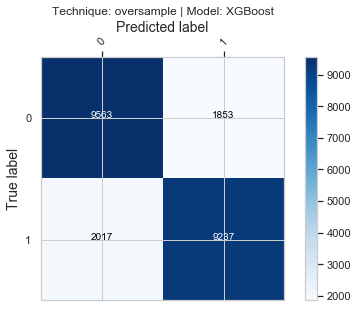

In [175]:
import matplotlib.pyplot as plt
matrix = confusion_matrix(y_test_oversample, XGBoost_Main)
plt.clf()
# place labels at the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
# plot the matrix per se
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
# plot colorbar to the right
plt.colorbar()
fmt = 'd'
# write the number of predictions in each bucket
thresh = matrix.max() / 2.
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):

    # if background is dark, use a white number, and vice-versa
    plt.text(j, i, format(matrix[i, j], fmt),
         horizontalalignment="center",
         color="white" if matrix[i, j] > thresh else "black")
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label',size=14)
plt.xlabel('Predicted label',size=14)
plt.title('Technique: oversample | Model: XGBoost')

Text(0.5, 1.0, 'Technique: Undersample | Model: Random Forest')

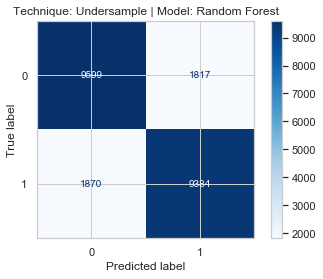

In [176]:
class_names = np.unique(y_test_oversample)
disp = plot_confusion_matrix(rfc_reg_main, X_test_oversample, y_test_oversample,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Technique: Undersample | Model: Random Forest")

In [182]:
print("XGBoost F1-Score:", f1_score(y_test_oversample, Random_Forest_Main, average='micro'))
print("Random Forest F1-Score:", f1_score(y_test_oversample, XGBoost_Main, average='micro'))

XGBoost F1-Score: 0.8373621526246139
Random Forest F1-Score: 0.8292898103220114


In [183]:
print("XGBoost MCC:", matthews_corrcoef(y_test_oversample, XGBoost_Main))
print("Random Forest MCC:", matthews_corrcoef(y_test_oversample, Random_Forest_Main))

XGBoost MCC: 0.6585958366083015
Random Forest MCC: 0.6747042008860599


In [192]:
test_data = test_data[['Accident_Index', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties','1st_Road_Class', 'Road_Type', 
       'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 
       'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Day_of_Week',
       'Urban_or_Rural_Area','traffic_category', 'rfm_score', 'force_allocation', 'Day_Sin', 
       'Day_Cos', 'km_clusters', 'Population_density', 'Did_Police_Officer_Attend_Scene_of_Accident']]

In [188]:
db_id = test_data['Accident_Index']
del test_data['Accident_Index']
del test_data['Did_Police_Officer_Attend_Scene_of_Accident']

#### One-Hot Encoding

In [186]:
columns_ = list(test_data.select_dtypes(include=['int64','float64']).columns)
str_columns = list(test_data.select_dtypes(include=['object']).columns)
db1 = test_data[columns_]
db2 = pd.get_dummies(test_data[str_columns])
test_data_ = pd.concat([db1, db2], axis = 1)

In [196]:
# Get missing columns in the training set
missing_cols = set(X_train_oversample.columns) - set(test_data_.columns)
# Add a missing column in prediction set with default value equal to 0
for i in missing_cols:
    test_data_[i] = 0
    test_data_[i] = test_data_[i].astype('uint8')
# Ensure the order of column in the prediction set is in the same order than in training set
test_data_ = test_data_[X_train_oversample.columns]

In [197]:
# Predict probability with XGBoost on unseen dataset for submission
XGBoost = xgb_reg_main.predict(xgb.DMatrix(test_data_))
car_accidents_1 = pd.DataFrame(XGBoost, columns=['XGB_PROBABILITY'])

# Predict probability with Random Forest on unseen dataset for submission
Random_Forest_Flag = rfc_reg_main.predict(test_data_)
Random_Forest_Probability = rfc_reg_main.predict_proba(test_data_)

In [201]:
# Combine XGB and RF predictions and create average probability
car_accidents_submission = pd.concat([db_id, test_data_, 
                         pd.DataFrame(Random_Forest_Probability[:,1], columns=['RF_PROBABILITY']), 
                         pd.DataFrame(Random_Forest_Flag, columns=['RF_FLAG'])], axis = 1)
car_accidents_submission = pd.concat([car_accidents_submission, car_accidents_1], axis = 1)

# Create average prediction column
car_accidents_submission['probability_to_attend'] = car_accidents_submission[['XGB_PROBABILITY','RF_PROBABILITY']].mean(axis=1)

In [207]:
# Final submission
submission = car_accidents_submission[['Accident_Index','probability_to_attend']]

In [209]:
# Save as .csv
submission.to_csv('car_accidents_submission.csv', index=False)